# Embedding Analysis

In [1]:
import torch
import torchvision
import os
import pickle
import random
from os.path import join as j_
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances, silhouette_score
import umap.umap_ as umap

/home/billy/anaconda3/envs/UNI/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load train_features and test_features from files
with open('train_features_portal_tract_separated.pkl', 'rb') as f:
    loaded_train_features = pickle.load(f)

with open('test_features_portal_tract_separated.pkl', 'rb') as f:
    loaded_test_features = pickle.load(f)

# Convert to tensors
train_feats = torch.Tensor(loaded_train_features['embeddings'])
train_labels = torch.Tensor(loaded_train_features['labels']).type(torch.long)
test_feats = torch.Tensor(loaded_test_features['embeddings'])
test_labels = torch.Tensor(loaded_test_features['labels']).type(torch.long)

In [3]:
train_feats.shape

torch.Size([3116, 1536])

In [4]:
test_feats.shape

torch.Size([912, 1536])

In [ ]:
# train_df = pd.read_csv('train_index_path_mix.csv', index_col="idx")

In [5]:
SEED=42

In [ ]:

train_feats = normalize(train_feats, norm="l2")
pca = PCA(n_components=50, random_state=SEED)
emb_pca = pca.fit_transform(train_feats)



In [7]:
print(f"PCA: {train_feats.shape}  →  {emb_pca.shape}")

PCA: (218660, 1536)  →  (218660, 50)


In [8]:
umap_coords = umap.UMAP(n_components=2, random_state=SEED).fit_transform(emb_pca)

/home/billy/anaconda3/envs/UNI/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/billy/anaconda3/envs/UNI/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [12]:
df_umap = pd.DataFrame({
    "idx": train_df.index,
    "umap_x": umap_coords[:, 0],
    "umap_y": umap_coords[:, 1],
    "patient_id": train_df["patient_id"].values
})

In [15]:
df_umap.to_csv("train_umap.csv", index=False)

In [ ]:
# def scatter_and_save(df, xcol, ycol, outfile, title):
#     fig, ax = plt.subplots(figsize=(18,10), dpi=1000)
#     for pid, sub in df.groupby("patient_id"):
#         ax.scatter(sub[xcol], sub[ycol], s=6, alpha=0.7, label=pid)
#     ax.set_title(title); ax.set_xlabel(xcol); ax.set_ylabel(ycol)
#     ax.legend(markerscale=3, bbox_to_anchor=(1.02,1),
#               loc="upper left", frameon=False)
#     plt.tight_layout(); fig.savefig(outfile, dpi=300); plt.close(fig)
#     print(f"✓ plot → {outfile}")

In [ ]:
# scatter_and_save(df_umap, "umap_x", "umap_y",
#                      "train_umap_patient.png",
#                      "Train UMAP (PCA‑50) coloured by patient")

✓ plot → train_umap_patient.png


In [3]:

# ── 2. Convenience plotting palette ────────────────────────────────────
COLORS = {0: "#1f77b4",   # blue   – Response
          1: "#d62728"}   # red    – No‑Response

# ── 3. Dim‑red utility  ────────────────────────────────────────────────
def embed_2d(emb, method="tsne", pca_dim=50, random_state=42):
    """
    Returns 2-D embedding using PCA→(t‑SNE | UMAP).

    Parameters
    ----------
    emb : (N, D) ndarray
    method : str  – 'tsne' | 'umap' | 'pca2'
    pca_dim : int – intermediate PCA dim for t‑SNE/UMAP
    """
    emb_std = normalize(emb, norm="l2")           # cosine distance ≈ Euclidean after L2‑norm
    if method == "pca2":
        return PCA(n_components=2, random_state=random_state).fit_transform(emb_std)

    emb_pca = PCA(n_components=min(pca_dim, emb.shape[1]),
                  random_state=random_state).fit_transform(emb_std)
    emb_pca = emb_std

    if method == "tsne":
        tsne = TSNE(n_components=2,
                    perplexity=30,
                    metric="euclidean",
                    init="random",
                    random_state=random_state)
        return tsne.fit_transform(emb_pca)

    elif method == "umap":
        um = umap.UMAP(n_components=2,
                  n_neighbors=15,
                  min_dist=0.1,
                  metric="euclidean",
                  random_state=random_state)
        return um.fit_transform(emb_pca)

    else:
        raise ValueError("method must be 'tsne', 'umap', or 'pca2'")

# ── 4. Main analysis function ──────────────────────────────────────────
def analyse_embeddings(asset_dict, method="tsne", save_fig=None):
    """
    Plot & analyse the patch embeddings.

    Parameters
    ----------
    asset_dict : dict  – output of extract_patch_features_from_dataloader
    method      : str  – 'tsne' | 'umap' | 'pca2'
    save_fig    : str or None – filename to save the scatter (png/pdf)
    """
    emb   = asset_dict["embeddings"]
    label = asset_dict["labels"]

    # 4.1  2‑D embedding
    emb2 = embed_2d(emb, method=method)

    # 4.2  Scatter
    fig, ax = plt.subplots(figsize=(6, 5))
    for cls in np.unique(label):
        idx = label == cls
        ax.scatter(emb2[idx, 0], emb2[idx, 1],
                   s=12, alpha=0.8, c=COLORS[cls],
                   label=f"{'Response' if cls==0 else 'No Response'} ({idx.sum()})")
    ax.set_title(f"{method.upper()} view of patch embeddings")
    ax.set_xlabel("dim‑1")
    ax.set_ylabel("dim‑2")
    ax.legend(frameon=False)
    plt.tight_layout()
    if save_fig:
        plt.savefig(save_fig, dpi=300)
    plt.show()

    # 4.3  Separation metrics ------------------------------------------
    # pairwise cosine distances
    dist = pairwise_distances(normalize(emb), metric="cosine")
    intra0 = dist[np.ix_(label==0, label==0)].mean()
    intra1 = dist[np.ix_(label==1, label==1)].mean()
    inter  = dist[np.ix_(label==0, label==1)].mean()
    sil    = silhouette_score(emb, label, metric="cosine")

    print("\n── Distance summary (cosine) ──")
    print(f" Response   intra‑class: {intra0:.4f}")
    print(f" No‑Response intra‑class: {intra1:.4f}")
    print(f" Inter‑class distance : {inter:.4f}")
    print(f" Silhouette score     : {sil:.4f}")

    return emb2


# ── 5. Helper: inspect nearest neighbours of a patch ───────────────────
def nearest_patches(asset_dict, patch_idx, topk=5):
    """
    Return indices & distances of k nearest patches to `patch_idx`
    using cosine distance in original embedding space.
    """
    emb = normalize(asset_dict["embeddings"])
    d   = pairwise_distances(emb[patch_idx, :].reshape(1,-1), emb, metric="cosine")[0]
    nn  = np.argsort(d)[:topk+1]       # includes self at position 0
    return pd.DataFrame({"idx": nn, "dist": d[nn], "label": asset_dict["labels"][nn]})




/home/billy/anaconda3/envs/UNI/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/billy/anaconda3/envs/UNI/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


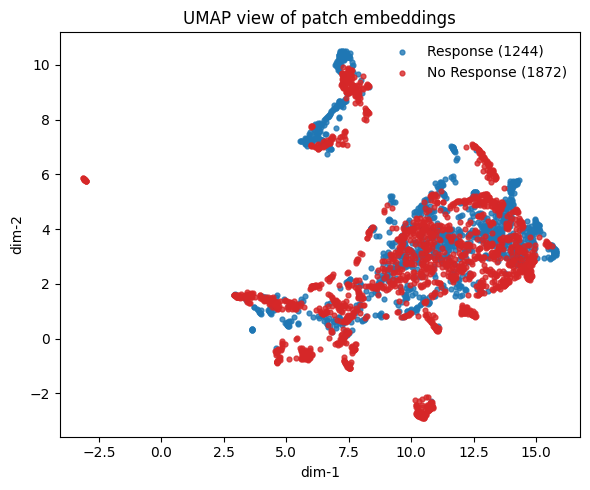


── Distance summary (cosine) ──
 Response   intra‑class: 0.5815
 No‑Response intra‑class: 0.6280
 Inter‑class distance : 0.6128
 Silhouette score     : 0.0038


array([[12.820884 ,  6.6502733],
       [11.213684 ,  5.6090984],
       [ 6.0308223,  7.212401 ],
       ...,
       [11.702673 ,  6.9014874],
       [13.687007 ,  3.258073 ],
       [ 7.217846 ,  9.688796 ]], dtype=float32)

In [4]:
analyse_embeddings(loaded_train_features, method="umap", save_fig="UMAP_train_separated_portal_tracts_patches")

/home/billy/anaconda3/envs/UNI/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/billy/anaconda3/envs/UNI/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


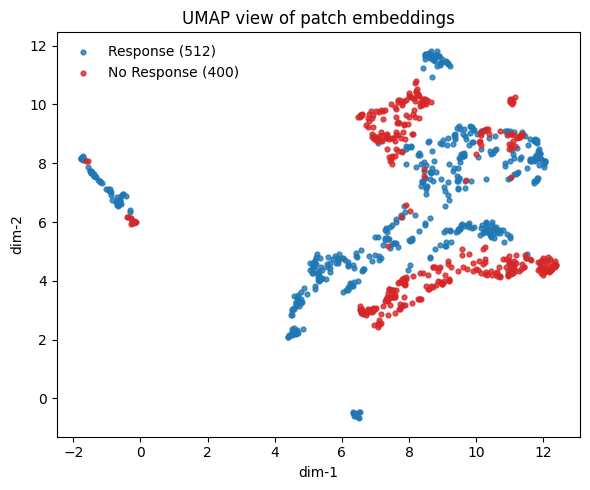


── Distance summary (cosine) ──
 Response   intra‑class: 0.6339
 No‑Response intra‑class: 0.5706
 Inter‑class distance : 0.6281
 Silhouette score     : 0.0317


array([[ 8.517838 ,  7.202145 ],
       [-1.7445126,  8.212284 ],
       [ 9.048502 ,  7.1833634],
       ...,
       [ 8.245099 , 10.536007 ],
       [11.601232 ,  4.752055 ],
       [ 6.821259 ,  2.9425075]], dtype=float32)

In [5]:
analyse_embeddings(loaded_test_features, method="umap", save_fig="UMAP_test_separated_portal_tracts_patches")

In [ ]:
analyse_embeddings(loaded_test_features, method="umap", save_fig="UMAP_mix_patches")

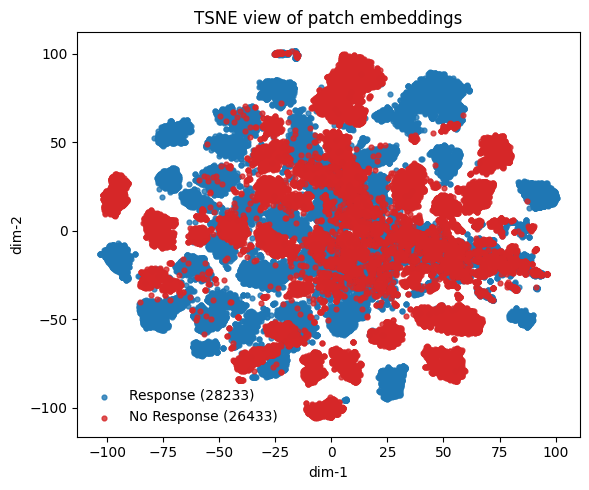

: 

In [11]:
# Visualise and analyse
emb2d = analyse_embeddings(loaded_test_features, method="tsne", save_fig="tsne_patches_without_pca.png")

# Explore neighbourhood of the first patch
print("\nNearest neighbours of patch 0:")
print(nearest_patches(loaded_test_features, patch_idx=0, topk=5))

/tmp/ipykernel_44427/1974107990.py:80: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_44427/1974107990.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(save_fig, dpi=300)
/home/billy/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


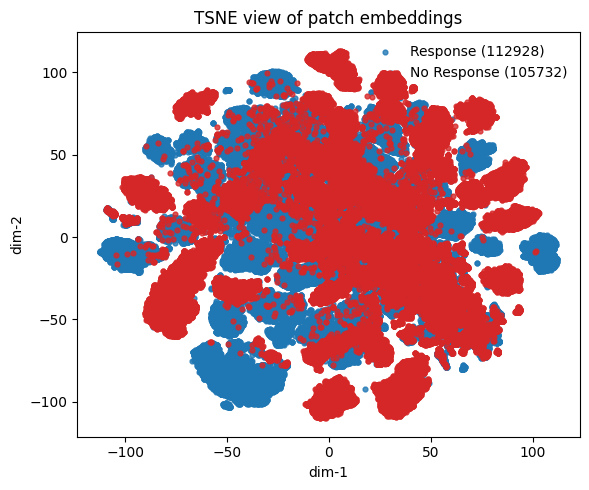

MemoryError: Unable to allocate 178. GiB for an array with shape (218660, 218660) and data type float32

In [4]:
# Visualise and analyse
emb2d = analyse_embeddings(loaded_train_features, method="tsne", save_fig="tsne_patches_without_pca.png")

# Explore neighbourhood of the first patch
print("\nNearest neighbours of patch 0:")
print(nearest_patches(loaded_train_features, patch_idx=0, topk=5))

In [5]:
import umap.umap_ as umap

emb2d = analyse_embeddings(loaded_train_features, method="umap", save_fig="umap_patches_without_pca.png")

# Explore neighbourhood of the first patch
print("\nNearest neighbours of patch 0:")
print(nearest_patches(loaded_train_features, patch_idx=0, topk=5))

/home/billy/anaconda3/envs/UNI/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/billy/anaconda3/envs/UNI/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


: 

/home/billy/anaconda3/envs/UNI/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/billy/anaconda3/envs/UNI/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


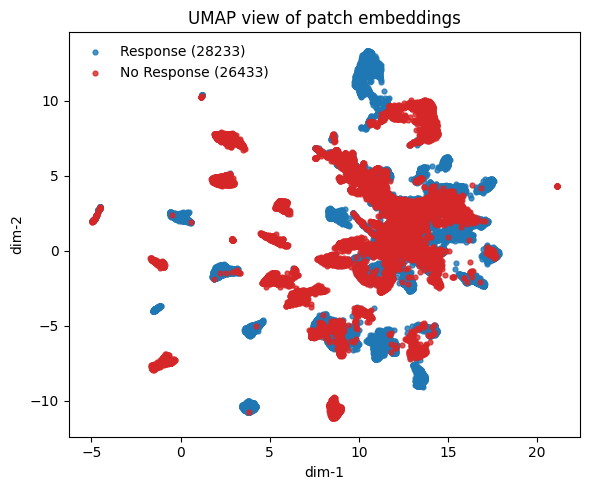

: 

In [4]:
import umap.umap_ as umap

emb2d = analyse_embeddings(loaded_test_features, method="umap", save_fig="umap_patches_without_pca.png")

# Explore neighbourhood of the first patch
print("\nNearest neighbours of patch 0:")
print(nearest_patches(loaded_test_features, patch_idx=0, topk=5))

# Pathology Clinical AI Analysis

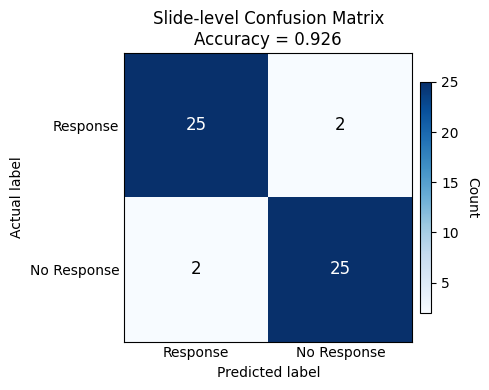

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ─── Confusion‑matrix data ─────────────────────────────────────────────
cm = np.array([[25, 2], 
               [2, 25]])

classes = ["Response", "No Response"]   # class 0, class 1
accuracy = cm.trace() / cm.sum()

# ─── Plot ──────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(5, 4))

im = ax.imshow(cm, cmap="Blues")

# Add text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm[i, j]}",
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max()/2 else "black",
                fontsize=12)

# Axis ticks & labels
ax.set_xticks(np.arange(len(classes)), labels=classes)
ax.set_yticks(np.arange(len(classes)), labels=classes)
ax.set_xlabel("Predicted label")
ax.set_ylabel("Actual label")
ax.set_title(f"Slide‑level Confusion Matrix\nAccuracy = {accuracy:.3f}")
ax.tick_params(axis=u'both', which=u'both', length=0)  # hide tick marks

# Color‑bar
cbar = plt.colorbar(im, shrink=0.8, pad=0.02)
cbar.ax.set_ylabel("Count", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

## Importing Necessary libraries

In [1]:
import pandas as pd
import numpy as np
import pprint
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

## Dataset Background

In [4]:
df = pd.read_csv('cleaned_dataset.csv')

In [5]:
df.columns

Index(['Patient study id Biopsy #1', 'Gender', 'Date of birth ',
       'Date of transplant', 'Biopsy (accession) Date Biopsy #1',
       'ALT Biopsy #1', 'AST Biopsy #1', 'AST/ALT ratio', 'ALP Biopsy #1',
       'Tbili Biopsy #1', 'Creatinine (umol or mg/dl) ', 'INR',
       'Sodium (mmol/L)', 'Platelets', 'RAI Classification Biopsy #2'],
      dtype='object')

## Exploratory Data Analysis

### 1.  Understanding the Target Variable, `DGF`

**Checking the distribution of our target variable, DGF (`dgf`)**. This will help me decide on potential strategies for model training, such as resampling techniques or weighted losses.

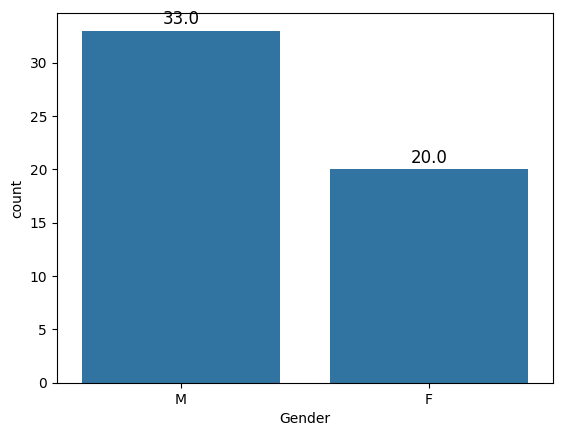

In [5]:
# Create the count plot
ax = sns.countplot(x='Gender', data=df)

# Add labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Show the plot
plt.show()

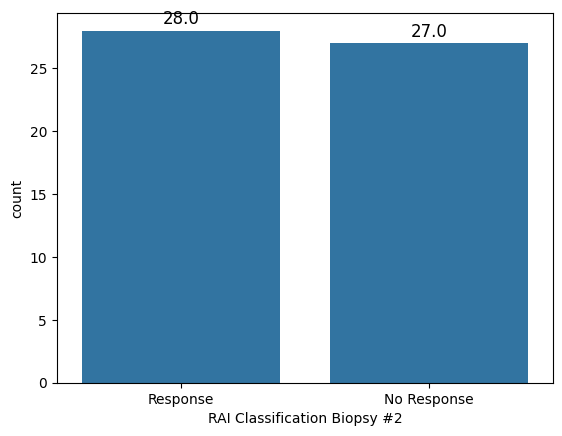

In [8]:
# Create the count plot
ax = sns.countplot(x='RAI Classification Biopsy #2', data=df)

# Add labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Show the plot
plt.show()

**Calculate the percentage of cases with and without DGF. This gives an idea of how rare DGF is in the dataset.**

In [6]:
df['RAI Classification Biopsy #2'].value_counts(normalize=True)

RAI Classification Biopsy #2
Response       0.509091
No Response    0.490909
Name: proportion, dtype: float64

## Data Preparation for Machine Learning Training

**Initially, we should remove the 'study_id' column, as it does not influence DGF. Retaining it could potentially introduce biases.**

In [7]:
df_cleaned = df.drop(columns=['Patient study id Biopsy #1'])

In [8]:
df_cleaned.columns

Index(['Gender', 'Date of birth ', 'Date of transplant',
       'Biopsy (accession) Date Biopsy #1', 'ALT Biopsy #1', 'AST Biopsy #1',
       'AST/ALT ratio', 'ALP Biopsy #1', 'Tbili Biopsy #1',
       'Creatinine (umol or mg/dl) ', 'INR', 'Sodium (mmol/L)', 'Platelets',
       'RAI Classification Biopsy #2'],
      dtype='object')

### Dropping date columns

In [9]:
df_cleaned['Transplant Age'] = (((pd.to_datetime(df_cleaned['Date of transplant']) - pd.to_datetime(df_cleaned['Date of birth '])).dt.days)/365).astype(float)

In [10]:
df_cleaned['Biopsy Age'] = (((pd.to_datetime(df_cleaned['Biopsy (accession) Date Biopsy #1']) - pd.to_datetime(df_cleaned['Date of birth '])).dt.days)/365).astype(float)

In [11]:
df_cleaned['Transplant Biopsy Diff'] = (((pd.to_datetime(df_cleaned['Biopsy (accession) Date Biopsy #1']) - pd.to_datetime(df_cleaned['Date of transplant'])).dt.days)/365).astype(float)

In [12]:
df_cleaned.drop(columns=['Date of birth ', 'Date of transplant', 'Biopsy (accession) Date Biopsy #1'], inplace=True)

### Dropping unnecessary columns

In [13]:
df_cleaned.columns

Index(['Gender', 'ALT Biopsy #1', 'AST Biopsy #1', 'AST/ALT ratio',
       'ALP Biopsy #1', 'Tbili Biopsy #1', 'Creatinine (umol or mg/dl) ',
       'INR', 'Sodium (mmol/L)', 'Platelets', 'RAI Classification Biopsy #2',
       'Transplant Age', 'Biopsy Age', 'Transplant Biopsy Diff'],
      dtype='object')

### **Handling Missing Data**

- **Calculate The percentage of missing data for each variable**

In [14]:
# Calculate the count and percentage of missing values
missing_data = df_cleaned.isnull().sum().to_frame(name='Missing Count')
missing_data['Percentage'] = (df_cleaned.isnull().sum() / len(df_cleaned) * 100).round(2)

In [15]:
missing_data

Missing Count  Percentage
Gender                                    2        3.64
ALT Biopsy #1                             0        0.00
AST Biopsy #1                             0        0.00
AST/ALT ratio                             0        0.00
ALP Biopsy #1                             0        0.00
Tbili Biopsy #1                           0        0.00
Creatinine (umol or mg/dl)                0        0.00
INR                                       0        0.00
Sodium (mmol/L)                           0        0.00
Platelets                                 0        0.00
RAI Classification Biopsy #2              0        0.00
Transplant Age                            2        3.64
Biopsy Age                                2        3.64
Transplant Biopsy Diff                    0        0.00

In [16]:
missing_data[missing_data['Missing Count']>0]

Missing Count  Percentage
Gender                      2        3.64
Transplant Age              2        3.64
Biopsy Age                  2        3.64

**For date columns, we convert it to days differences with transplant date**

In [17]:
# df_cleaned['days_to_readmission'] = (pd.to_datetime(df_cleaned['first_re_admdt']) - pd.to_datetime(df_cleaned['txdate'])).dt.days
# df_cleaned['days_to_status'] = (pd.to_datetime(df_cleaned['statusdt_censored']) - pd.to_datetime(df_cleaned['txdate'])).dt.days
# df_cleaned['days_to_bpar'] = (pd.to_datetime(df_cleaned['first_bpardt']) - pd.to_datetime(df_cleaned['txdate'])).dt.days.fillna(0)
# df_cleaned = df_cleaned.drop(columns=['first_re_admdt', 'statusdt_censored', 'txdate', 'first_bpardt'])


**For Categorical variables, we map it to class 1, class 2, and class 3**

In [18]:
# Summary for categorical variables
cat_summary = df_cleaned.describe(include='object')

In [19]:
for col in cat_summary.columns:
    print(f"{col}:", df_cleaned[col].unique())

Gender: ['M' 'F' nan]
RAI Classification Biopsy #2: ['Response' 'No Response']


In [20]:
# Define mappings for each categorical column based on the provided unique values
mappings = {
    'RAI Classification Biopsy #2': {'Response': 1, 'No Response': 0},
    'Gender': {'F': 0, 'M': 1},
}

# Apply mappings to the DataFrame
for column, mapping in mappings.items():
    df_cleaned[column] = df_cleaned[column].map(mapping)


In [21]:
# Function to impute missing values in a column using RandomForestClassifier
def impute_column(df, col):
    # Separate the rows with and without missing values
    df_missing = df[df[col].isnull()]
    df_not_missing = df[df[col].notnull()]
    
    # If there are no missing values, return the original DataFrame
    if df_missing.empty:
        return df
    
    # Prepare the training data
    X = df_not_missing.drop(columns=[col])
    y = df_not_missing[col]
    
    # Prepare the data to predict
    X_missing = df_missing.drop(columns=[col])
    
    # Train the model
    model = RandomForestClassifier()
    model.fit(X, y)
    
    # Predict the missing values
    df.loc[df[col].isnull(), col] = model.predict(X_missing)
    
    return df

In [22]:
# Apply the imputation function to each categorical column
for col in cat_summary.columns:
    df_cleaned = impute_column(df_cleaned, col)

In [23]:
df_cleaned.sample(10)

Gender  ALT Biopsy #1  AST Biopsy #1  AST/ALT ratio  ALP Biopsy #1  \
52     1.0            100             44           0.44            403   
17     0.0            171             93           0.54             98   
30     0.0            230             60           0.26            174   
54     1.0            932            761           0.82           1308   
26     0.0            186            162           0.87            329   
37     0.0            178            111           0.62            219   
4      1.0            445            315           0.71           1349   
18     1.0            266            330           1.24            424   
11     1.0            810            267           0.33            649   
35     1.0            208            269           1.29           1134   

    Tbili Biopsy #1  Creatinine (umol or mg/dl)    INR  Sodium (mmol/L)  \
52               32                           98  1.10              134   
17               35                          130  1.14              135   
30              212                           61  1.01              137   
54               86                           71  1.10              134   
26               18                           60  0.89              139   
37              274                           64  1.10              136   
4                58                          128  1.00              128   
18              126                           45  1.67              132   
11               20                          139  1.00              139   
35              217                          323  1.30              130   

    Platelets  RAI Classification Biopsy #2  Transplant Age  Biopsy Age  \
52        104                             1       36.597260   36.635616   
17        130                             1       54.800000   54.838356   
30         85                             0       70.369863   70.391781   
54        203                             0       66.934247   67.873973   
26        254                             0       18.816438   19.408219   
37         52                             0       21.906849   21.923288   
4         208                             0       55.476712   55.769863   
18         75                             0       39.649315   40.090411   
11        141                             1       62.712329   62.800000   
35        312                             0       64.005479   64.780822   

    Transplant Biopsy Diff  
52                0.038356  
17                0.038356  
30                0.021918  
54                0.939726  
26                0.591781  
37                0.016438  
4                 0.293151  
18                0.441096  
11                0.087671  
35                0.775342

**Now all categorical variables have become numerical variables**

In [24]:
def little_mcar_test(data, alpha=0.05):
    """
    Performs Little's MCAR (Missing Completely At Random) test on a dataset with missing values.
    
    Parameters:
    data (DataFrame): A pandas DataFrame with n observations and p variables, where some values are missing.
    alpha (float): The significance level for the hypothesis test (default is 0.05).
    
    Returns:
    A tuple containing:
    - A matrix of missing values that represents the pattern of missingness in the dataset.
    - A p-value representing the significance of the MCAR test.
    """
    
    # Calculate the proportion of missing values in each variable
    p_m = data.isnull().mean()
    
    # Calculate the proportion of complete cases for each variable
    p_c = data.dropna().shape[0] / data.shape[0]
    
    # Calculate the correlation matrix for all pairs of variables that have complete cases
    R_c = data.dropna().corr()
    
    # Calculate the correlation matrix for all pairs of variables using all observations
    R_all = data.corr()
    
    # Calculate the difference between the two correlation matrices
    R_diff = R_all - R_c
    
    # Calculate the variance of the R_diff matrix
    V_Rdiff = np.var(R_diff, ddof=1)
    
    # Calculate the expected value of V_Rdiff under the null hypothesis that the missing data is MCAR
    E_Rdiff = (1 - p_c) / (1 - p_m).sum()
    
    # Calculate the test statistic
    T = np.trace(R_diff) / np.sqrt(V_Rdiff * E_Rdiff)
    
    # Calculate the degrees of freedom
    df = data.shape[1] * (data.shape[1] - 1) / 2
    
    # Calculate the p-value using a chi-squared distribution with df degrees of freedom and the test statistic T
    p_value = 1 - chi2.cdf(T ** 2, df)
    
    # Create a matrix of missing values that represents the pattern of missingness in the dataset
    missingness_matrix = data.isnull().astype(int)
    
    # Return the missingness matrix and the p-value
    return missingness_matrix, p_value

In [25]:
missingness_matrix, p_value = little_mcar_test(df_cleaned)

/home/billy/anaconda3/envs/UNI/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3785: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [26]:
p_value

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., nan, nan,
        1.])

In hypothesis testing, the **p-value** helps us determine whether to reject the null hypothesis. The null hypothesis (H₀) typically represents a default position or a statement of no effect or no difference.

- **P-value**: The probability of obtaining test results at least as extreme as the observed results, assuming that the null hypothesis is true.

When I performed a test, I compare the p-value to a significance level (α), often set at 0.05.

- **If the p-value is less than α (e.g., 0.05)**: There is strong evidence against the null hypothesis, so I reject it.
- **If the p-value is greater than α**: There is not enough evidence to reject the null hypothesis.

In My case, a p-value of 1.0 means that the observed data is perfectly consistent with the null hypothesis. This indicates that there is no evidence to suggest that the missing data is not Missing Completely At Random (MCAR). Essentially, the data's missingness pattern is random and not related to any other variables in the dataset.

So, a p-value of 1.0 means that the null hypothesis (that the data is MCAR) holds true, and there's no reason to believe otherwise based on thr data.

**Now, we fill the missing rows for categorical variables with Mode**

In [27]:
# # Fill missing values with the ratio of unique values of non-missing values
# for col in cat_summary.columns:
#     if df_cleaned[col].isnull().any():
#         value_counts = df_cleaned[col].value_counts(normalize=True)
#         random_numbers = np.random.rand(df_cleaned[col].isnull().sum())
#         cumulative_distribution = value_counts.cumsum()
#         fill_values = [value_counts.index[(cumulative_distribution >= rn).argmax()] for rn in random_numbers]
#         df_cleaned.loc[df_cleaned[col].isnull(), col] = fill_values

**And, we fill the missing rows for numerical variables with mean**

In [28]:
# Summary for numerical variables
num_summary = df_cleaned.describe()

num_summary

Gender  ALT Biopsy #1  AST Biopsy #1  AST/ALT ratio  ALP Biopsy #1  \
count  55.000000      55.000000      55.000000      55.000000      55.000000   
mean    0.618182     352.490909     181.200000       0.626182     462.309091   
std     0.490310     372.262346     162.378433       0.313035     338.784257   
min     0.000000      19.000000      14.000000       0.190000      80.000000   
25%     0.000000     121.000000      62.000000       0.330000     248.000000   
50%     1.000000     207.000000     111.000000       0.580000     369.000000   
75%     1.000000     450.500000     265.000000       0.825000     527.500000   
max     1.000000    1938.000000     761.000000       1.470000    1540.000000   

       Tbili Biopsy #1  Creatinine (umol or mg/dl)         INR  \
count        55.000000                    55.000000  55.000000   
mean         97.145455                    95.690909   1.130727   
std          82.486007                    50.984701   0.162798   
min           7.000000                    45.000000   0.890000   
25%          25.000000                    63.500000   1.005000   
50%          86.000000                    82.000000   1.100000   
75%         138.500000                   104.500000   1.175000   
max         360.000000                   323.000000   1.670000   

       Sodium (mmol/L)   Platelets  RAI Classification Biopsy #2  \
count        55.000000   55.000000                     55.000000   
mean        136.090909  164.090909                      0.509091   
std           4.903788   83.294051                      0.504525   
min         127.000000   23.000000                      0.000000   
25%         133.000000   98.000000                      0.000000   
50%         137.000000  144.000000                      1.000000   
75%         139.000000  220.000000                      1.000000   
max         150.000000  355.000000                      1.000000   

       Transplant Age  Biopsy Age  Transplant Biopsy Diff  
count       53.000000   53.000000               55.000000  
mean        53.433755   54.106953                0.656787  
std         13.812609   13.302026                1.632609  
min         17.284932   19.408219                0.000000  
25%         49.443836   49.652055                0.021918  
50%         57.641096   57.693151                0.087671  
75%         63.309589   63.394521                0.516438  
max         70.369863   70.391781                8.791781

In [29]:
df.describe()

ALT Biopsy #1  AST Biopsy #1  AST/ALT ratio  ALP Biopsy #1  \
count      55.000000      55.000000      55.000000      55.000000   
mean      352.490909     181.200000       0.626182     462.309091   
std       372.262346     162.378433       0.313035     338.784257   
min        19.000000      14.000000       0.190000      80.000000   
25%       121.000000      62.000000       0.330000     248.000000   
50%       207.000000     111.000000       0.580000     369.000000   
75%       450.500000     265.000000       0.825000     527.500000   
max      1938.000000     761.000000       1.470000    1540.000000   

       Tbili Biopsy #1  Creatinine (umol or mg/dl)         INR  \
count        55.000000                    55.000000  55.000000   
mean         97.145455                    95.690909   1.130727   
std          82.486007                    50.984701   0.162798   
min           7.000000                    45.000000   0.890000   
25%          25.000000                    63.500000   1.005000   
50%          86.000000                    82.000000   1.100000   
75%         138.500000                   104.500000   1.175000   
max         360.000000                   323.000000   1.670000   

       Sodium (mmol/L)   Platelets  
count        55.000000   55.000000  
mean        136.090909  164.090909  
std           4.903788   83.294051  
min         127.000000   23.000000  
25%         133.000000   98.000000  
50%         137.000000  144.000000  
75%         139.000000  220.000000  
max         150.000000  355.000000

In [30]:
# Function to impute missing values in a column using RandomForestClassifier
def impute_cont_column(df, col):
    # Separate the rows with and without missing values
    df_missing = df[df[col].isnull()]
    df_not_missing = df[df[col].notnull()]
    
    # If there are no missing values, return the original DataFrame
    if df_missing.empty:
        return df
    
    # Prepare the training data
    X = df_not_missing.drop(columns=[col])
    y = df_not_missing[col]
    
    # Prepare the data to predict
    X_missing = df_missing.drop(columns=[col])
    
    # Train the model
    model = RandomForestRegressor()
    model.fit(X, y)
    
    # Predict the missing values
    df.loc[df[col].isnull(), col] = model.predict(X_missing)
    
    return df

In [31]:
# Apply the imputation function to each continous column
for col in num_summary.columns:
    df_cleaned = impute_cont_column(df_cleaned, col)

In [32]:
# for col in num_summary.columns:
#     df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())

In [33]:
df_cleaned.describe()

Gender  ALT Biopsy #1  AST Biopsy #1  AST/ALT ratio  ALP Biopsy #1  \
count  55.000000      55.000000      55.000000      55.000000      55.000000   
mean    0.618182     352.490909     181.200000       0.626182     462.309091   
std     0.490310     372.262346     162.378433       0.313035     338.784257   
min     0.000000      19.000000      14.000000       0.190000      80.000000   
25%     0.000000     121.000000      62.000000       0.330000     248.000000   
50%     1.000000     207.000000     111.000000       0.580000     369.000000   
75%     1.000000     450.500000     265.000000       0.825000     527.500000   
max     1.000000    1938.000000     761.000000       1.470000    1540.000000   

       Tbili Biopsy #1  Creatinine (umol or mg/dl)         INR  \
count        55.000000                    55.000000  55.000000   
mean         97.145455                    95.690909   1.130727   
std          82.486007                    50.984701   0.162798   
min           7.000000                    45.000000   0.890000   
25%          25.000000                    63.500000   1.005000   
50%          86.000000                    82.000000   1.100000   
75%         138.500000                   104.500000   1.175000   
max         360.000000                   323.000000   1.670000   

       Sodium (mmol/L)   Platelets  RAI Classification Biopsy #2  \
count        55.000000   55.000000                     55.000000   
mean        136.090909  164.090909                      0.509091   
std           4.903788   83.294051                      0.504525   
min         127.000000   23.000000                      0.000000   
25%         133.000000   98.000000                      0.000000   
50%         137.000000  144.000000                      1.000000   
75%         139.000000  220.000000                      1.000000   
max         150.000000  355.000000                      1.000000   

       Transplant Age  Biopsy Age  Transplant Biopsy Diff  
count       55.000000   55.000000               55.000000  
mean        53.749926   54.395016                0.656787  
std         13.653572   13.138883                1.632609  
min         17.284932   19.408219                0.000000  
25%         49.787671   49.915068                0.021918  
50%         58.139726   58.750685                0.087671  
75%         63.010959   63.097260                0.516438  
max         70.369863   70.391781                8.791781

In [34]:
# Calculate the count and percentage of missing values
missing_data = df_cleaned.isnull().sum().to_frame(name='Missing Count')
missing_data['Percentage'] = (df_cleaned.isnull().sum() / len(df_cleaned) * 100).round(2)

In [35]:
missing_data

Missing Count  Percentage
Gender                                    0         0.0
ALT Biopsy #1                             0         0.0
AST Biopsy #1                             0         0.0
AST/ALT ratio                             0         0.0
ALP Biopsy #1                             0         0.0
Tbili Biopsy #1                           0         0.0
Creatinine (umol or mg/dl)                0         0.0
INR                                       0         0.0
Sodium (mmol/L)                           0         0.0
Platelets                                 0         0.0
RAI Classification Biopsy #2              0         0.0
Transplant Age                            0         0.0
Biopsy Age                                0         0.0
Transplant Biopsy Diff                    0         0.0

# P-Value of Independent Variables

In [36]:
import pandas as pd
import numpy as np
from scipy import stats

def ttest_with_varcheck(df, y_col, alpha=0.05):
    """
    For every numeric column in `df`, run Levene’s test for equal variances
    between the two groups defined by `y_col`, then the appropriate
    independent‑samples t‑test.

    Parameters
    ----------
    df : pandas.DataFrame
    y_col : str   – binary categorical dependent variable
    alpha : float – significance level for Levene’s test (default 0.05)

    Returns
    -------
    results_df : pandas.DataFrame with columns
        ['variable', 'levene_p', 'equal_var', 't_stat', 'p_value']
    """
    # Ensure y has exactly two levels
    y_levels = df[y_col].dropna().unique()
    if len(y_levels) != 2:
        raise ValueError(f"{y_col} must have exactly two levels; found {len(y_levels)}")

    # Numeric independent variables
    num_cols = df.select_dtypes(include=[np.number]).columns
    indep_vars = [col for col in num_cols if col != y_col]

    rows = []
    for col in indep_vars:
        grp1 = df.loc[df[y_col] == y_levels[0], col].dropna()
        grp2 = df.loc[df[y_col] == y_levels[1], col].dropna()

        # Need at least two observations per group
        if len(grp1) < 2 or len(grp2) < 2:
            rows.append(
                dict(variable=col, levene_p=np.nan, equal_var=np.nan,
                     t_stat=np.nan, p_value=np.nan)
            )
            continue

        # 1) Levene’s test for homogeneity of variances
        levene_stat, levene_p = stats.levene(grp1, grp2, center='mean')
        equal_var = bool(levene_p > alpha)

        # 2) Appropriate t‑test
        t_stat, p_val = stats.ttest_ind(grp1, grp2, equal_var=equal_var)

        rows.append(
            dict(variable=col,
                 levene_p=levene_p,
                 equal_var=equal_var,
                 t_stat=t_stat,
                 p_value=p_val)
        )

    results_df = (pd.DataFrame(rows)
                    .sort_values("p_value", na_position="last")
                    .reset_index(drop=True))
    return results_df


y_col = "RAI Classification Biopsy #2"   # dependent variable
pval_table = ttest_with_varcheck(df_cleaned, y_col=y_col, alpha=0.05)

In [37]:
pval_table

variable  levene_p  equal_var    t_stat   p_value
0               Tbili Biopsy #1  0.999774       True -1.422893  0.160627
1                 ALP Biopsy #1  0.005465      False -1.331632  0.190696
2                 AST Biopsy #1  0.058718       True -1.320598  0.192310
3               Sodium (mmol/L)  0.644388       True  0.681637  0.498437
4                 AST/ALT ratio  0.167491       True -0.507508  0.613904
5   Creatinine (umol or mg/dl)   0.934621       True  0.491971  0.624771
6        Transplant Biopsy Diff  0.761807       True -0.423740  0.673470
7                     Platelets  0.201364       True -0.384047  0.702480
8                 ALT Biopsy #1  0.907092       True -0.383662  0.702764
9                    Biopsy Age  0.795514       True -0.256307  0.798706
10                          INR  0.069563       True  0.245752  0.806823
11               Transplant Age  0.739835       True -0.202398  0.840381
12                       Gender  0.737883       True -0.168497  0.866833

In [46]:
df_cleaned.columns

Index(['Gender', 'ALT Biopsy #1', 'AST Biopsy #1', 'AST/ALT ratio',
       'ALP Biopsy #1', 'Tbili Biopsy #1', 'Creatinine (umol or mg/dl) ',
       'INR', 'Sodium (mmol/L)', 'Platelets', 'RAI Classification Biopsy #2',
       'Transplant Age', 'Biopsy Age', 'Transplant Biopsy Diff'],
      dtype='object')

In [39]:
pval_raw = pval_table

In [51]:
"""
Create the “Patient characteristics from first biopsy” table,
using Levene + appropriate t-test (Welch or Student) for every
continuous variable -- exactly as in `ttest_with_varcheck` that
you supplied.  Gender is binary, so we keep Fisher’s exact.

Output → tidy DataFrame `char_table`
"""

import pandas as pd
import numpy as np
from scipy import stats

# ---------------------------------------------------------------------
# Your own helper: Levene → Welch/Student t-test  (unchanged)
# ---------------------------------------------------------------------
def ttest_with_varcheck(df, y_col, alpha=0.05):
    y_levels = df[y_col].dropna().unique()
    if len(y_levels) != 2:
        raise ValueError(f"{y_col} must have two levels.")

    num_cols  = df.select_dtypes(include=[np.number]).columns
    indep_vars = [c for c in num_cols if c != y_col]

    rows = []
    for col in indep_vars:
        g1 = df.loc[df[y_col] == y_levels[0], col].dropna()
        g2 = df.loc[df[y_col] == y_levels[1], col].dropna()
        if len(g1) < 2 or len(g2) < 2:
            rows.append(dict(variable=col, p_value=np.nan))
            continue
        _, lev_p = stats.levene(g1, g2, center="mean")
        t_stat, p_val = stats.ttest_ind(g1, g2, equal_var=(lev_p > alpha))
        rows.append(dict(variable=col, p_value=p_val))
    return pd.DataFrame(rows)

# ---------------------------------------------------------------------
# Pretty-name map  (raw column  →  final table row label)
# ---------------------------------------------------------------------
var_map = {
    "Tbili Biopsy #1":                 "Tbili, median (IQR)",
    "ALP Biopsy #1":                   "ALP, median (IQR)",
    "AST Biopsy #1":                   "AST, median (IQR)",
    "Sodium (mmol/L)":                 "Sodium (mmol/l), median (IQR)",
    "AST/ALT ratio":                   "AST/ALT ratio, median (IQR)",
    "Creatinine (umol or mg/dl) ":     "Creatinine, median (IQR)",
    "Transplant Biopsy Diff":          "Graft age, median (IQR)",
    "Platelets":                       "Platelets, median (IQR)",
    "ALT Biopsy #1":                   "ALT, median (IQR)",
    "INR":                             "INR, median (IQR)",
    "Biopsy Age":                      "Patient Age, median (IQR)",
    "Gender":                          "male, n (%)",
}

y_col = "RAI Classification Biopsy #2"
resp_mask    = df_cleaned[y_col] == 1
nonresp_mask = df_cleaned[y_col] == 0
N_total = len(df_cleaned)

# ---------------------------------------------------------------------
# 1) p-values for numeric columns (Levene + t-test)
# ---------------------------------------------------------------------
pvals_df = ttest_with_varcheck(df_cleaned, y_col)[["variable", "p_value"]]

# ---------------------------------------------------------------------
# 2) Build the final table row by row
# ---------------------------------------------------------------------
def median_iqr(series):
    q1, q2, q3 = np.nanpercentile(series, [25, 50, 75])
    return f"{q2:.1f} ({q1:.1f}–{q3:.1f})"

rows = []
for idx, (raw, pretty) in enumerate(var_map.items(), start=1):

    col = df_cleaned[raw]

    # -------- continuous vars ---------
    if raw != "Gender":
        resp_val = median_iqr(col[resp_mask].astype(float))
        non_val  = median_iqr(col[nonresp_mask].astype(float))
        p_val    = pvals_df.loc[pvals_df["variable"] == raw, "p_value"].values
        p_val    = f"{p_val[0]:.3f}" if p_val.size else "NA"

    # -------- Gender (binary) ---------
    else:
        resp_n  = (col[resp_mask] == 1).sum()
        non_n   = (col[nonresp_mask] == 1).sum()
        resp_pct = 100*resp_n/resp_mask.sum()
        non_pct  = 100*non_n/nonresp_mask.sum()
        resp_val = f"{resp_n} ({resp_pct:.0f}%)"
        non_val  = f"{non_n} ({non_pct:.0f}%)"
        table = np.array([[resp_n, resp_mask.sum()-resp_n],
                          [non_n,  nonresp_mask.sum()-non_n]])
        p_val = stats.fisher_exact(table)[1] if table.min()<5 \
                else stats.chi2_contingency(table)[1]
        p_val = f"{p_val:.3f}"

    # Missing
    miss_n = col.isna().sum()
    miss_pct = 100*miss_n/N_total
    miss_str = f"{miss_n} ({miss_pct:.2f}%)"

    rows.append([idx, pretty, resp_val, non_val, p_val, miss_str])

char_table = pd.DataFrame(rows,
                          columns=["#", "Variable", "Response",
                                   "Non-response", "P-value",
                                   "Missing n (%)"])

print("\nPatient characteristics from first biopsy\n")
print(char_table.to_string(index=False))


Patient characteristics from first biopsy

 #                      Variable            Response        Non-response P-value Missing n (%)
 1           Tbili, median (IQR)   35.0 (20.0–137.8)   91.0 (58.5–152.5)   0.161     0 (0.00%)
 2             ALP, median (IQR) 372.5 (294.2–473.5) 369.0 (241.5–619.0)   0.191     0 (0.00%)
 3             AST, median (IQR)  100.5 (57.2–216.8)  132.0 (66.0–291.0)   0.192     0 (0.00%)
 4 Sodium (mmol/l), median (IQR) 136.0 (134.0–139.0) 137.0 (132.5–139.0)   0.498     0 (0.00%)
 5   AST/ALT ratio, median (IQR)       0.6 (0.4–0.8)       0.6 (0.3–0.8)   0.614     0 (0.00%)
 6      Creatinine, median (IQR)   85.5 (70.5–111.2)    78.0 (62.0–93.5)   0.625     0 (0.00%)
 7       Graft age, median (IQR)       0.0 (0.0–0.2)       0.2 (0.0–0.6)   0.673     0 (0.00%)
 8       Platelets, median (IQR) 137.0 (106.2–207.5)  162.0 (81.0–250.0)   0.702     0 (0.00%)
 9             ALT, median (IQR)  175.5 (99.8–364.5) 229.0 (162.0–508.5)   0.703     0 (0.00%)
10    

In [38]:
pval_table[["variable", "p_value"]]

variable   p_value
0               Tbili Biopsy #1  0.160627
1                 ALP Biopsy #1  0.190696
2                 AST Biopsy #1  0.192310
3               Sodium (mmol/L)  0.498437
4                 AST/ALT ratio  0.613904
5   Creatinine (umol or mg/dl)   0.624771
6        Transplant Biopsy Diff  0.673470
7                     Platelets  0.702480
8                 ALT Biopsy #1  0.702764
9                    Biopsy Age  0.798706
10                          INR  0.806823
11               Transplant Age  0.840381
12                       Gender  0.866833

## Machine Learning Model Prediction

## Data Normalization

In [33]:
df_cleaned.to_csv('Clinical_Cleaned.csv', index=False)

In [54]:
# df_cleaned = pd.read_csv('Clinical_Cleaned.csv')

In [55]:
X, y = df_cleaned.drop(columns=["RAI Classification Biopsy #2"]), df_cleaned['RAI Classification Biopsy #2']

In [56]:
X.sample(10)

Gender  ALT Biopsy #1  AST Biopsy #1  AST/ALT ratio  ALP Biopsy #1  \
29     1.0            217             68           0.31            389   
9      1.0             99             96           0.97            931   
46     1.0            561            310           0.55            554   
30     0.0            230             60           0.26            174   
35     1.0            208            269           1.29           1134   
54     1.0            932            761           0.82           1308   
49     0.0             19             28           1.47             80   
19     0.0            121             74           0.61            308   
40     0.0             95             52           0.55            473   
2      0.0            384            225           0.59            141   

    Tbili Biopsy #1  Creatinine (umol or mg/dl)    INR  Sodium (mmol/L)  \
29               17                           60  1.04              133   
9               125                          100  1.00              129   
46              128                           95  1.10              140   
30              212                           61  1.01              137   
35              217                          323  1.30              130   
54               86                           71  1.10              134   
49              199                           94  1.50              139   
19               13                           90  1.17              135   
40               12                           54  1.10              134   
2                80                           85  1.53              150   

    Platelets  Transplant Age  Biopsy Age  Transplant Biopsy Diff  
29        268       54.167123   54.249315                0.082192  
9         290       17.284932   26.076712                8.791781  
46         76       65.978082   66.273973                0.295890  
30         85       70.369863   70.391781                0.021918  
35        312       64.005479   64.780822                0.775342  
54        203       66.934247   67.873973                0.939726  
49        124       30.378082   36.969863                6.591781  
19        331       61.849315   61.936986                0.087671  
40        291       55.657534   55.758904                0.101370  
2          57       50.657534   50.676712                0.019178

In [57]:
X.describe()

Gender  ALT Biopsy #1  AST Biopsy #1  AST/ALT ratio  ALP Biopsy #1  \
count  55.000000      55.000000      55.000000      55.000000      55.000000   
mean    0.618182     352.490909     181.200000       0.626182     462.309091   
std     0.490310     372.262346     162.378433       0.313035     338.784257   
min     0.000000      19.000000      14.000000       0.190000      80.000000   
25%     0.000000     121.000000      62.000000       0.330000     248.000000   
50%     1.000000     207.000000     111.000000       0.580000     369.000000   
75%     1.000000     450.500000     265.000000       0.825000     527.500000   
max     1.000000    1938.000000     761.000000       1.470000    1540.000000   

       Tbili Biopsy #1  Creatinine (umol or mg/dl)         INR  \
count        55.000000                    55.000000  55.000000   
mean         97.145455                    95.690909   1.130727   
std          82.486007                    50.984701   0.162798   
min           7.000000                    45.000000   0.890000   
25%          25.000000                    63.500000   1.005000   
50%          86.000000                    82.000000   1.100000   
75%         138.500000                   104.500000   1.175000   
max         360.000000                   323.000000   1.670000   

       Sodium (mmol/L)   Platelets  Transplant Age  Biopsy Age  \
count        55.000000   55.000000       55.000000   55.000000   
mean        136.090909  164.090909       53.751106   54.396092   
std           4.903788   83.294051       13.654329   13.139524   
min         127.000000   23.000000       17.284932   19.408219   
25%         133.000000   98.000000       49.787671   49.915068   
50%         137.000000  144.000000       58.139726   58.750685   
75%         139.000000  220.000000       63.010959   63.097260   
max         150.000000  355.000000       70.369863   70.391781   

       Transplant Biopsy Diff  
count               55.000000  
mean                 0.656787  
std                  1.632609  
min                  0.000000  
25%                  0.021918  
50%                  0.087671  
75%                  0.516438  
max                  8.791781

In [58]:
X.columns

Index(['Gender', 'ALT Biopsy #1', 'AST Biopsy #1', 'AST/ALT ratio',
       'ALP Biopsy #1', 'Tbili Biopsy #1', 'Creatinine (umol or mg/dl) ',
       'INR', 'Sodium (mmol/L)', 'Platelets', 'Transplant Age', 'Biopsy Age',
       'Transplant Biopsy Diff'],
      dtype='object')

In [59]:
len(X.columns)

13

These variables would likely benefit from normalization if their distributions are skewed or if they have different ranges to avoid certain features dominating the model.

### Variables to Normalize
- **Highly Disparate Ranges**:
  - `age`: ranges from 18 to 84.
  - `rbmi` (BMI): ranges from 13 to 55.
  - `tdialyr` (Dialysis years): ranges from 0 to 34.58
  - `dage` and `dbmi` (Donor age and BMI): both seem to have wide ranges.
These numerical variables should be normalized using StandardScaler.

### Why normalize these variables?
- **Age, BMI, and dialysis years**: While their distributions may be fairly normal, normalization ensures consistent treatment across models.

This normalization ensures that all features contribute equally and consistently to the model training process.

In [60]:
normalized_vars = X.columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical columns
X[normalized_vars] = scaler.fit_transform(X[normalized_vars])

In [61]:
X.describe()

Gender  ALT Biopsy #1  AST Biopsy #1  AST/ALT ratio  \
count  5.500000e+01   5.500000e+01   5.500000e+01   5.500000e+01   
mean   1.211152e-17  -4.844610e-17   4.037175e-17   1.211152e-17   
std    1.009217e+00   1.009217e+00   1.009217e+00   1.009217e+00   
min   -1.272418e+00  -9.041060e-01  -1.039184e+00  -1.406240e+00   
25%   -1.272418e+00  -6.275803e-01  -7.408536e-01  -9.548836e-01   
50%    7.859052e-01  -3.944312e-01  -4.363081e-01  -1.488891e-01   
75%    7.859052e-01   2.657062e-01   5.208350e-01   6.409854e-01   
max    7.859052e-01   4.298373e+00   3.603581e+00   2.720451e+00   

       ALP Biopsy #1  Tbili Biopsy #1  Creatinine (umol or mg/dl)   \
count   5.500000e+01     5.500000e+01                 5.500000e+01   
mean    1.614870e-17     6.661338e-17                 6.661338e-17   
std     1.009217e+00     1.009217e+00                 1.009217e+00   
min    -1.138874e+00    -1.102930e+00                -1.003401e+00   
25%    -6.384132e-01    -8.827001e-01                -6.372030e-01   
50%    -2.779619e-01    -1.363647e-01                -2.710047e-01   
75%     1.941996e-01     5.059731e-01                 1.743716e-01   
max     3.210373e+00     3.216027e+00                 4.499470e+00   

                INR  Sodium (mmol/L)     Platelets  Transplant Age  \
count  5.500000e+01     5.500000e+01  5.500000e+01    5.500000e+01   
mean  -3.300390e-16    -5.036375e-16 -5.147398e-17   -3.633457e-16   
std    1.009217e+00     1.009217e+00  1.009217e+00    1.009217e+00   
min   -1.492316e+00    -1.870941e+00 -1.709502e+00   -2.695283e+00   
25%   -7.794084e-01    -6.361199e-01 -8.007781e-01   -2.929448e-01   
50%   -1.904845e-01     1.870941e-01 -2.434277e-01    3.243711e-01   
75%    2.744555e-01     5.987011e-01  6.774120e-01    6.844129e-01   
max    3.343059e+00     2.862540e+00  2.313114e+00    1.228323e+00   

         Biopsy Age  Transplant Biopsy Diff  
count  5.500000e+01            5.500000e+01  
mean  -2.422305e-17           -4.642751e-17  
std    1.009217e+00            1.009217e+00  
min   -2.687339e+00           -4.060007e-01  
25%   -3.441772e-01           -3.924520e-01  
50%    3.344664e-01           -3.518057e-01  
75%    6.683169e-01           -8.675821e-02  
max    1.228592e+00            5.028743e+00

### General Function to Calculate the Model Accuracy

In [62]:
model_df = {}

def model_evaluation(model, X, y):
    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fitting the model
    model.fit(X_train, y_train)

    # Predicting the test set
    y_pred = model.predict(X_test)

    # Predict probabilities for AUC score
    y_prob = model.predict_proba(X_test)[:, 1]  # Assuming binary classification

    # Calculating accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Calculating AUC score
    auc = roc_auc_score(y_test, y_prob)

    # Calculating F1 scores for both classes
    f1_class1 = f1_score(y_test, y_pred, pos_label=1)  # For Class 1
    f1_class2 = f1_score(y_test, y_pred, pos_label=0)  # For Class 2

    # Cross-validation score
    cross_val_avg = np.mean(cross_val_score(model, X, y, cv=5))

    # Printing out the results
    print(f"Model: {model}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"F1 Score (Class 1): {f1_class1:.4f}")
    print(f"F1 Score (Class 2): {f1_class2:.4f}")
    print(f"Average Cross-validation Score: {cross_val_avg:.4f}")

    # Storing the cross-validation score in a dictionary
    model_df[model] = {
        'Accuracy': round(accuracy, 4),
        'AUC': round(auc, 4),
        'F1 Score Class 1': round(f1_class1, 4),
        'F1 Score Class 2': round(f1_class2, 4),
        'Cross-validation Score': round(cross_val_avg, 4)
    }


## GridSearchCV for Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, make_scorer
import pandas as pd
import numpy as np

# Random states, criterion, n_estimators, max_depth to search
param_grid = {
    'random_state': [32, 100, 777, 2022, 8888],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [8, 16, 50, 100, 150, 200],
    'max_depth': [2, 4, 8, 16, 32]
}

# Custom scorer for specificity
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Custom scorer for weighted specificity
def weighted_specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    specificity = tn / (tn + fp)
    return specificity

# Define scoring dictionary
scoring = {
    'AUC': 'roc_auc',
    'Accuracy': 'accuracy',
    'F1_weighted': make_scorer(f1_score, average='weighted'),
    'Sensitivity': make_scorer(recall_score, pos_label=1),
    'Specificity': make_scorer(specificity_score),
    'Precision': make_scorer(precision_score, pos_label=1, zero_division=0),
    'Recall': make_scorer(recall_score, pos_label=1),
    'Sensitivity_weighted': make_scorer(recall_score, average='weighted'),
    'Specificity_weighted': make_scorer(weighted_specificity_score),
    'Precision_weighted': make_scorer(precision_score, average='weighted', zero_division=0),
    'Recall_weighted': make_scorer(recall_score, average='weighted')
}

def calculate_confidence_interval(data):
    mean = np.mean(data)
    std_err = np.std(data) / np.sqrt(len(data))
    ci = 1.96 * std_err
    return mean, ci

def run_grid_search(X, y):
    # Set up the Random Forest Classifier and GridSearchCV
    rf = RandomForestClassifier()
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring=scoring, cv=5, n_jobs=-1, return_train_score=True, refit='Accuracy')
    
    # Fit the grid search on the entire dataset
    grid_search.fit(X, y)
    
    # Access all the results
    results = pd.DataFrame(grid_search.cv_results_)
    
    # Sort the models by mean test accuracy score
    results = results.sort_values(by='mean_test_AUC', ascending=False)
    
    # Get top N models by mean test accuracy score
    top_models = results
    
    top_models_metrics = []
    
    for i, row in top_models.iterrows():
        params = {key: row['param_' + key] for key in param_grid}
        
        # Collect mean metrics and confidence intervals from cross-validation results
        metrics = {
            'AUC': f"{round(row['mean_test_AUC'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_AUC'] for j in range(5)])[1], 4)}",
            'Accuracy': f"{round(row['mean_test_Accuracy'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Accuracy'] for j in range(5)])[1], 4)}",
            'F1_weighted': f"{round(row['mean_test_F1_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_F1_weighted'] for j in range(5)])[1], 4)}",
            'Sensitivity': f"{round(row['mean_test_Sensitivity'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Sensitivity'] for j in range(5)])[1], 4)}",
            'Specificity': f"{round(row['mean_test_Specificity'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Specificity'] for j in range(5)])[1], 4)}",
            'Precision': f"{round(row['mean_test_Precision'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Precision'] for j in range(5)])[1], 4)}",
            'Recall': f"{round(row['mean_test_Recall'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Recall'] for j in range(5)])[1], 4)}",
            'Sensitivity_weighted': f"{round(row['mean_test_Sensitivity_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Sensitivity_weighted'] for j in range(5)])[1], 4)}",
            'Specificity_weighted': f"{round(row['mean_test_Specificity_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Specificity_weighted'] for j in range(5)])[1], 4)}",
            'Precision_weighted': f"{round(row['mean_test_Precision_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Precision_weighted'] for j in range(5)])[1], 4)}",
            'Recall_weighted': f"{round(row['mean_test_Recall_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Recall_weighted'] for j in range(5)])[1], 4)}",
            'params': params,
        }
        
        top_models_metrics.append(metrics)
    
    return pd.DataFrame(top_models_metrics), grid_search.best_estimator_

In [ ]:
df_cleaned['']

## Predicting DGF

In [44]:
# all_metrics, best_model, X_train, X_test, y_train, y_test = run_grid_search(X, y_dgf)
all_metrics, best_model = run_grid_search(X,y)

In [45]:
new_all_metrics, new_best_model = all_metrics, best_model

In [46]:
new_all_metrics = new_all_metrics.sort_values(by='AUC', ascending=False).reset_index(drop=True)

In [47]:
all_metrics.columns

Index(['AUC', 'Accuracy', 'F1_weighted', 'Sensitivity', 'Specificity',
       'Precision', 'Recall', 'Sensitivity_weighted', 'Specificity_weighted',
       'Precision_weighted', 'Recall_weighted', 'params'],
      dtype='object')

In [48]:
new_all_metrics.to_csv('all_metrics_rf_clinical_data.csv', index=False)

In [67]:
# X_train, X_test, y_train, y_test = train_test_split(X, y_crr2_lt30, test_size=0.2, random_state=42)

In [68]:
# X_train, X_test, y_train, y_test = train_test_split(X, y_dgf, test_size=0.2, random_state=42)

In [69]:
# X_train.to_csv('X_train_without_crr2.csv',index=False)
# X_test.to_csv('X_test_without_crr2.csv',index=False)
# y_train.to_csv('y_dgf_train_without_crr2.csv',index=False)
# y_test.to_csv('y_dgf_test_without_crr2.csv',index=False)

In [52]:
new_all_metrics = pd.read_csv('all_metrics_rf_clinical_data.csv')
new_all_metrics.head(10) 

AUC         Accuracy      F1_weighted      Sensitivity  \
0  0.6267 ± 0.1002  0.6364 ± 0.0873  0.6258 ± 0.0903  0.6533 ± 0.1863   
1  0.5933 ± 0.1424  0.4909 ± 0.0637  0.4689 ± 0.0556  0.5533 ± 0.2152   
2  0.5933 ± 0.0567   0.5091 ± 0.039  0.4796 ± 0.0322  0.5067 ± 0.2377   
3    0.59 ± 0.1583   0.5091 ± 0.039  0.4841 ± 0.0449  0.5067 ± 0.2377   
4    0.59 ± 0.1583   0.5091 ± 0.039  0.4841 ± 0.0449  0.5067 ± 0.2377   
5  0.5867 ± 0.0753  0.5091 ± 0.0813   0.489 ± 0.0785  0.5467 ± 0.2063   
6   0.5833 ± 0.144  0.5455 ± 0.0504  0.5255 ± 0.0454  0.5067 ± 0.2377   
7   0.5833 ± 0.144  0.5455 ± 0.0504  0.5255 ± 0.0454  0.5067 ± 0.2377   
8   0.5833 ± 0.144  0.5455 ± 0.0504  0.5255 ± 0.0454  0.5067 ± 0.2377   
9   0.5833 ± 0.144  0.5455 ± 0.0504  0.5255 ± 0.0454  0.5067 ± 0.2377   

       Specificity        Precision           Recall Sensitivity_weighted  \
0  0.6333 ± 0.1568  0.6544 ± 0.0992  0.6533 ± 0.1863      0.6364 ± 0.0873   
1  0.4533 ± 0.1797  0.5133 ± 0.0753  0.5533 ± 0.2152      0.4909 ± 0.0637   
2    0.52 ± 0.1961    0.52 ± 0.0351  0.5067 ± 0.2377       0.5091 ± 0.039   
3  0.5267 ± 0.1594  0.5067 ± 0.0855  0.5067 ± 0.2377       0.5091 ± 0.039   
4  0.5267 ± 0.1594  0.5067 ± 0.0855  0.5067 ± 0.2377       0.5091 ± 0.039   
5  0.4867 ± 0.1952    0.53 ± 0.1022  0.5467 ± 0.2063      0.5091 ± 0.0813   
6  0.5933 ± 0.1388  0.5511 ± 0.0392  0.5067 ± 0.2377      0.5455 ± 0.0504   
7  0.5933 ± 0.1388  0.5511 ± 0.0392  0.5067 ± 0.2377      0.5455 ± 0.0504   
8  0.5933 ± 0.1388  0.5511 ± 0.0392  0.5067 ± 0.2377      0.5455 ± 0.0504   
9  0.5933 ± 0.1388  0.5511 ± 0.0392  0.5067 ± 0.2377      0.5455 ± 0.0504   

  Specificity_weighted Precision_weighted  Recall_weighted  \
0      0.6333 ± 0.1568    0.6744 ± 0.1014  0.6364 ± 0.0873   
1      0.4533 ± 0.1797    0.5485 ± 0.1195  0.4909 ± 0.0637   
2        0.52 ± 0.1961    0.5559 ± 0.1005   0.5091 ± 0.039   
3      0.5267 ± 0.1594    0.5547 ± 0.1053   0.5091 ± 0.039   
4      0.5267 ± 0.1594    0.5547 ± 0.1053   0.5091 ± 0.039   
5      0.4867 ± 0.1952     0.561 ± 0.1269  0.5091 ± 0.0813   
6      0.5933 ± 0.1388     0.581 ± 0.0991  0.5455 ± 0.0504   
7      0.5933 ± 0.1388     0.581 ± 0.0991  0.5455 ± 0.0504   
8      0.5933 ± 0.1388     0.581 ± 0.0991  0.5455 ± 0.0504   
9      0.5933 ± 0.1388     0.581 ± 0.0991  0.5455 ± 0.0504   

                                              params  
0  {'random_state': 777, 'criterion': 'gini', 'n_...  
1  {'random_state': 777, 'criterion': 'gini', 'n_...  
2  {'random_state': 32, 'criterion': 'gini', 'n_e...  
3  {'random_state': 32, 'criterion': 'log_loss', ...  
4  {'random_state': 32, 'criterion': 'entropy', '...  
5  {'random_state': 777, 'criterion': 'gini', 'n_...  
6  {'random_state': 32, 'criterion': 'entropy', '...  
7  {'random_state': 32, 'criterion': 'log_loss', ...  
8  {'random_state': 32, 'criterion': 'log_loss', ...  
9  {'random_state': 32, 'criterion': 'entropy', '...

In [53]:
new_all_metrics.loc[0]['params']

"{'random_state': 777, 'criterion': 'gini', 'n_estimators': 50, 'max_depth': 4}"

In [149]:
best_model = new_best_model
best_model

RandomForestClassifier(max_depth=4, n_estimators=50, random_state=777)

In [150]:
best_auc_test = new_all_metrics.sort_values(by=['AUC'], ascending=False).reset_index(drop=True)

In [151]:
# Set the option to display the entire DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
best_auc_test.head(10)

AUC         Accuracy      F1_weighted      Sensitivity  \
0    0.62 ± 0.1055  0.6182 ± 0.1171  0.6095 ± 0.1163  0.6533 ± 0.1863   
1   0.5967 ± 0.077  0.6182 ± 0.0929  0.5815 ± 0.1232   0.5333 ± 0.298   
2   0.5967 ± 0.077  0.6182 ± 0.0929  0.5815 ± 0.1232   0.5333 ± 0.298   
3   0.5967 ± 0.077  0.6182 ± 0.0929  0.5815 ± 0.1232   0.5333 ± 0.298   
4  0.5933 ± 0.1424  0.4727 ± 0.0929  0.4507 ± 0.0839  0.5533 ± 0.2152   
5     0.59 ± 0.146   0.5091 ± 0.039  0.4841 ± 0.0449  0.5067 ± 0.2377   
6     0.59 ± 0.146   0.5091 ± 0.039  0.4841 ± 0.0449  0.5067 ± 0.2377   
7  0.5867 ± 0.1362  0.5455 ± 0.0504  0.5255 ± 0.0454  0.5067 ± 0.2377   
8  0.5867 ± 0.1362  0.5455 ± 0.0504  0.5255 ± 0.0454  0.5067 ± 0.2377   
9  0.5867 ± 0.1362  0.5455 ± 0.0504  0.5255 ± 0.0454  0.5067 ± 0.2377   

       Specificity        Precision           Recall Sensitivity_weighted  \
0  0.5933 ± 0.1776  0.6344 ± 0.1258  0.6533 ± 0.1863      0.6182 ± 0.1171   
1     0.7 ± 0.1568  0.5183 ± 0.2422   0.5333 ± 0.298      0.6182 ± 0.0929   
2     0.7 ± 0.1568  0.5183 ± 0.2422   0.5333 ± 0.298      0.6182 ± 0.0929   
3     0.7 ± 0.1568  0.5183 ± 0.2422   0.5333 ± 0.298      0.6182 ± 0.0929   
4  0.4133 ± 0.2012     0.5 ± 0.0924  0.5533 ± 0.2152      0.4727 ± 0.0929   
5  0.5267 ± 0.1594  0.5067 ± 0.0855  0.5067 ± 0.2377       0.5091 ± 0.039   
6  0.5267 ± 0.1594  0.5067 ± 0.0855  0.5067 ± 0.2377       0.5091 ± 0.039   
7  0.5933 ± 0.1388  0.5511 ± 0.0392  0.5067 ± 0.2377      0.5455 ± 0.0504   
8  0.5933 ± 0.1388  0.5511 ± 0.0392  0.5067 ± 0.2377      0.5455 ± 0.0504   
9  0.5933 ± 0.1388  0.5511 ± 0.0392  0.5067 ± 0.2377      0.5455 ± 0.0504   

  Specificity_weighted Precision_weighted  Recall_weighted  \
0      0.5933 ± 0.1776    0.6548 ± 0.1329  0.6182 ± 0.1171   
1         0.7 ± 0.1568    0.5941 ± 0.1674  0.6182 ± 0.0929   
2         0.7 ± 0.1568    0.5941 ± 0.1674  0.6182 ± 0.0929   
3         0.7 ± 0.1568    0.5941 ± 0.1674  0.6182 ± 0.0929   
4      0.4133 ± 0.2012    0.5291 ± 0.1441  0.4727 ± 0.0929   
5      0.5267 ± 0.1594    0.5547 ± 0.1053   0.5091 ± 0.039   
6      0.5267 ± 0.1594    0.5547 ± 0.1053   0.5091 ± 0.039   
7      0.5933 ± 0.1388     0.581 ± 0.0991  0.5455 ± 0.0504   
8      0.5933 ± 0.1388     0.581 ± 0.0991  0.5455 ± 0.0504   
9      0.5933 ± 0.1388     0.581 ± 0.0991  0.5455 ± 0.0504   

                                              params  
0  {'random_state': 777, 'criterion': 'gini', 'n_...  
1  {'random_state': 32, 'criterion': 'gini', 'n_e...  
2  {'random_state': 32, 'criterion': 'gini', 'n_e...  
3  {'random_state': 32, 'criterion': 'gini', 'n_e...  
4  {'random_state': 777, 'criterion': 'gini', 'n_...  
5  {'random_state': 32, 'criterion': 'log_loss', ...  
6  {'random_state': 32, 'criterion': 'entropy', '...  
7  {'random_state': 32, 'criterion': 'entropy', '...  
8  {'random_state': 32, 'criterion': 'log_loss', ...  
9  {'random_state': 32, 'criterion': 'log_loss', ...

In [55]:
best_auc_test.loc[0]['params']

"{'random_state': 777, 'criterion': 'gini', 'n_estimators': 50, 'max_depth': 4}"

In [82]:
best_model = RandomForestClassifier(**{'random_state': 777, 'criterion': 'gini', 'n_estimators': 50, 'max_depth': 4})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)
best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, n_estimators=50, random_state=777)

In [71]:
# SHAP analysis
def shap_analysis(model, X_train, X_test):
    explainer = shap.TreeExplainer(model)
    
    # Calculate SHAP values for test set
    shap_values = explainer.shap_values(X_test)
    
    # Summary plot
    shap.summary_plot(shap_values[:,:,1], X_test)

In [84]:
# Create SHAP explainer
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values
shap_values = explainer(X_test)

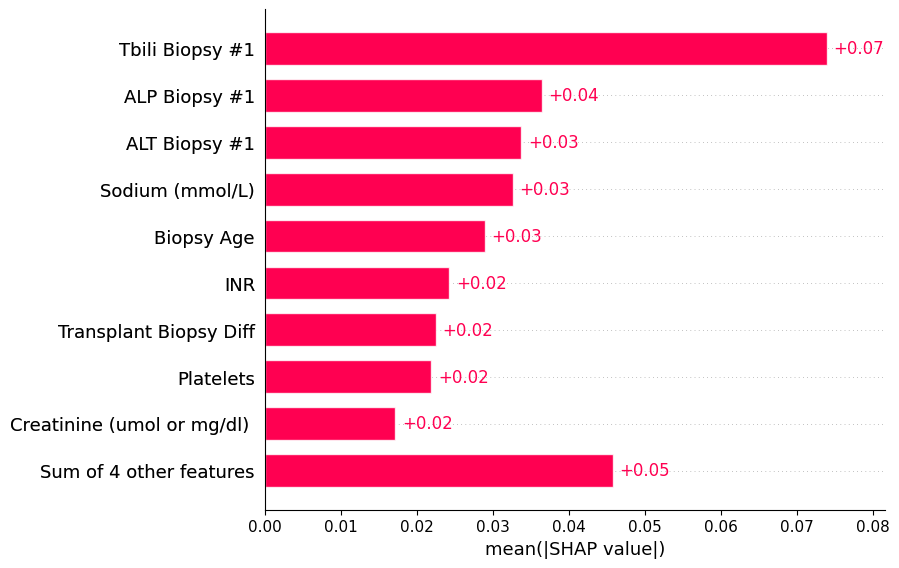

In [85]:
shap.plots.bar(shap_values[:,:,1])

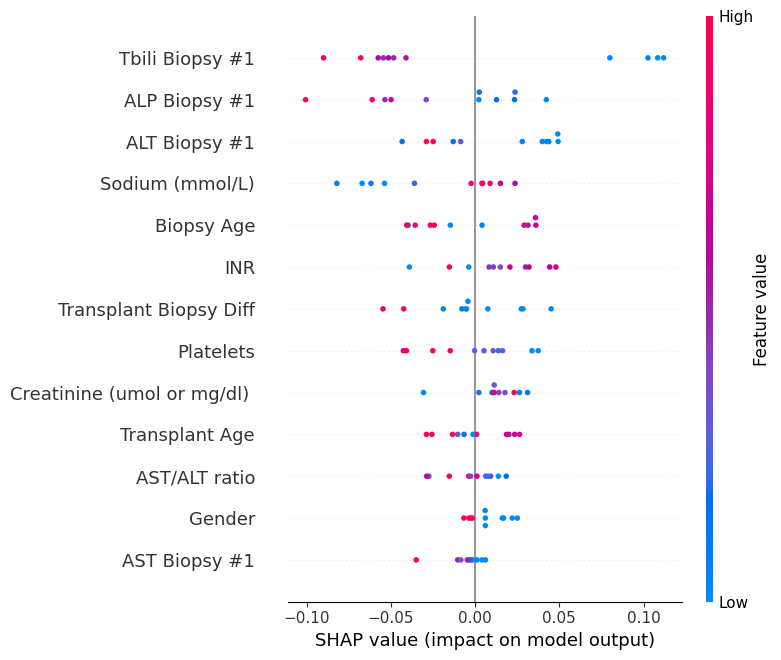

In [79]:
shap_analysis(best_model, X_train, X_test)

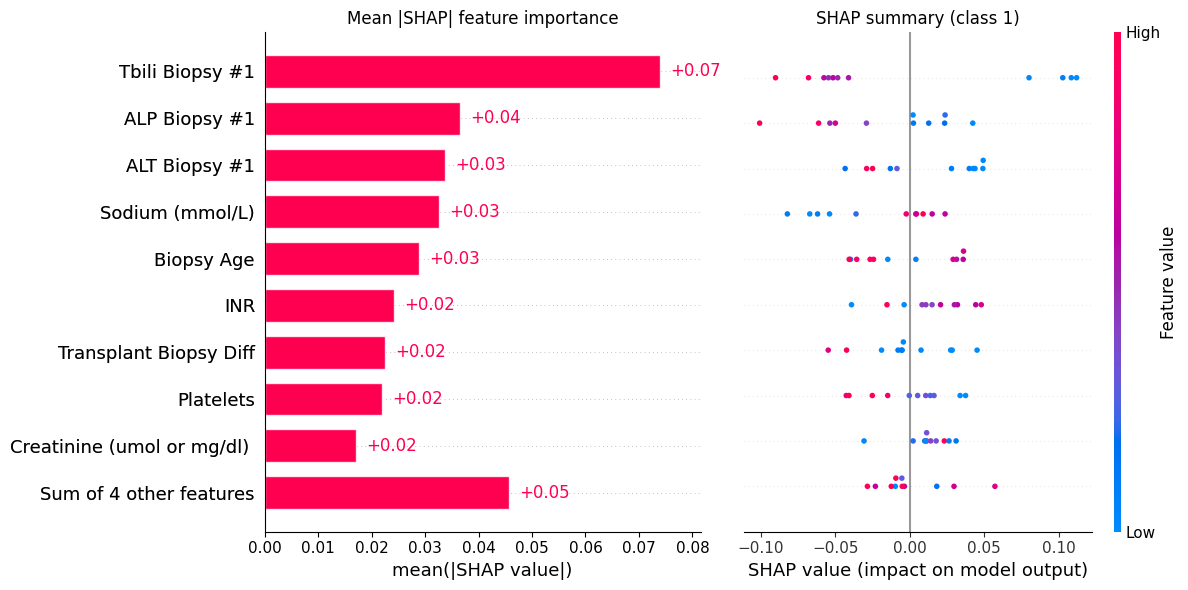

In [118]:
# ------------------------------------------------------------------
# 2.  Two-panel figure
# ------------------------------------------------------------------
fig, axes = plt.subplots(1, 2)      # size doesn't matter yet

# --- (a) Bar plot --------------------------------------------------
plt.sca(axes[0])
shap.plots.bar(sv_class1, show=False)
axes[0].set_title("Mean |SHAP| feature importance")

# --- (b) Bee-swarm plot -------------------------------------------
plt.sca(axes[1])
shap.plots.beeswarm(sv_class1, show=False)
axes[1].set_title("SHAP summary (class 1)")

axes[1].set_yticks([])
axes[1].spines["left"].set_visible(False)

# ── NOW resize the figure ─────────────────────────────────────────
fig = plt.gcf()                     # get current figure
fig.set_size_inches(12, 6)          # 24 in wide × 6 in tall

plt.tight_layout()
plt.savefig("shap_combined.png", dpi=300, bbox_inches="tight")
plt.show()

In [99]:
sv_class1

.values =
array([[ 0.01613574, -0.00856374, -0.00843437, -0.00266312,  0.04227047,
        -0.04102801,  0.0107148 ,  0.0149743 , -0.03601017,  0.03377734,
        -0.01032866, -0.03971888, -0.01889309],
       [ 0.01688564,  0.04926843, -0.00138889,  0.00920964,  0.02340794,
        -0.05754123,  0.01125915,  0.02993878, -0.0670362 , -0.00029272,
        -0.00657164,  0.00411669,  0.02845947],
       [ 0.00597101,  0.042524  , -0.00209003, -0.02744398,  0.00250148,
         0.07999344,  0.01135433,  0.04423428, -0.00234453,  0.03744318,
         0.02000679,  0.02908806, -0.05466305],
       [ 0.02508473,  0.03989603, -0.00475669, -0.00381931,  0.02371212,
        -0.05142339,  0.03110223,  0.02066753, -0.08206111, -0.04258608,
        -0.02889646, -0.04060322, -0.00555467],
       [ 0.02206421, -0.02889904, -0.03494894, -0.02878863, -0.10065014,
        -0.05446977,  0.02634248,  0.0108176 ,  0.00406623,  0.00530851,
         0.01864526,  0.03138294, -0.00427714],
       [ 0.00608366,

In [65]:
explainer = shap.TreeExplainer(best_model)
shap.initjs()
# Calculate SHAP values for test set
shap_values = explainer.shap_values(X_test)

# Force plot for a single prediction (e.g., the first instance in the test set)
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[:,:,0], X_test.columns)

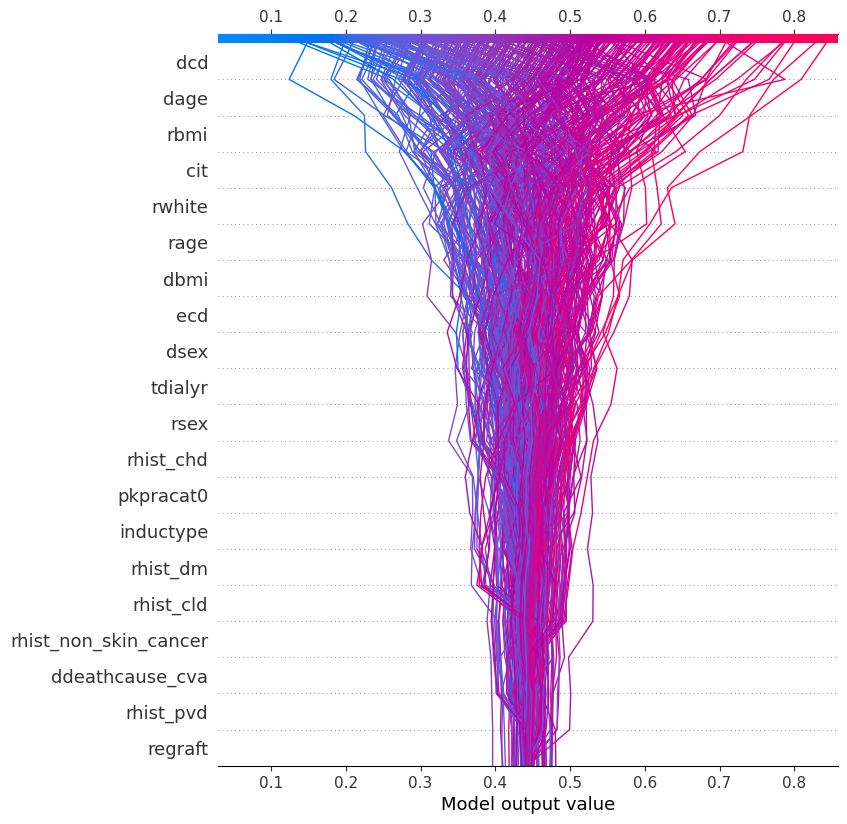

In [136]:
# Force plot for a single prediction (e.g., the first instance in the test set)
shap.initjs()
shap.plots.decision(explainer.expected_value[0], shap_values[:,:,0], X_test)

## GridSearchCV for Support Vector Machine

In [158]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, make_scorer
import pandas as pd
import numpy as np

# Parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'random_state': [32, 100, 777, 2022, 8888]
}

# Custom scorer for specificity
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Custom scorer for weighted specificity
def weighted_specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    specificity = tn / (tn + fp)
    return specificity

# Define scoring dictionary
scoring = {
    'AUC': 'roc_auc',
    'Accuracy': 'accuracy',
    'F1_weighted': make_scorer(f1_score, average='weighted'),
    'Sensitivity': make_scorer(recall_score, pos_label=1),
    'Specificity': make_scorer(specificity_score),
    'Precision': make_scorer(precision_score, pos_label=1, zero_division=0),
    'Recall': make_scorer(recall_score, pos_label=1),
    'Sensitivity_weighted': make_scorer(recall_score, average='weighted'),
    'Specificity_weighted': make_scorer(weighted_specificity_score),
    'Precision_weighted': make_scorer(precision_score, average='weighted', zero_division=0),
    'Recall_weighted': make_scorer(recall_score, average='weighted')
}

def calculate_confidence_interval(data):
    mean = np.mean(data)
    std_err = np.std(data) / np.sqrt(len(data))
    ci = 1.96 * std_err
    return mean, ci

def run_grid_search_svm(X, y):
    # Set up the Support Vector Classifier and GridSearchCV
    svc = SVC(probability=True)
    grid_search = GridSearchCV(estimator=svc, param_grid=param_grid_svm, scoring=scoring, cv=5, n_jobs=-1, return_train_score=True, refit='Accuracy')
    
    # Fit the grid search on the entire dataset
    grid_search.fit(X, y)
    
    # Access all the results
    results = pd.DataFrame(grid_search.cv_results_)
    
    # Sort the models by mean test accuracy score
    results = results.sort_values(by='mean_test_Accuracy', ascending=False)
    
    # Get top N models by mean test accuracy score
    top_models = results
    
    top_models_metrics = []
    
    for i, row in top_models.iterrows():
        params = {key: row['param_' + key] for key in param_grid_svm}
        
        # Collect mean metrics and confidence intervals from cross-validation results
        metrics = {
            'AUC': f"{round(row['mean_test_AUC'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_AUC'] for j in range(5)])[1], 4)}",
            'Accuracy': f"{round(row['mean_test_Accuracy'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Accuracy'] for j in range(5)])[1], 4)}",
            'F1_weighted': f"{round(row['mean_test_F1_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_F1_weighted'] for j in range(5)])[1], 4)}",
            'Sensitivity': f"{round(row['mean_test_Sensitivity'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Sensitivity'] for j in range(5)])[1], 4)}",
            'Specificity': f"{round(row['mean_test_Specificity'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Specificity'] for j in range(5)])[1], 4)}",
            'Precision': f"{round(row['mean_test_Precision'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Precision'] for j in range(5)])[1], 4)}",
            'Recall': f"{round(row['mean_test_Recall'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Recall'] for j in range(5)])[1], 4)}",
            'Sensitivity_weighted': f"{round(row['mean_test_Sensitivity_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Sensitivity_weighted'] for j in range(5)])[1], 4)}",
            'Specificity_weighted': f"{round(row['mean_test_Specificity_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Specificity_weighted'] for j in range(5)])[1], 4)}",
            'Precision_weighted': f"{round(row['mean_test_Precision_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Precision_weighted'] for j in range(5)])[1], 4)}",
            'Recall_weighted': f"{round(row['mean_test_Recall_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Recall_weighted'] for j in range(5)])[1], 4)}",
            'params': params,
        }
        
        top_models_metrics.append(metrics)
    
    return pd.DataFrame(top_models_metrics), grid_search.best_estimator_

In [159]:
all_metrics_dgf_svm, best_model_dgf_svm = run_grid_search_svm(X, y)

In [160]:
best_auc_test = all_metrics_dgf_svm.sort_values(by=['AUC'], ascending=False).reset_index(drop=True)

In [161]:
best_auc_test.sort_values(by=['AUC'], ascending=False).reset_index(drop=True).head(10)

AUC         Accuracy      F1_weighted      Sensitivity  \
0  0.5267 ± 0.1203  0.4364 ± 0.0319  0.3565 ± 0.0555  0.7333 ± 0.2186   
1  0.5267 ± 0.1203  0.4364 ± 0.0319  0.3565 ± 0.0555  0.7333 ± 0.2186   
2  0.5267 ± 0.1203  0.4364 ± 0.0319  0.3565 ± 0.0555  0.7333 ± 0.2186   
3  0.5267 ± 0.1203  0.4364 ± 0.0319  0.3565 ± 0.0555  0.7333 ± 0.2186   
4  0.5267 ± 0.1203  0.4364 ± 0.0319  0.3565 ± 0.0555  0.7333 ± 0.2186   
5  0.5267 ± 0.1203  0.4364 ± 0.0319  0.3565 ± 0.0555  0.7333 ± 0.2186   
6  0.5267 ± 0.1203  0.4364 ± 0.0319  0.3565 ± 0.0555  0.7333 ± 0.2186   
7  0.5267 ± 0.1203  0.4364 ± 0.0319  0.3565 ± 0.0555  0.7333 ± 0.2186   
8  0.5267 ± 0.1203  0.4364 ± 0.0319  0.3565 ± 0.0555  0.7333 ± 0.2186   
9  0.5267 ± 0.1203  0.4364 ± 0.0319  0.3565 ± 0.0555  0.7333 ± 0.2186   

     Specificity        Precision           Recall Sensitivity_weighted  \
0  0.16 ± 0.1312  0.4618 ± 0.0324  0.7333 ± 0.2186      0.4364 ± 0.0319   
1  0.16 ± 0.1312  0.4618 ± 0.0324  0.7333 ± 0.2186      0.4364 ± 0.0319   
2  0.16 ± 0.1312  0.4618 ± 0.0324  0.7333 ± 0.2186      0.4364 ± 0.0319   
3  0.16 ± 0.1312  0.4618 ± 0.0324  0.7333 ± 0.2186      0.4364 ± 0.0319   
4  0.16 ± 0.1312  0.4618 ± 0.0324  0.7333 ± 0.2186      0.4364 ± 0.0319   
5  0.16 ± 0.1312  0.4618 ± 0.0324  0.7333 ± 0.2186      0.4364 ± 0.0319   
6  0.16 ± 0.1312  0.4618 ± 0.0324  0.7333 ± 0.2186      0.4364 ± 0.0319   
7  0.16 ± 0.1312  0.4618 ± 0.0324  0.7333 ± 0.2186      0.4364 ± 0.0319   
8  0.16 ± 0.1312  0.4618 ± 0.0324  0.7333 ± 0.2186      0.4364 ± 0.0319   
9  0.16 ± 0.1312  0.4618 ± 0.0324  0.7333 ± 0.2186      0.4364 ± 0.0319   

  Specificity_weighted Precision_weighted  Recall_weighted  \
0        0.16 ± 0.1312    0.3263 ± 0.0874  0.4364 ± 0.0319   
1        0.16 ± 0.1312    0.3263 ± 0.0874  0.4364 ± 0.0319   
2        0.16 ± 0.1312    0.3263 ± 0.0874  0.4364 ± 0.0319   
3        0.16 ± 0.1312    0.3263 ± 0.0874  0.4364 ± 0.0319   
4        0.16 ± 0.1312    0.3263 ± 0.0874  0.4364 ± 0.0319   
5        0.16 ± 0.1312    0.3263 ± 0.0874  0.4364 ± 0.0319   
6        0.16 ± 0.1312    0.3263 ± 0.0874  0.4364 ± 0.0319   
7        0.16 ± 0.1312    0.3263 ± 0.0874  0.4364 ± 0.0319   
8        0.16 ± 0.1312    0.3263 ± 0.0874  0.4364 ± 0.0319   
9        0.16 ± 0.1312    0.3263 ± 0.0874  0.4364 ± 0.0319   

                                              params  
0  {'C': 0.1, 'kernel': 'rbf', 'gamma': 'auto', '...  
1  {'C': 0.1, 'kernel': 'rbf', 'gamma': 'scale', ...  
2  {'C': 0.1, 'kernel': 'rbf', 'gamma': 'auto', '...  
3  {'C': 0.1, 'kernel': 'rbf', 'gamma': 'scale', ...  
4  {'C': 0.1, 'kernel': 'rbf', 'gamma': 'scale', ...  
5  {'C': 0.1, 'kernel': 'rbf', 'gamma': 'scale', ...  
6  {'C': 0.1, 'kernel': 'rbf', 'gamma': 'scale', ...  
7  {'C': 0.1, 'kernel': 'rbf', 'gamma': 'auto', '...  
8  {'C': 0.1, 'kernel': 'rbf', 'gamma': 'auto', '...  
9  {'C': 0.1, 'kernel': 'rbf', 'gamma': 'auto', '...

In [162]:
all_metrics_dgf_svm.to_csv('all_metrics_svm_clinical_data.csv', index=False)

In [162]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

In [163]:
all_metrics_dgf_svm = all_metrics
best_model_dgf_svm = best_model

In [13]:
best_auc_test.loc[1]['params']

"{'C': 1.0, 'kernel': 'rbf', 'gamma': 'auto', 'random_state': 8888}"

In [14]:
best_model = SVC(**{'C': 1.0, 'kernel': 'rbf', 'gamma': 'auto', 'random_state': 8888}, probability=True)
best_model.fit(X_train, y_train)

SVC(gamma='auto', probability=True, random_state=8888)

In [15]:
explainer = shap.KernelExplainer(best_model.predict_proba, X_train)

Using 1485 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [28]:
#shap_values = explainer.shap_values(X_test)
#shap.force_plot(explainer.expected_value[0], shap_values[..., 0], X_test)


  0%|          | 0/372 [00:00<?, ?it/s]

In [16]:
# Calculate SHAP values
shap_values = explainer(X_test)

  0%|          | 0/372 [00:00<?, ?it/s]

## GridSearchCV for Logistic Regression

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, make_scorer
import pandas as pd
import numpy as np

# Parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100000, 200000, 300000],
    'random_state': [32, 100, 777, 2022, 8888]
}

# Custom scorer for specificity
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Custom scorer for weighted specificity
def weighted_specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    specificity = tn / (tn + fp)
    return specificity

# Define scoring dictionary
scoring = {
    'AUC': 'roc_auc',
    'Accuracy': 'accuracy',
    'F1_weighted': make_scorer(f1_score, average='weighted'),
    'Sensitivity': make_scorer(recall_score, pos_label=1),
    'Specificity': make_scorer(specificity_score),
    'Precision': make_scorer(precision_score, pos_label=1, zero_division=0),
    'Recall': make_scorer(recall_score, pos_label=1),
    'Sensitivity_weighted': make_scorer(recall_score, average='weighted'),
    'Specificity_weighted': make_scorer(weighted_specificity_score),
    'Precision_weighted': make_scorer(precision_score, average='weighted', zero_division=0),
    'Recall_weighted': make_scorer(recall_score, average='weighted')
}

def calculate_confidence_interval(data):
    mean = np.mean(data)
    std_err = np.std(data) / np.sqrt(len(data))
    ci = 1.96 * std_err
    return mean, ci

def run_grid_search_lr(X, y):
    # Set up the Logistic Regression and GridSearchCV
    lr = LogisticRegression()
    grid_search = GridSearchCV(estimator=lr, param_grid=param_grid_lr, scoring=scoring, cv=5, n_jobs=-1, return_train_score=True, refit='Accuracy')
    
    # Fit the grid search on the entire dataset
    grid_search.fit(X, y)
    
    # Access all the results
    results = pd.DataFrame(grid_search.cv_results_)
    
    # Sort the models by mean test accuracy score
    results = results.sort_values(by='mean_test_AUC', ascending=False)
    
    # Get top N models by mean test accuracy score
    top_models = results
    
    top_models_metrics = []
    
    for i, row in top_models.iterrows():
        params = {key: row['param_' + key] for key in param_grid_lr}
        
        # Collect mean metrics and confidence intervals from cross-validation results
        metrics = {
            'AUC': f"{round(row['mean_test_AUC'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_AUC'] for j in range(5)])[1], 4)}",
            'Accuracy': f"{round(row['mean_test_Accuracy'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Accuracy'] for j in range(5)])[1], 4)}",
            'F1_weighted': f"{round(row['mean_test_F1_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_F1_weighted'] for j in range(5)])[1], 4)}",
            'Sensitivity': f"{round(row['mean_test_Sensitivity'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Sensitivity'] for j in range(5)])[1], 4)}",
            'Specificity': f"{round(row['mean_test_Specificity'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Specificity'] for j in range(5)])[1], 4)}",
            'Precision': f"{round(row['mean_test_Precision'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Precision'] for j in range(5)])[1], 4)}",
            'Recall': f"{round(row['mean_test_Recall'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Recall'] for j in range(5)])[1], 4)}",
            'Sensitivity_weighted': f"{round(row['mean_test_Sensitivity_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Sensitivity_weighted'] for j in range(5)])[1], 4)}",
            'Specificity_weighted': f"{round(row['mean_test_Specificity_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Specificity_weighted'] for j in range(5)])[1], 4)}",
            'Precision_weighted': f"{round(row['mean_test_Precision_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Precision_weighted'] for j in range(5)])[1], 4)}",
            'Recall_weighted': f"{round(row['mean_test_Recall_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Recall_weighted'] for j in range(5)])[1], 4)}",
            'params': params,
        }
        
        top_models_metrics.append(metrics)
    
    return pd.DataFrame(top_models_metrics), grid_search.best_estimator_

In [242]:
# from sklearn.metrics import f1_score

# # Example data for binary classification
# y_true = [0, 1, 1, 0, 1, 0, 1, 0, 1, 0]
# y_pred = [0, 1, 0, 0, 1, 0, 1, 1, 0, 0]

# # Calculate F1 score for each class separately
# f1_per_class = f1_score(y_true, y_pred, average=None)

# # Calculate micro-average F1 score
# f1_micro = f1_score(y_true, y_pred, average='micro')

# # Calculate macro-average F1 score
# f1_macro = f1_score(y_true, y_pred, average='macro')

# # Calculate weighted-average F1 score
# f1_weighted = f1_score(y_true, y_pred, average='weighted')

# print("F1 score for each class:", f1_per_class)
# print("Micro-average F1 score:", f1_micro)
# print("Macro-average F1 score:", f1_macro)
# print("Weighted-average F1 score:", f1_weighted)

### Predicting DGF

In [56]:
all_metrics, best_model = run_grid_search_lr(X, y)

In [80]:
best_model

LogisticRegression(C=0.01, max_iter=100000, random_state=32, solver='newton-cg')

In [57]:
best_auc_test = all_metrics

In [58]:
# Set the option to display the entire DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
best_auc_test.head(10)

AUC         Accuracy      F1_weighted      Sensitivity  \
0  0.4267 ± 0.0814  0.4909 ± 0.0813  0.4679 ± 0.0721  0.6533 ± 0.2079   
1  0.4267 ± 0.0814  0.4364 ± 0.0929  0.4121 ± 0.0855  0.5333 ± 0.2194   
2  0.4267 ± 0.0814  0.4364 ± 0.0929   0.422 ± 0.0859  0.4933 ± 0.1915   
3  0.4267 ± 0.0814  0.4364 ± 0.0929  0.4121 ± 0.0855  0.5333 ± 0.2194   
4  0.4267 ± 0.0814  0.4364 ± 0.0929  0.4121 ± 0.0855  0.5333 ± 0.2194   
5  0.4267 ± 0.0814  0.4364 ± 0.0929  0.4121 ± 0.0855  0.5333 ± 0.2194   
6  0.4267 ± 0.0814  0.4364 ± 0.0929  0.4121 ± 0.0855  0.5333 ± 0.2194   
7  0.4267 ± 0.0814  0.4364 ± 0.0929   0.422 ± 0.0859  0.4933 ± 0.1915   
8  0.4267 ± 0.0814  0.4364 ± 0.0929  0.4121 ± 0.0855  0.5333 ± 0.2194   
9  0.4267 ± 0.0814  0.4364 ± 0.0929  0.4121 ± 0.0855  0.5333 ± 0.2194   

       Specificity        Precision           Recall Sensitivity_weighted  \
0    0.34 ± 0.0793  0.4907 ± 0.0682  0.6533 ± 0.2079      0.4909 ± 0.0813   
1  0.3333 ± 0.1579  0.4367 ± 0.1152  0.5333 ± 0.2194      0.4364 ± 0.0929   
2  0.3667 ± 0.1407  0.4335 ± 0.1152  0.4933 ± 0.1915      0.4364 ± 0.0929   
3  0.3333 ± 0.1579  0.4367 ± 0.1152  0.5333 ± 0.2194      0.4364 ± 0.0929   
4  0.3333 ± 0.1579  0.4367 ± 0.1152  0.5333 ± 0.2194      0.4364 ± 0.0929   
5  0.3333 ± 0.1579  0.4367 ± 0.1152  0.5333 ± 0.2194      0.4364 ± 0.0929   
6  0.3333 ± 0.1579  0.4367 ± 0.1152  0.5333 ± 0.2194      0.4364 ± 0.0929   
7  0.3667 ± 0.1407  0.4335 ± 0.1152  0.4933 ± 0.1915      0.4364 ± 0.0929   
8  0.3333 ± 0.1579  0.4367 ± 0.1152  0.5333 ± 0.2194      0.4364 ± 0.0929   
9  0.3333 ± 0.1579  0.4367 ± 0.1152  0.5333 ± 0.2194      0.4364 ± 0.0929   

  Specificity_weighted Precision_weighted  Recall_weighted  \
0        0.34 ± 0.0793    0.5417 ± 0.1279  0.4909 ± 0.0813   
1      0.3333 ± 0.1579    0.4359 ± 0.0952  0.4364 ± 0.0929   
2      0.3667 ± 0.1407    0.4345 ± 0.0948  0.4364 ± 0.0929   
3      0.3333 ± 0.1579    0.4359 ± 0.0952  0.4364 ± 0.0929   
4      0.3333 ± 0.1579    0.4359 ± 0.0952  0.4364 ± 0.0929   
5      0.3333 ± 0.1579    0.4359 ± 0.0952  0.4364 ± 0.0929   
6      0.3333 ± 0.1579    0.4359 ± 0.0952  0.4364 ± 0.0929   
7      0.3667 ± 0.1407    0.4345 ± 0.0948  0.4364 ± 0.0929   
8      0.3333 ± 0.1579    0.4359 ± 0.0952  0.4364 ± 0.0929   
9      0.3333 ± 0.1579    0.4359 ± 0.0952  0.4364 ± 0.0929   

                                              params  
0  {'C': 0.01, 'solver': 'newton-cg', 'max_iter':...  
1  {'C': 0.1, 'solver': 'newton-cg', 'max_iter': ...  
2  {'C': 0.1, 'solver': 'liblinear', 'max_iter': ...  
3  {'C': 0.1, 'solver': 'sag', 'max_iter': 100000...  
4  {'C': 0.1, 'solver': 'saga', 'max_iter': 10000...  
5  {'C': 0.1, 'solver': 'newton-cg', 'max_iter': ...  
6  {'C': 0.1, 'solver': 'lbfgs', 'max_iter': 2000...  
7  {'C': 0.1, 'solver': 'liblinear', 'max_iter': ...  
8  {'C': 0.1, 'solver': 'sag', 'max_iter': 200000...  
9  {'C': 0.1, 'solver': 'saga', 'max_iter': 20000...

In [59]:
best_auc_test.loc[0]['params']

{'C': 0.01, 'solver': 'newton-cg', 'max_iter': 100000, 'random_state': 32}

In [60]:
best_auc_test.loc[1]['params']

{'C': 0.1, 'solver': 'newton-cg', 'max_iter': 100000, 'random_state': 8888}

In [85]:
best_model = LogisticRegression(**best_auc_test.loc[1]['params'])
best_model.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=100000, random_state=8888,
                   solver='newton-cg')

In [61]:
best_auc_test.to_csv('all_metrics_lr_clinical_data.csv', index=False)

In [84]:
# # explain all the predictions in the test set
# explainer = shap.KernelExplainer(best_model.predict_proba, X_train)
# shap_values = explainer.shap_values(X_test)

## Grid Search CV for Gradient Boosting Tree

In [166]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, make_scorer
import pandas as pd
import numpy as np

# Parameter grid for XGBoost
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 4, 5, 6],
    'random_state': [32, 100, 777, 2022, 8888]
}

# Custom scorer for specificity
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Custom scorer for weighted specificity
def weighted_specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    specificity = tn / (tn + fp)
    return specificity

# Define scoring dictionary
scoring = {
    'AUC': 'roc_auc',
    'Accuracy': 'accuracy',
    'F1_weighted': make_scorer(f1_score, average='weighted'),
    'Sensitivity': make_scorer(recall_score, pos_label=1),
    'Specificity': make_scorer(specificity_score),
    'Precision': make_scorer(precision_score, pos_label=1, zero_division=0),
    'Recall': make_scorer(recall_score, pos_label=1),
    'Sensitivity_weighted': make_scorer(recall_score, average='weighted'),
    'Specificity_weighted': make_scorer(weighted_specificity_score),
    'Precision_weighted': make_scorer(precision_score, average='weighted', zero_division=0),
    'Recall_weighted': make_scorer(recall_score, average='weighted')
}

def calculate_confidence_interval(data):
    mean = np.mean(data)
    std_err = np.std(data) / np.sqrt(len(data))
    ci = 1.96 * std_err
    return mean, ci

def run_grid_search_gbc(X, y):
    # Set up the XGBoost Classifier and GridSearchCV
    xgb = XGBClassifier()
    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, scoring=scoring, cv=5, n_jobs=-1, return_train_score=True, refit='Accuracy')
    
    # Fit the grid search on the entire dataset
    grid_search.fit(X, y)
    
    # Access all the results
    results = pd.DataFrame(grid_search.cv_results_)
    
    # Sort the models by mean test accuracy score
    results = results.sort_values(by='mean_test_AUC', ascending=False)
    
    # Get top N models by mean test accuracy score
    top_models = results
    
    top_models_metrics = []
    
    for i, row in top_models.iterrows():
        params = {key: row['param_' + key] for key in param_grid_xgb}
        
        # Collect mean metrics and confidence intervals from cross-validation results
        metrics = {
            'AUC': f"{round(row['mean_test_AUC'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_AUC'] for j in range(5)])[1], 4)}",
            'Accuracy': f"{round(row['mean_test_Accuracy'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Accuracy'] for j in range(5)])[1], 4)}",
            'F1_weighted': f"{round(row['mean_test_F1_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_F1_weighted'] for j in range(5)])[1], 4)}",
            'Sensitivity': f"{round(row['mean_test_Sensitivity'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Sensitivity'] for j in range(5)])[1], 4)}",
            'Specificity': f"{round(row['mean_test_Specificity'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Specificity'] for j in range(5)])[1], 4)}",
            'Precision': f"{round(row['mean_test_Precision'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Precision'] for j in range(5)])[1], 4)}",
            'Recall': f"{round(row['mean_test_Recall'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Recall'] for j in range(5)])[1], 4)}",
            'Sensitivity_weighted': f"{round(row['mean_test_Sensitivity_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Sensitivity_weighted'] for j in range(5)])[1], 4)}",
            'Specificity_weighted': f"{round(row['mean_test_Specificity_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Specificity_weighted'] for j in range(5)])[1], 4)}",
            'Precision_weighted': f"{round(row['mean_test_Precision_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Precision_weighted'] for j in range(5)])[1], 4)}",
            'Recall_weighted': f"{round(row['mean_test_Recall_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Recall_weighted'] for j in range(5)])[1], 4)}",
            'params': params,
        }
        
        top_models_metrics.append(metrics)
    
    return pd.DataFrame(top_models_metrics), grid_search.best_estimator_

## Gradient Boosting Classifier Scikit-Learn (Sklearn)

In [167]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, make_scorer
import pandas as pd
import numpy as np

# Parameter grid for Gradient Boosting Classifier
param_grid_gbc = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 4, 5, 6],
    'random_state': [32, 100, 777, 2022, 8888]
}

# Custom scorer for specificity
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Custom scorer for weighted specificity
def weighted_specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    specificity = tn / (tn + fp)
    return specificity

# Define scoring dictionary
scoring = {
    'AUC': 'roc_auc',
    'Accuracy': 'accuracy',
    'F1_weighted': make_scorer(f1_score, average='weighted'),
    'Sensitivity': make_scorer(recall_score, pos_label=1),
    'Specificity': make_scorer(specificity_score),
    'Precision': make_scorer(precision_score, pos_label=1, zero_division=0),
    'Recall': make_scorer(recall_score, pos_label=1),
    'Sensitivity_weighted': make_scorer(recall_score, average='weighted'),
    'Specificity_weighted': make_scorer(weighted_specificity_score),
    'Precision_weighted': make_scorer(precision_score, average='weighted', zero_division=0),
    'Recall_weighted': make_scorer(recall_score, average='weighted')
}

def calculate_confidence_interval(data):
    mean = np.mean(data)
    std_err = np.std(data) / np.sqrt(len(data))
    ci = 1.96 * std_err
    return mean, ci

def run_grid_search_gbc_sklearn(X, y):
    # Set up the Gradient Boosting Classifier and GridSearchCV
    gbc = GradientBoostingClassifier()
    grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid_gbc, scoring=scoring, cv=5, n_jobs=-1, return_train_score=True, refit='Accuracy')
    
    # Fit the grid search on the entire dataset
    grid_search.fit(X, y)
    
    # Access all the results
    results = pd.DataFrame(grid_search.cv_results_)
    
    # Sort the models by mean test accuracy score
    results = results.sort_values(by='mean_test_Accuracy', ascending=False)
    
    # Get top N models by mean test accuracy score
    top_models = results
    
    top_models_metrics = []
    
    for i, row in top_models.iterrows():
        params = {key: row['param_' + key] for key in param_grid_gbc}
        
        # Collect mean metrics and confidence intervals from cross-validation results
        metrics = {
            'AUC': f"{round(row['mean_test_AUC'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_AUC'] for j in range(5)])[1], 4)}",
            'Accuracy': f"{round(row['mean_test_Accuracy'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Accuracy'] for j in range(5)])[1], 4)}",
            'F1_weighted': f"{round(row['mean_test_F1_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_F1_weighted'] for j in range(5)])[1], 4)}",
            'Sensitivity': f"{round(row['mean_test_Sensitivity'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Sensitivity'] for j in range(5)])[1], 4)}",
            'Specificity': f"{round(row['mean_test_Specificity'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Specificity'] for j in range(5)])[1], 4)}",
            'Precision': f"{round(row['mean_test_Precision'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Precision'] for j in range(5)])[1], 4)}",
            'Recall': f"{round(row['mean_test_Recall'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Recall'] for j in range(5)])[1], 4)}",
            'Sensitivity_weighted': f"{round(row['mean_test_Sensitivity_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Sensitivity_weighted'] for j in range(5)])[1], 4)}",
            'Specificity_weighted': f"{round(row['mean_test_Specificity_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Specificity_weighted'] for j in range(5)])[1], 4)}",
            'Precision_weighted': f"{round(row['mean_test_Precision_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Precision_weighted'] for j in range(5)])[1], 4)}",
            'Recall_weighted': f"{round(row['mean_test_Recall_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Recall_weighted'] for j in range(5)])[1], 4)}",
            'params': params,
        }
        
        top_models_metrics.append(metrics)
    
    return pd.DataFrame(top_models_metrics), grid_search.best_estimator_

## Gradient Boosting Tree Leave One Out

In [168]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, make_scorer
import pandas as pd
import numpy as np

# Parameter grid for Gradient Boosting Classifier
param_grid_gbc = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 4, 5, 6],
    'random_state': [32, 100, 777, 2022, 8888]
}

# Custom scorer for specificity
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Custom scorer for weighted specificity
def weighted_specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    specificity = tn / (tn + fp)
    return specificity

# Define scoring dictionary
scoring = {
    'AUC': 'roc_auc',
    'Accuracy': 'accuracy',
    'F1_weighted': make_scorer(f1_score, average='weighted'),
    'Sensitivity': make_scorer(recall_score, pos_label=1),
    'Specificity': make_scorer(specificity_score),
    'Precision': make_scorer(precision_score, pos_label=1, zero_division=0),
    'Recall': make_scorer(recall_score, pos_label=1),
    'Sensitivity_weighted': make_scorer(recall_score, average='weighted'),
    'Specificity_weighted': make_scorer(weighted_specificity_score),
    'Precision_weighted': make_scorer(precision_score, average='weighted', zero_division=0),
    'Recall_weighted': make_scorer(recall_score, average='weighted')
}

def calculate_confidence_interval(data):
    mean = np.mean(data)
    std_err = np.std(data) / np.sqrt(len(data))
    ci = 1.96 * std_err
    return mean, ci

def run_grid_search_gbc_loo(X, y):
    # Set up the Gradient Boosting Classifier and GridSearchCV
    gbc = GradientBoostingClassifier()
    loo = LeaveOneOut()
    grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid_gbc, scoring=scoring, cv=loo, n_jobs=-1, return_train_score=True, refit='Accuracy')
    
    # Fit the grid search on the entire dataset
    grid_search.fit(X, y)
    
    # Access all the results
    results = pd.DataFrame(grid_search.cv_results_)
    
    # Sort the models by mean test accuracy score
    results = results.sort_values(by='mean_test_Accuracy', ascending=False)
    
    # Get top N models by mean test accuracy score
    top_models = results
    
    top_models_metrics = []
    
    for i, row in top_models.iterrows():
        params = {key: row['param_' + key] for key in param_grid_gbc}
        
        # Collect mean metrics and confidence intervals from cross-validation results
        metrics = {
            'AUC': f"{round(row['mean_test_AUC'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_AUC'] for j in range(len(X))])[1], 4)}",
            'Accuracy': f"{round(row['mean_test_Accuracy'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Accuracy'] for j in range(len(X))])[1], 4)}",
            'F1_weighted': f"{round(row['mean_test_F1_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_F1_weighted'] for j in range(len(X))])[1], 4)}",
            'Sensitivity': f"{round(row['mean_test_Sensitivity'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Sensitivity'] for j in range(len(X))])[1], 4)}",
            'Specificity': f"{round(row['mean_test_Specificity'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Specificity'] for j in range(len(X))])[1], 4)}",
            'Precision': f"{round(row['mean_test_Precision'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Precision'] for j in range(len(X))])[1], 4)}",
            'Recall': f"{round(row['mean_test_Recall'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Recall'] for j in range(len(X))])[1], 4)}",
            'Sensitivity_weighted': f"{round(row['mean_test_Sensitivity_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Sensitivity_weighted'] for j in range(len(X))])[1], 4)}",
            'Specificity_weighted': f"{round(row['mean_test_Specificity_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Specificity_weighted'] for j in range(len(X))])[1], 4)}",
            'Precision_weighted': f"{round(row['mean_test_Precision_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Precision_weighted'] for j in range(len(X))])[1], 4)}",
            'Recall_weighted': f"{round(row['mean_test_Recall_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Recall_weighted'] for j in range(len(X))])[1], 4)}",
            'params': params,
        }
        
        top_models_metrics.append(metrics)
    
    return pd.DataFrame(top_models_metrics), grid_search.best_estimator_

In [321]:
# X_train, X_test, y_train, y_test = train_test_split(X, y_dgf, test_size=0.2, random_state=42)

In [169]:
all_metrics_gbc_dgf, best_model_gbc_dgf = run_grid_search_gbc(X, y)

In [170]:
all_metrics_gbc_dgf_sklearn, best_model_gbc_dgf_sklearn = run_grid_search_gbc_sklearn(X, y)

In [ ]:
# all_metrics_gbc_dgf_loo, best_model_gbc_dgf_loo = run_grid_search_gbc_loo(X, y)

In [ ]:
# y_test.value_counts()

dgf
0    245
1    127
Name: count, dtype: int64

In [171]:
all_metrics_gbc_dgf_sklearn.to_csv('all_metrics_xgb_clinical_data_sklearn.csv', index=False)

In [172]:
all_metrics_gbc_dgf.to_csv('all_metrics_xgb_clinical_data.csv', index=False)

In [173]:
best_auc_test = all_metrics_gbc_dgf_sklearn.sort_values(by=['AUC'], ascending=False).reset_index(drop=True)

In [175]:
best_auc_test.head(10)

AUC         Accuracy      F1_weighted      Sensitivity  \
0    0.55 ± 0.1681  0.5455 ± 0.1746  0.5312 ± 0.1833  0.5933 ± 0.2326   
1    0.54 ± 0.1667  0.5455 ± 0.1746  0.5312 ± 0.1833  0.5933 ± 0.2326   
2  0.5367 ± 0.1759  0.5091 ± 0.1478   0.4906 ± 0.153  0.5533 ± 0.1844   
3  0.5367 ± 0.1759  0.5091 ± 0.1478   0.4906 ± 0.153  0.5533 ± 0.1844   
4  0.5367 ± 0.1759  0.5091 ± 0.1478   0.4906 ± 0.153  0.5533 ± 0.1844   
5  0.5367 ± 0.1739  0.4909 ± 0.1478  0.4752 ± 0.1529  0.5533 ± 0.1844   
6  0.5367 ± 0.1739  0.4909 ± 0.1478  0.4752 ± 0.1529  0.5533 ± 0.1844   
7  0.5367 ± 0.1739  0.4909 ± 0.1478  0.4752 ± 0.1529  0.5533 ± 0.1844   
8    0.53 ± 0.1793  0.4727 ± 0.1625  0.4514 ± 0.1721  0.5533 ± 0.1844   
9    0.53 ± 0.1793  0.4727 ± 0.1625  0.4514 ± 0.1721  0.5533 ± 0.1844   

       Specificity        Precision           Recall Sensitivity_weighted  \
0  0.5067 ± 0.2419     0.56 ± 0.126  0.5933 ± 0.2326      0.5455 ± 0.1746   
1  0.5067 ± 0.2419     0.56 ± 0.126  0.5933 ± 0.2326      0.5455 ± 0.1746   
2    0.48 ± 0.2511  0.5479 ± 0.1383  0.5533 ± 0.1844      0.5091 ± 0.1478   
3    0.48 ± 0.2511  0.5479 ± 0.1383  0.5533 ± 0.1844      0.5091 ± 0.1478   
4    0.48 ± 0.2511  0.5479 ± 0.1383  0.5533 ± 0.1844      0.5091 ± 0.1478   
5    0.44 ± 0.2197  0.5146 ± 0.1283  0.5533 ± 0.1844      0.4909 ± 0.1478   
6    0.44 ± 0.2197  0.5146 ± 0.1283  0.5533 ± 0.1844      0.4909 ± 0.1478   
7    0.44 ± 0.2197  0.5146 ± 0.1283  0.5533 ± 0.1844      0.4909 ± 0.1478   
8     0.4 ± 0.2607   0.5039 ± 0.135  0.5533 ± 0.1844      0.4727 ± 0.1625   
9     0.4 ± 0.2607   0.5039 ± 0.135  0.5533 ± 0.1844      0.4727 ± 0.1625   

  Specificity_weighted Precision_weighted  Recall_weighted  \
0      0.5067 ± 0.2419    0.5575 ± 0.2084  0.5455 ± 0.1746   
1      0.5067 ± 0.2419    0.5575 ± 0.2084  0.5455 ± 0.1746   
2        0.48 ± 0.2511     0.5202 ± 0.151  0.5091 ± 0.1478   
3        0.48 ± 0.2511     0.5202 ± 0.151  0.5091 ± 0.1478   
4        0.48 ± 0.2511     0.5202 ± 0.151  0.5091 ± 0.1478   
5        0.44 ± 0.2197    0.4955 ± 0.1483  0.4909 ± 0.1478   
6        0.44 ± 0.2197    0.4955 ± 0.1483  0.4909 ± 0.1478   
7        0.44 ± 0.2197    0.4955 ± 0.1483  0.4909 ± 0.1478   
8         0.4 ± 0.2607    0.4669 ± 0.1761  0.4727 ± 0.1625   
9         0.4 ± 0.2607    0.4669 ± 0.1761  0.4727 ± 0.1625   

                                              params  
0  {'learning_rate': 0.3, 'n_estimators': 50, 'ma...  
1  {'learning_rate': 0.3, 'n_estimators': 50, 'ma...  
2  {'learning_rate': 0.2, 'n_estimators': 150, 'm...  
3  {'learning_rate': 0.2, 'n_estimators': 100, 'm...  
4  {'learning_rate': 0.2, 'n_estimators': 200, 'm...  
5  {'learning_rate': 0.2, 'n_estimators': 100, 'm...  
6  {'learning_rate': 0.2, 'n_estimators': 200, 'm...  
7  {'learning_rate': 0.2, 'n_estimators': 150, 'm...  
8  {'learning_rate': 0.2, 'n_estimators': 150, 'm...  
9  {'learning_rate': 0.2, 'n_estimators': 100, 'm...

In [376]:
best_auc_test = all_metrics_gbc_dgf.sort_values(by=['AUC'], ascending=False).reset_index(drop=True)

In [378]:
all_metrics_gbc_dgf.to_csv('all_metrics_xgb_clinical_data.csv', index=False)

In [389]:
best_auc_test.loc[1]['params']

{'learning_rate': 0.1,
 'n_estimators': 150,
 'max_depth': 4,
 'random_state': 2022}

In [390]:
best_model = GradientBoostingClassifier(**{'learning_rate': 0.1, 'n_estimators': 150, 'max_depth': 4, 'random_state': 2022})
best_model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=4, n_estimators=150, random_state=2022)

In [391]:
best_auc_test.loc[0]['params']

{'learning_rate': 0.1, 'n_estimators': 150, 'max_depth': 4, 'random_state': 32}

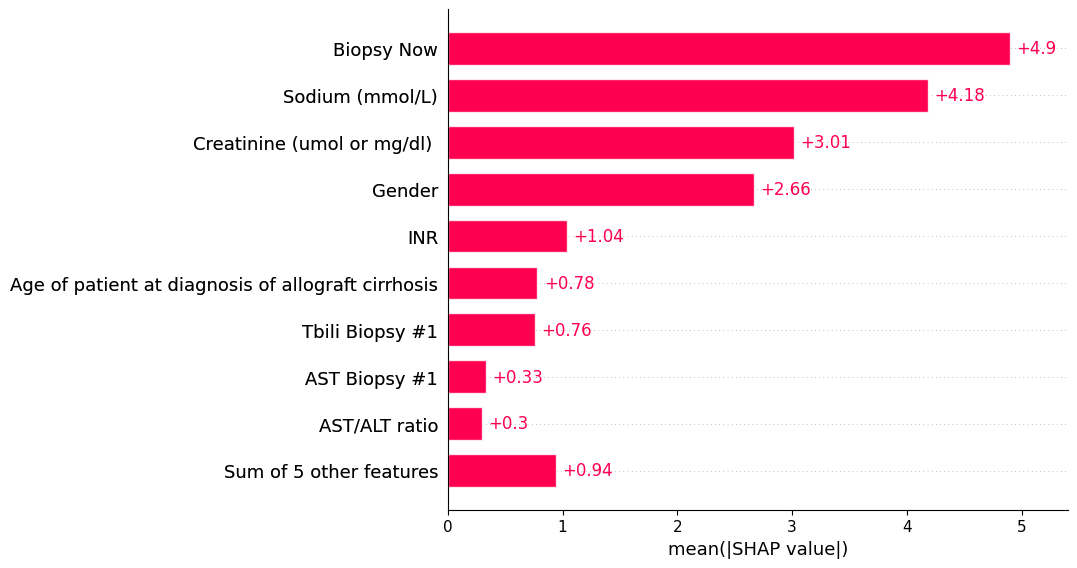

In [392]:
# Create SHAP explainer
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values
shap_values = explainer(X_test)
shap.plots.bar(shap_values)

In [393]:
# Create SHAP explainer
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[11])

IndexError: index 11 is out of bounds for axis 0 with size 11

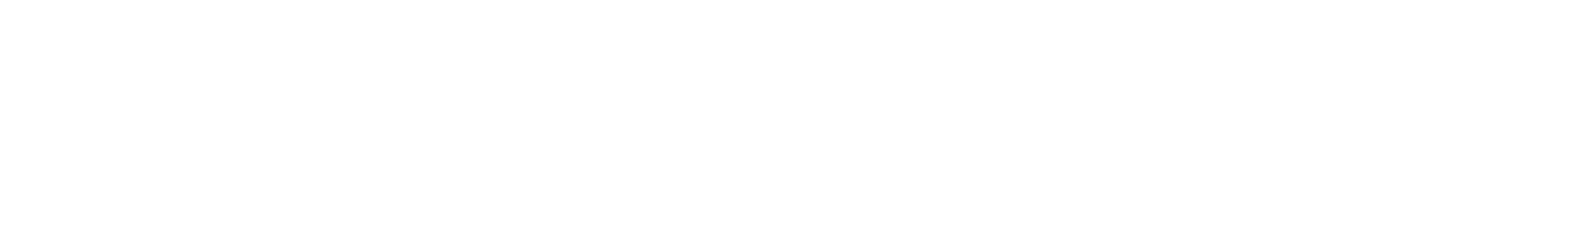

In [394]:
# Create SHAP explainer
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values
shap_values = explainer(X_test)
# Create SHAP explainer
explainer = shap.TreeExplainer(best_model)
expected_value = explainer.expected_value

shap.force_plot(
    expected_value,
    shap_values.values[0],
    X_test.iloc[0],
    link="logit",
    matplotlib=True,
)

In [395]:
# Create SHAP explainer
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values
shap_values = explainer(X_test)
shap.plots.bar(shap_values[11])

IndexError: index 11 is out of bounds for axis 0 with size 11

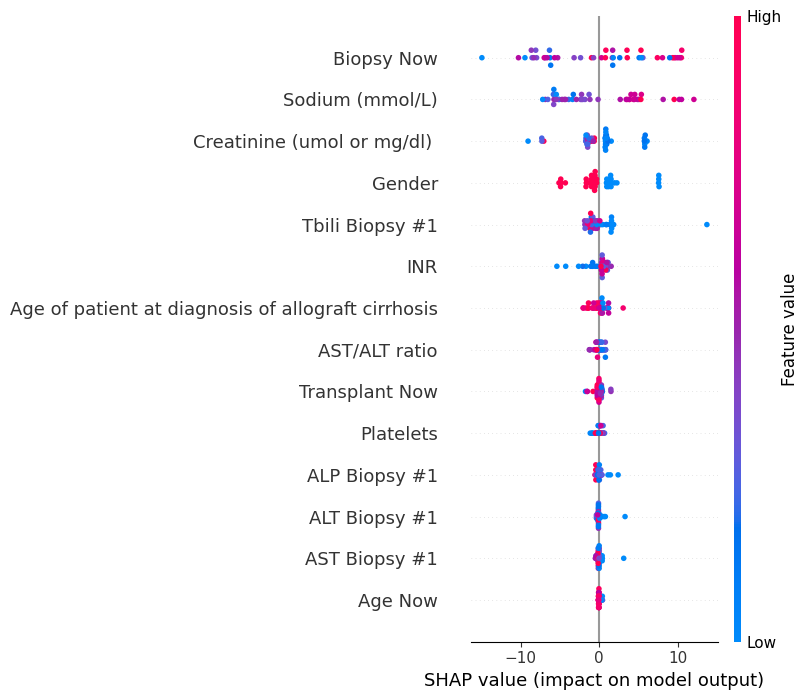

In [396]:
# Create SHAP explainer
explainer = shap.TreeExplainer(best_model, X_train)
shap_values = explainer(X_train)

# Summary force plot
shap.summary_plot(shap_values, X_train)


In [56]:
# best_auc_test.to_csv('predict_dgf_result_gradient_boosting_classifier.csv', index=False)

In [379]:
#X_train, X_test, y_train, y_test = train_test_split(X, y_dgf, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2)

In [386]:
best_model = RandomForestClassifier(**{'random_state': 32, 'criterion': 'gini', 'n_estimators': 8, 'max_depth': 8})
best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, n_estimators=8, random_state=32)

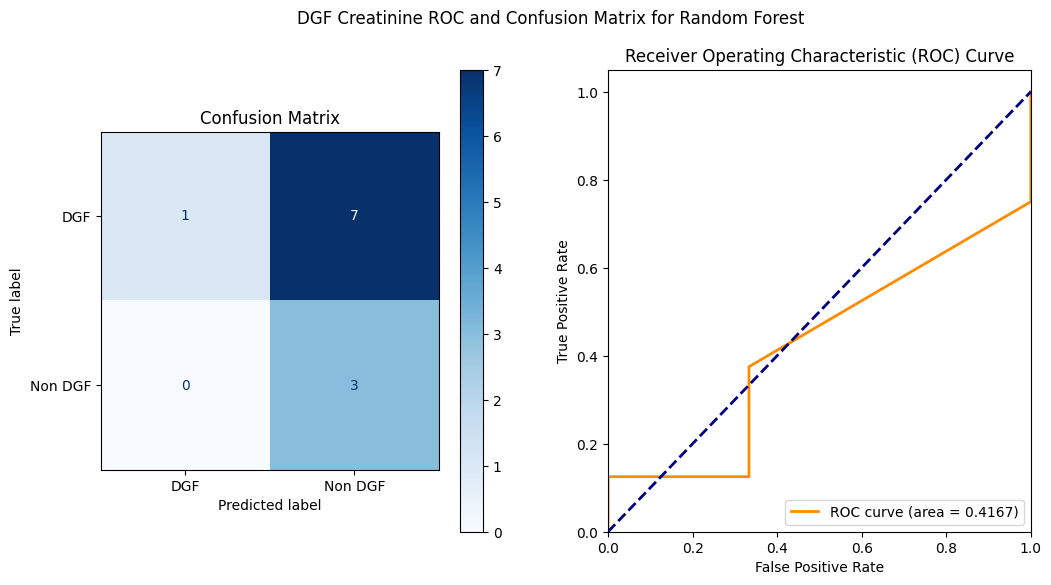

In [387]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier

# Predictions
y_pred = best_model.predict(X_test)

# Check if the model supports predict_proba
if hasattr(best_model, "predict_proba"):
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
else:
    # If predict_proba is not available, use decision_function and scale it to [0, 1]
    y_pred_proba = best_model.decision_function(X_test)
    y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())

# Map labels
label_mapping = {0: 'Non DGF', 1: 'DGF'}
y_test_mapped = [label_mapping[label] for label in y_test]
y_pred_mapped = [label_mapping[label] for label in y_pred]

# Plot confusion matrix
cm = confusion_matrix(y_test_mapped, y_pred_mapped, labels=['DGF', 'Non DGF'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['DGF', 'Non DGF'])

# Plot ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Create a figure with two subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot confusion matrix on the first subplot
disp.plot(cmap=plt.cm.Blues, ax=ax[0])
ax[0].set_title('Confusion Matrix')

# Plot ROC curve on the second subplot
ax[1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic (ROC) Curve')
ax[1].legend(loc="lower right")

# Set the main title for the figure
fig.suptitle('DGF Creatinine ROC and Confusion Matrix for Random Forest')

# Show the plot
plt.show()

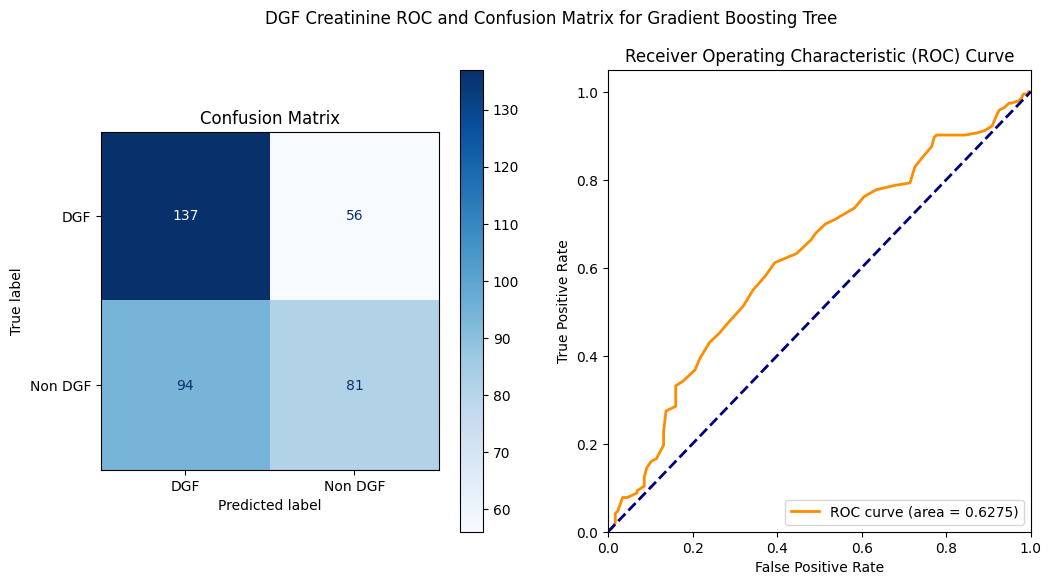

In [346]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier

# Predictions
y_pred = best_model.predict(X_test)

# Check if the model supports predict_proba
if hasattr(best_model, "predict_proba"):
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
else:
    # If predict_proba is not available, use decision_function and scale it to [0, 1]
    y_pred_proba = best_model.decision_function(X_test)
    y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())

# Map labels
label_mapping = {0: 'Non DGF', 1: 'DGF'}
y_test_mapped = [label_mapping[label] for label in y_test]
y_pred_mapped = [label_mapping[label] for label in y_pred]

# Plot confusion matrix
cm = confusion_matrix(y_test_mapped, y_pred_mapped, labels=['DGF', 'Non DGF'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['DGF', 'Non DGF'])

# Plot ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Create a figure with two subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot confusion matrix on the first subplot
disp.plot(cmap=plt.cm.Blues, ax=ax[0])
ax[0].set_title('Confusion Matrix')

# Plot ROC curve on the second subplot
ax[1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = 0.6275)' % roc_auc)
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic (ROC) Curve')
ax[1].legend(loc="lower right")

# Set the main title for the figure
fig.suptitle('DGF Creatinine ROC and Confusion Matrix for Gradient Boosting Tree')

# Show the plot
plt.show()

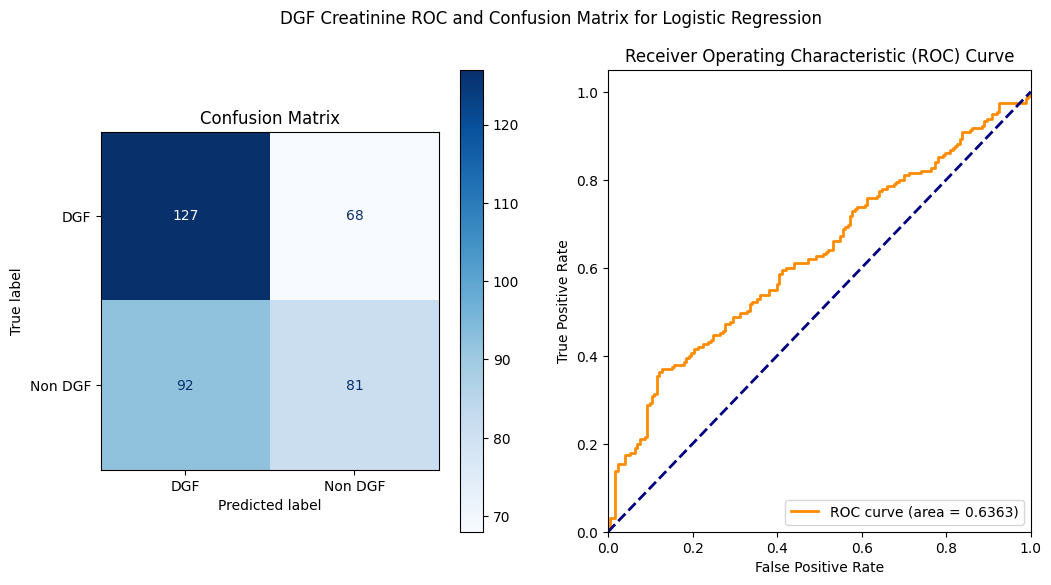

In [304]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier

# Predictions
y_pred = best_model.predict(X_test)

# Check if the model supports predict_proba
if hasattr(best_model, "predict_proba"):
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
else:
    # If predict_proba is not available, use decision_function and scale it to [0, 1]
    y_pred_proba = best_model.decision_function(X_test)
    y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())

# Map labels
label_mapping = {0: 'Non DGF', 1: 'DGF'}
y_test_mapped = [label_mapping[label] for label in y_test]
y_pred_mapped = [label_mapping[label] for label in y_pred]

# Plot confusion matrix
cm = confusion_matrix(y_test_mapped, y_pred_mapped, labels=['DGF', 'Non DGF'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['DGF', 'Non DGF'])

# Plot ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Create a figure with two subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot confusion matrix on the first subplot
disp.plot(cmap=plt.cm.Blues, ax=ax[0])
ax[0].set_title('Confusion Matrix')

# Plot ROC curve on the second subplot
ax[1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = 0.6363)' % roc_auc)
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic (ROC) Curve')
ax[1].legend(loc="lower right")

# Set the main title for the figure
fig.suptitle('DGF Creatinine ROC and Confusion Matrix for Logistic Regression')

# Show the plot
plt.show()

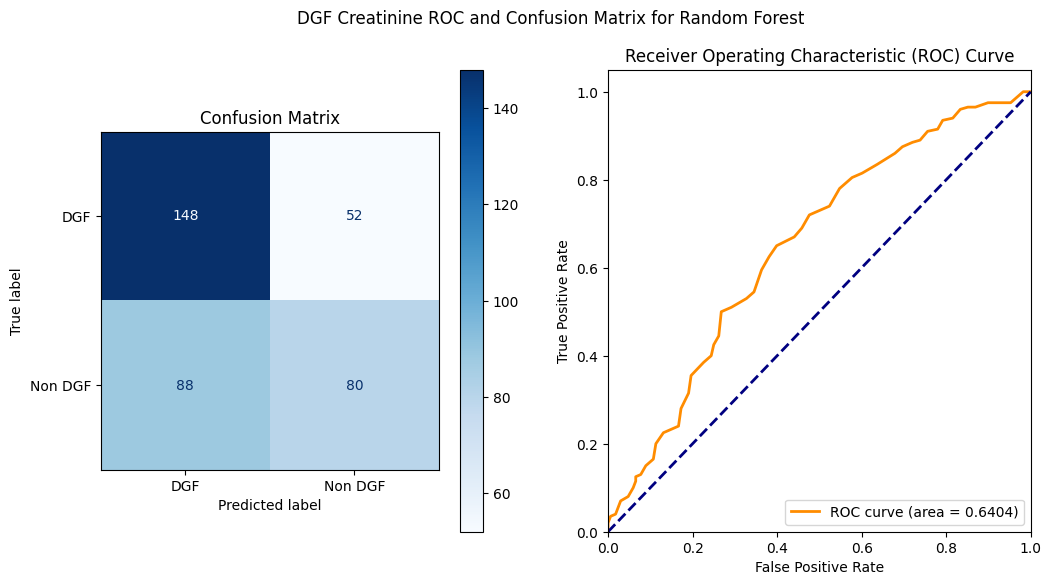

In [259]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier

# Predictions
y_pred = best_model.predict(X_test)

# Check if the model supports predict_proba
if hasattr(best_model, "predict_proba"):
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
else:
    # If predict_proba is not available, use decision_function and scale it to [0, 1]
    y_pred_proba = best_model.decision_function(X_test)
    y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())

# Map labels
label_mapping = {0: 'Non DGF', 1: 'DGF'}
y_test_mapped = [label_mapping[label] for label in y_test]
y_pred_mapped = [label_mapping[label] for label in y_pred]

# Plot confusion matrix
cm = confusion_matrix(y_test_mapped, y_pred_mapped, labels=['DGF', 'Non DGF'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['DGF', 'Non DGF'])

# Plot ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Create a figure with two subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot confusion matrix on the first subplot
disp.plot(cmap=plt.cm.Blues, ax=ax[0])
ax[0].set_title('Confusion Matrix')

# Plot ROC curve on the second subplot
ax[1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = 0.6404)' % roc_auc)
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic (ROC) Curve')
ax[1].legend(loc="lower right")

# Set the main title for the figure
fig.suptitle('DGF Creatinine ROC and Confusion Matrix for Random Forest')

# Show the plot
plt.show()

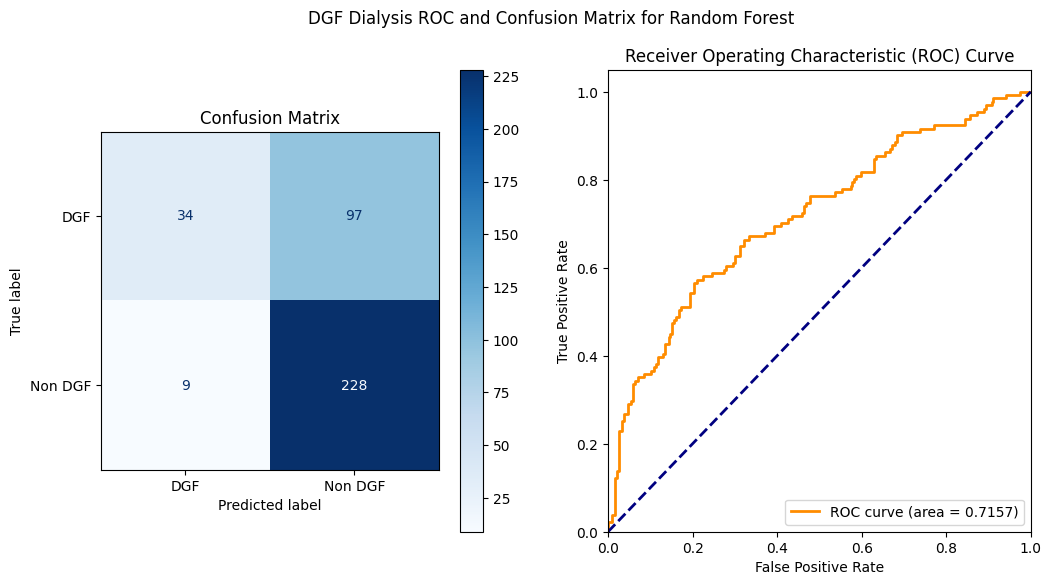

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier

# Predictions
y_pred = best_model.predict(X_test)

# Check if the model supports predict_proba
if hasattr(best_model, "predict_proba"):
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
else:
    # If predict_proba is not available, use decision_function and scale it to [0, 1]
    y_pred_proba = best_model.decision_function(X_test)
    y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())

# Map labels
label_mapping = {0: 'Non DGF', 1: 'DGF'}
y_test_mapped = [label_mapping[label] for label in y_test]
y_pred_mapped = [label_mapping[label] for label in y_pred]

# Plot confusion matrix
cm = confusion_matrix(y_test_mapped, y_pred_mapped, labels=['DGF', 'Non DGF'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['DGF', 'Non DGF'])

# Plot ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Create a figure with two subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot confusion matrix on the first subplot
disp.plot(cmap=plt.cm.Blues, ax=ax[0])
ax[0].set_title('Confusion Matrix')

# Plot ROC curve on the second subplot
ax[1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic (ROC) Curve')
ax[1].legend(loc="lower right")

# Set the main title for the figure
fig.suptitle('DGF Dialysis ROC and Confusion Matrix for Random Forest')

# Show the plot
plt.show()

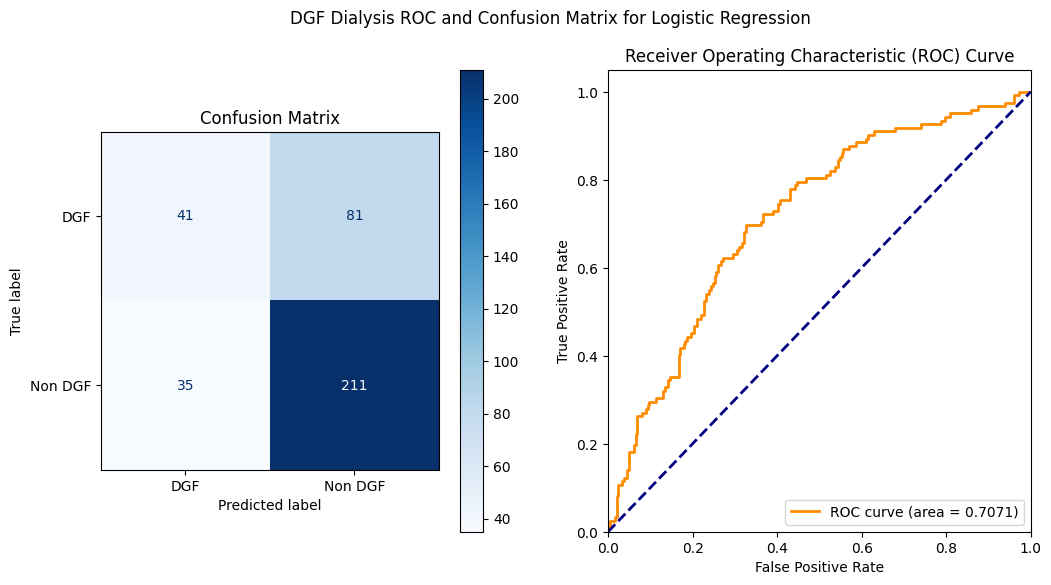

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier

# Predictions
y_pred = best_model.predict(X_test)

# Check if the model supports predict_proba
if hasattr(best_model, "predict_proba"):
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
else:
    # If predict_proba is not available, use decision_function and scale it to [0, 1]
    y_pred_proba = best_model.decision_function(X_test)
    y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())

# Map labels
label_mapping = {0: 'Non DGF', 1: 'DGF'}
y_test_mapped = [label_mapping[label] for label in y_test]
y_pred_mapped = [label_mapping[label] for label in y_pred]

# Plot confusion matrix
cm = confusion_matrix(y_test_mapped, y_pred_mapped, labels=['DGF', 'Non DGF'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['DGF', 'Non DGF'])

# Plot ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Create a figure with two subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot confusion matrix on the first subplot
disp.plot(cmap=plt.cm.Blues, ax=ax[0])
ax[0].set_title('Confusion Matrix')

# Plot ROC curve on the second subplot
ax[1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = 0.7071)' % roc_auc)
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic (ROC) Curve')
ax[1].legend(loc="lower right")

# Set the main title for the figure
fig.suptitle('DGF Dialysis ROC and Confusion Matrix for Logistic Regression')

# Show the plot
plt.show()

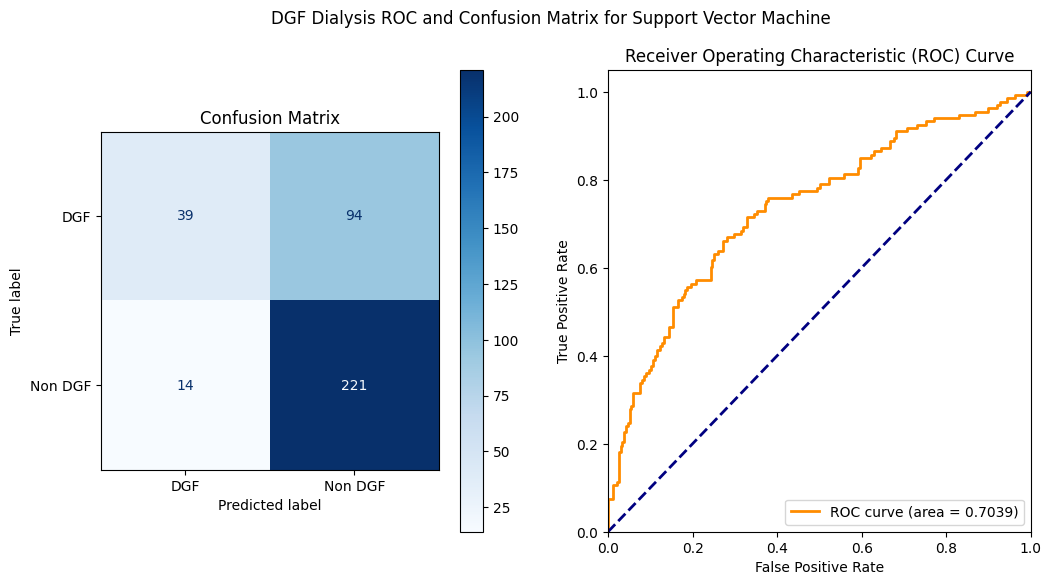

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier

# Predictions
y_pred = best_model.predict(X_test)

# Check if the model supports predict_proba
if hasattr(best_model, "predict_proba"):
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
else:
    # If predict_proba is not available, use decision_function and scale it to [0, 1]
    y_pred_proba = best_model.decision_function(X_test)
    y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())

# Map labels
label_mapping = {0: 'Non DGF', 1: 'DGF'}
y_test_mapped = [label_mapping[label] for label in y_test]
y_pred_mapped = [label_mapping[label] for label in y_pred]

# Plot confusion matrix
cm = confusion_matrix(y_test_mapped, y_pred_mapped, labels=['DGF', 'Non DGF'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['DGF', 'Non DGF'])

# Plot ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Create a figure with two subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot confusion matrix on the first subplot
disp.plot(cmap=plt.cm.Blues, ax=ax[0])
ax[0].set_title('Confusion Matrix')

# Plot ROC curve on the second subplot
ax[1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = 0.7039)')
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic (ROC) Curve')
ax[1].legend(loc="lower right")

# Set the main title for the figure
fig.suptitle('DGF Dialysis ROC and Confusion Matrix for Support Vector Machine')

# Show the plot
plt.show()

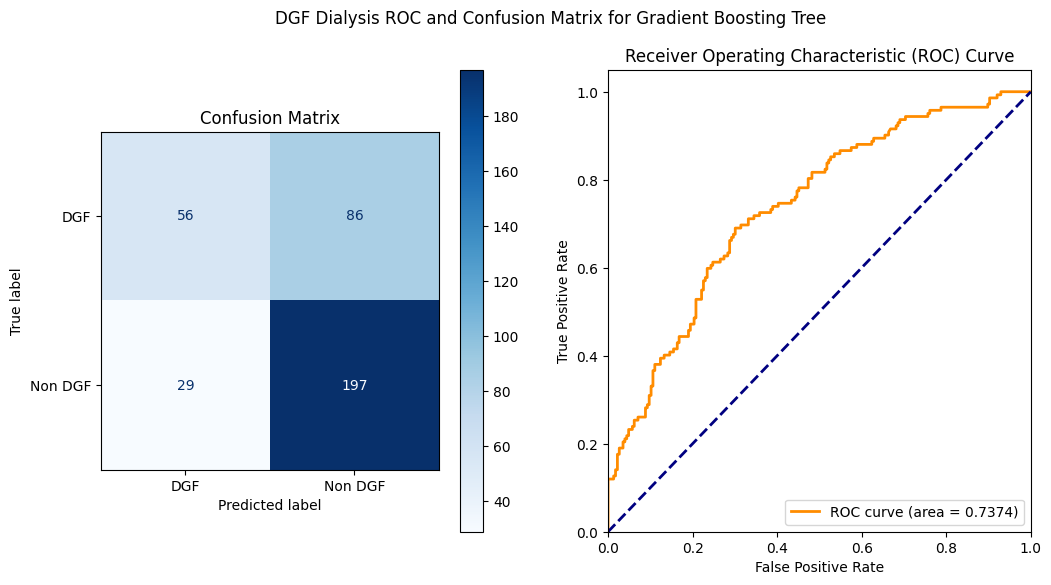

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier

# Assuming best_model, X_test, and y_test are already defined

# Predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Map labels
label_mapping = {0: 'Non DGF', 1: 'DGF'}
y_test_mapped = [label_mapping[label] for label in y_test]
y_pred_mapped = [label_mapping[label] for label in y_pred]

# Plot confusion matrix
cm = confusion_matrix(y_test_mapped, y_pred_mapped, labels=['DGF', 'Non DGF'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['DGF', 'Non DGF'])

# Plot ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Create a figure with two subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot confusion matrix on the first subplot
disp.plot(cmap=plt.cm.Blues, ax=ax[0])
ax[0].set_title('Confusion Matrix')

# Plot ROC curve on the second subplot
ax[1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic (ROC) Curve')
ax[1].legend(loc="lower right")

# Set the main title for the figure
fig.suptitle('DGF Dialysis ROC and Confusion Matrix for Gradient Boosting Tree')

# Show the plot
plt.show()

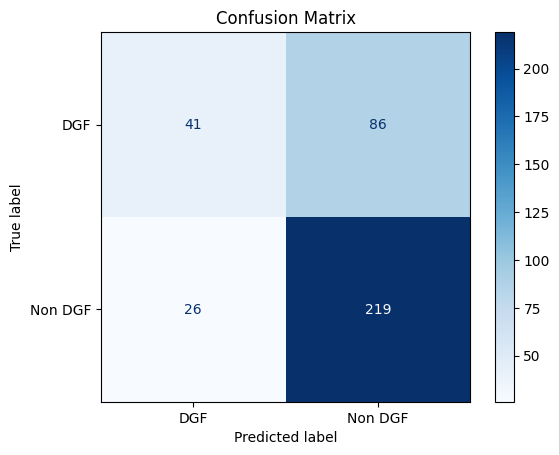

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
# Predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Map labels
label_mapping = {0: 'Non DGF', 1: 'DGF'}
y_test_mapped = [label_mapping[label] for label in y_test]
y_pred_mapped = [label_mapping[label] for label in y_pred]

# Plot confusion matrix
cm = confusion_matrix(y_test_mapped, y_pred_mapped, labels=['DGF', 'Non DGF'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['DGF', 'Non DGF'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


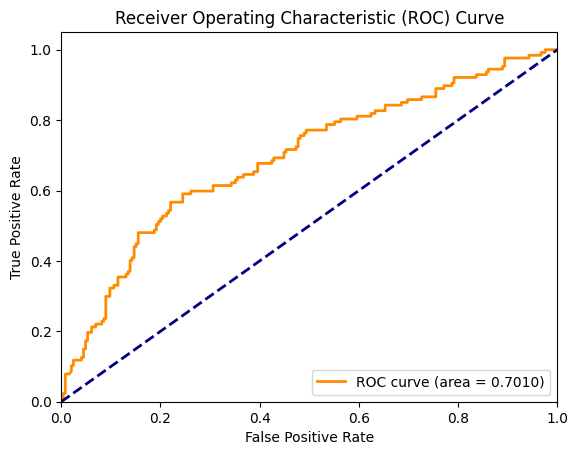

In [132]:
# Plot ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = 0.7010)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [119]:
print("ROC AUC: %0.4f" % roc_auc)

ROC AUC: 0.7057


## Predicting Crr2 using Gradient Boosting Tree

In [69]:
all_metrics, best_model = run_grid_search_gbc(X, y_crr2_lt30)

In [104]:
all_metrics_gbc_crr_sklearn, best_model_gbc_crr_sklearn = run_grid_search_gbc_sklearn(X, y_crr2_lt30)

In [70]:
# X_train, X_test, y_train, y_test = train_test_split(X, y_crr2_lt30, test_size=0.2, random_state=42)

In [105]:
all_metrics_gbc_crr_sklearn.to_csv('all_metrics_xgb_dgf_creatinine_sklearn.csv', index=False)

In [120]:
best_auc_test = all_metrics_gbc_crr_sklearn.sort_values(by=['AUC'], ascending=False).reset_index(drop=True)

In [176]:
best_auc_test.head(10)

AUC         Accuracy      F1_weighted      Sensitivity  \
0    0.55 ± 0.1681  0.5455 ± 0.1746  0.5312 ± 0.1833  0.5933 ± 0.2326   
1    0.54 ± 0.1667  0.5455 ± 0.1746  0.5312 ± 0.1833  0.5933 ± 0.2326   
2  0.5367 ± 0.1759  0.5091 ± 0.1478   0.4906 ± 0.153  0.5533 ± 0.1844   
3  0.5367 ± 0.1759  0.5091 ± 0.1478   0.4906 ± 0.153  0.5533 ± 0.1844   
4  0.5367 ± 0.1759  0.5091 ± 0.1478   0.4906 ± 0.153  0.5533 ± 0.1844   
5  0.5367 ± 0.1739  0.4909 ± 0.1478  0.4752 ± 0.1529  0.5533 ± 0.1844   
6  0.5367 ± 0.1739  0.4909 ± 0.1478  0.4752 ± 0.1529  0.5533 ± 0.1844   
7  0.5367 ± 0.1739  0.4909 ± 0.1478  0.4752 ± 0.1529  0.5533 ± 0.1844   
8    0.53 ± 0.1793  0.4727 ± 0.1625  0.4514 ± 0.1721  0.5533 ± 0.1844   
9    0.53 ± 0.1793  0.4727 ± 0.1625  0.4514 ± 0.1721  0.5533 ± 0.1844   

       Specificity        Precision           Recall Sensitivity_weighted  \
0  0.5067 ± 0.2419     0.56 ± 0.126  0.5933 ± 0.2326      0.5455 ± 0.1746   
1  0.5067 ± 0.2419     0.56 ± 0.126  0.5933 ± 0.2326      0.5455 ± 0.1746   
2    0.48 ± 0.2511  0.5479 ± 0.1383  0.5533 ± 0.1844      0.5091 ± 0.1478   
3    0.48 ± 0.2511  0.5479 ± 0.1383  0.5533 ± 0.1844      0.5091 ± 0.1478   
4    0.48 ± 0.2511  0.5479 ± 0.1383  0.5533 ± 0.1844      0.5091 ± 0.1478   
5    0.44 ± 0.2197  0.5146 ± 0.1283  0.5533 ± 0.1844      0.4909 ± 0.1478   
6    0.44 ± 0.2197  0.5146 ± 0.1283  0.5533 ± 0.1844      0.4909 ± 0.1478   
7    0.44 ± 0.2197  0.5146 ± 0.1283  0.5533 ± 0.1844      0.4909 ± 0.1478   
8     0.4 ± 0.2607   0.5039 ± 0.135  0.5533 ± 0.1844      0.4727 ± 0.1625   
9     0.4 ± 0.2607   0.5039 ± 0.135  0.5533 ± 0.1844      0.4727 ± 0.1625   

  Specificity_weighted Precision_weighted  Recall_weighted  \
0      0.5067 ± 0.2419    0.5575 ± 0.2084  0.5455 ± 0.1746   
1      0.5067 ± 0.2419    0.5575 ± 0.2084  0.5455 ± 0.1746   
2        0.48 ± 0.2511     0.5202 ± 0.151  0.5091 ± 0.1478   
3        0.48 ± 0.2511     0.5202 ± 0.151  0.5091 ± 0.1478   
4        0.48 ± 0.2511     0.5202 ± 0.151  0.5091 ± 0.1478   
5        0.44 ± 0.2197    0.4955 ± 0.1483  0.4909 ± 0.1478   
6        0.44 ± 0.2197    0.4955 ± 0.1483  0.4909 ± 0.1478   
7        0.44 ± 0.2197    0.4955 ± 0.1483  0.4909 ± 0.1478   
8         0.4 ± 0.2607    0.4669 ± 0.1761  0.4727 ± 0.1625   
9         0.4 ± 0.2607    0.4669 ± 0.1761  0.4727 ± 0.1625   

                                              params  
0  {'learning_rate': 0.3, 'n_estimators': 50, 'ma...  
1  {'learning_rate': 0.3, 'n_estimators': 50, 'ma...  
2  {'learning_rate': 0.2, 'n_estimators': 150, 'm...  
3  {'learning_rate': 0.2, 'n_estimators': 100, 'm...  
4  {'learning_rate': 0.2, 'n_estimators': 200, 'm...  
5  {'learning_rate': 0.2, 'n_estimators': 100, 'm...  
6  {'learning_rate': 0.2, 'n_estimators': 200, 'm...  
7  {'learning_rate': 0.2, 'n_estimators': 150, 'm...  
8  {'learning_rate': 0.2, 'n_estimators': 150, 'm...  
9  {'learning_rate': 0.2, 'n_estimators': 100, 'm...

In [54]:
best_model = GradientBoostingClassifier(**{'learning_rate': 0.01, 'n_estimators': 200, 'max_depth': 3, 'random_state': 32})
best_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=200,
                           random_state=32)

In [49]:
y_train.value_counts()

crr2_lt30
1.0    820
0.0    665
Name: count, dtype: int64

In [50]:
y_test.value_counts()

crr2_lt30
1.0    202
0.0    170
Name: count, dtype: int64

In [170]:
best_auc_test.loc[3]['params']

"{'learning_rate': 0.01, 'n_estimators': 200, 'max_depth': 3, 'random_state': 32}"

In [62]:
best_auc_test.to_csv('predict_crr2_lt_30_result_gradient_boosting_classifier.csv', index=False)

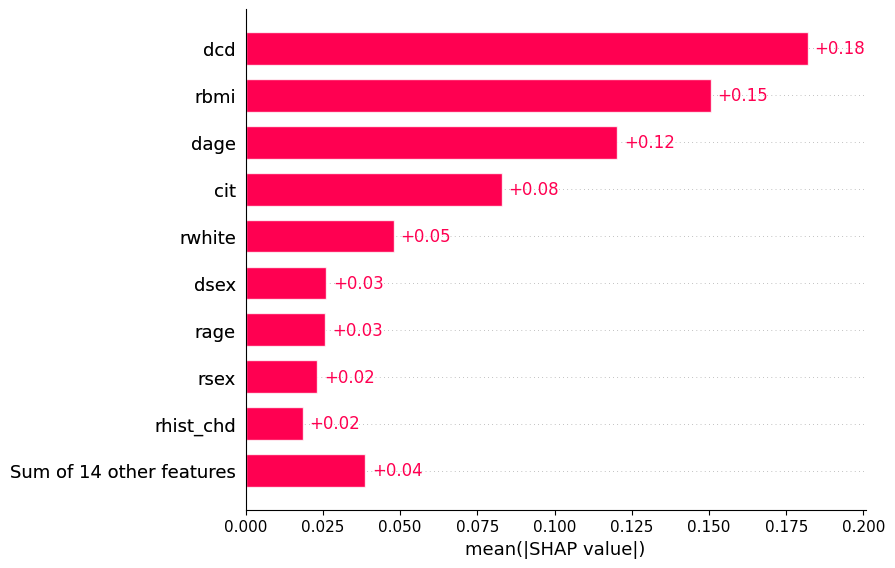

In [171]:
# Create SHAP explainer
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values
shap_values = explainer(X_test)
shap.plots.bar(shap_values)

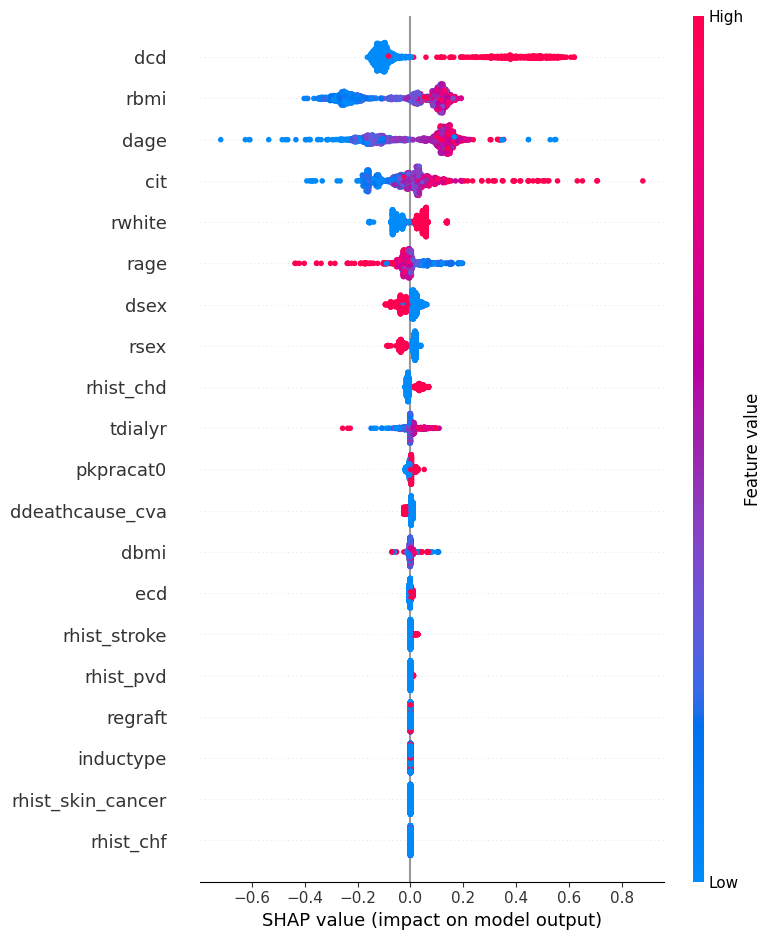

In [172]:
# Create SHAP explainer
explainer = shap.TreeExplainer(best_model, X_train)
shap_values = explainer(X_train)

# Summary force plot
shap.summary_plot(shap_values, X_train)


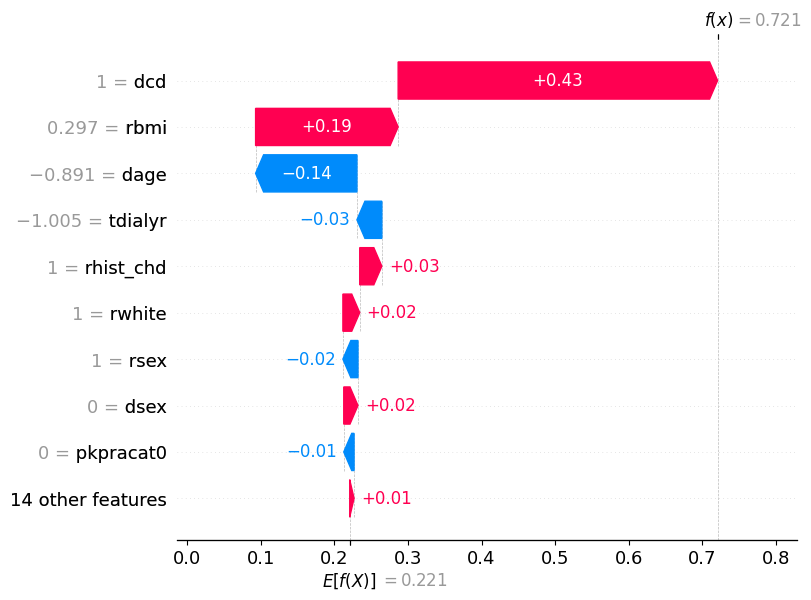

In [179]:
# Create SHAP explainer
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[7])

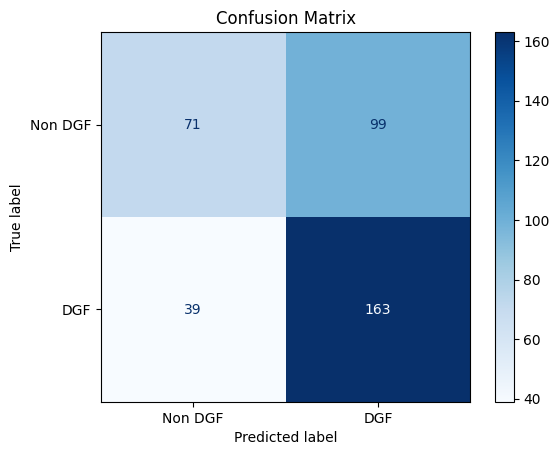

In [180]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
# Predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Map labels
label_mapping = {0: 'Non DGF', 1: 'DGF'}
y_test_mapped = [label_mapping[label] for label in y_test]
y_pred_mapped = [label_mapping[label] for label in y_pred]

# Plot confusion matrix
cm = confusion_matrix(y_test_mapped, y_pred_mapped, labels=['Non DGF', 'DGF'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non DGF', 'DGF'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


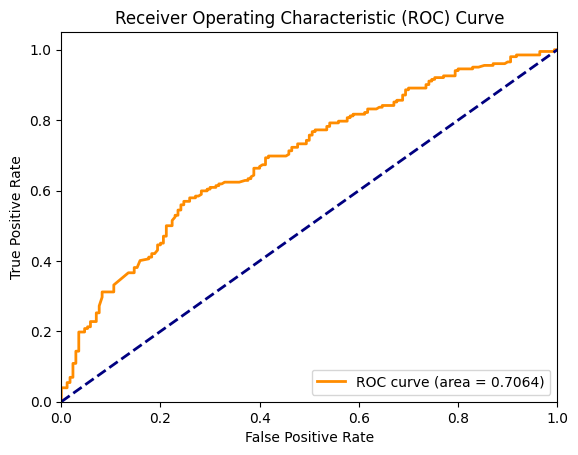

In [187]:
# Plot ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = 0.7064)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [186]:
best_model.predict_proba(X_test)

array([[0.24495676, 0.75504324],
       [0.47608077, 0.52391923],
       [0.26150516, 0.73849484],
       [0.50763669, 0.49236331],
       [0.47534304, 0.52465696],
       [0.44636113, 0.55363887],
       [0.58929018, 0.41070982],
       [0.32723575, 0.67276425],
       [0.61616479, 0.38383521],
       [0.40922701, 0.59077299],
       [0.54131662, 0.45868338],
       [0.51622525, 0.48377475],
       [0.49673935, 0.50326065],
       [0.37615662, 0.62384338],
       [0.30823799, 0.69176201],
       [0.62375942, 0.37624058],
       [0.51529352, 0.48470648],
       [0.38193339, 0.61806661],
       [0.449955  , 0.550045  ],
       [0.59970601, 0.40029399],
       [0.37928925, 0.62071075],
       [0.41911873, 0.58088127],
       [0.31809791, 0.68190209],
       [0.44559829, 0.55440171],
       [0.37615662, 0.62384338],
       [0.50484827, 0.49515173],
       [0.5063247 , 0.4936753 ],
       [0.23673144, 0.76326856],
       [0.33562421, 0.66437579],
       [0.45738793, 0.54261207],
       [0.

In [193]:
df_cleaned['crr2_lt30'].value_counts(normalized=True)

TypeError: IndexOpsMixin.value_counts() got an unexpected keyword argument 'normalized'

## Predicting Crr2_lt30 using Random Forest

In [138]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, make_scorer
import pandas as pd
import numpy as np

# Random states, criterion, n_estimators, max_depth to search
param_grid = {
    'random_state': [32, 100, 777, 2022, 8888],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [8, 16, 50, 100, 150, 200],
    'max_depth': [2, 4, 8, 16, 32]
}

# Custom scorer for specificity
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Custom scorer for weighted specificity
def weighted_specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    specificity = tn / (tn + fp)
    return specificity

# Define scoring dictionary
scoring = {
    'AUC': 'roc_auc',
    'Accuracy': 'accuracy',
    'F1_weighted': make_scorer(f1_score, average='weighted'),
    'Sensitivity': make_scorer(recall_score, pos_label=1),
    'Specificity': make_scorer(specificity_score),
    'Precision': make_scorer(precision_score, pos_label=1, zero_division=0),
    'Recall': make_scorer(recall_score, pos_label=1),
    'Sensitivity_weighted': make_scorer(recall_score, average='weighted'),
    'Specificity_weighted': make_scorer(weighted_specificity_score),
    'Precision_weighted': make_scorer(precision_score, average='weighted', zero_division=0),
    'Recall_weighted': make_scorer(recall_score, average='weighted')
}

def calculate_confidence_interval(data):
    mean = np.mean(data)
    std_err = np.std(data) / np.sqrt(len(data))
    ci = 1.96 * std_err
    return mean, ci

def run_grid_search(X, y):
    # Set up the Random Forest Classifier and GridSearchCV
    rf = RandomForestClassifier()
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring=scoring, cv=5, n_jobs=-1, return_train_score=True, refit='Accuracy')
    
    # Fit the grid search on the entire dataset
    grid_search.fit(X, y)
    
    # Access all the results
    results = pd.DataFrame(grid_search.cv_results_)
    
    # Sort the models by mean test accuracy score
    results = results.sort_values(by='mean_test_AUC', ascending=False)
    
    # Get top N models by mean test accuracy score
    top_models = results
    
    top_models_metrics = []
    
    for i, row in top_models.iterrows():
        params = {key: row['param_' + key] for key in param_grid}
        
        # Collect mean metrics and confidence intervals from cross-validation results
        metrics = {
            'AUC': f"{round(row['mean_test_AUC'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_AUC'] for j in range(5)])[1], 4)}",
            'Accuracy': f"{round(row['mean_test_Accuracy'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Accuracy'] for j in range(5)])[1], 4)}",
            'F1_weighted': f"{round(row['mean_test_F1_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_F1_weighted'] for j in range(5)])[1], 4)}",
            'Sensitivity': f"{round(row['mean_test_Sensitivity'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Sensitivity'] for j in range(5)])[1], 4)}",
            'Specificity': f"{round(row['mean_test_Specificity'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Specificity'] for j in range(5)])[1], 4)}",
            'Precision': f"{round(row['mean_test_Precision'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Precision'] for j in range(5)])[1], 4)}",
            'Recall': f"{round(row['mean_test_Recall'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Recall'] for j in range(5)])[1], 4)}",
            'Sensitivity_weighted': f"{round(row['mean_test_Sensitivity_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Sensitivity_weighted'] for j in range(5)])[1], 4)}",
            'Specificity_weighted': f"{round(row['mean_test_Specificity_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Specificity_weighted'] for j in range(5)])[1], 4)}",
            'Precision_weighted': f"{round(row['mean_test_Precision_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Precision_weighted'] for j in range(5)])[1], 4)}",
            'Recall_weighted': f"{round(row['mean_test_Recall_weighted'], 4)} ± {round(calculate_confidence_interval([row[f'split{j}_test_Recall_weighted'] for j in range(5)])[1], 4)}",
            'params': params,
        }
        
        top_models_metrics.append(metrics)
    
    return pd.DataFrame(top_models_metrics), grid_search.best_estimator_

In [90]:
all_metrics_crr_rf, best_model_crr_rf = run_grid_search(X, y_crr2_lt30)

/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [91]:
second_all_metrics = all_metrics_crr_rf
second_best_model = best_model_crr_rf

In [92]:
second_all_metrics.to_csv('all_metrics_rf_dgf_creatinine.csv', index=False)

In [95]:
best_auc_test = second_all_metrics.sort_values(by=['AUC'], ascending=False).reset_index(drop=True)

In [97]:
best_auc_test[best_auc_test['AUC'] > '0.64'].sort_values(by=['F1_weighted'], ascending=False).reset_index(drop=True)

AUC         Accuracy      F1_weighted      Sensitivity  \
0    0.64 ± 0.0176  0.6087 ± 0.0103  0.6035 ± 0.0091  0.7065 ± 0.0352   
1    0.64 ± 0.0176  0.6087 ± 0.0103  0.6035 ± 0.0091  0.7065 ± 0.0352   
2  0.6404 ± 0.0201  0.6027 ± 0.0241  0.5978 ± 0.0219  0.7016 ± 0.0446   
3  0.6404 ± 0.0201  0.6027 ± 0.0241  0.5978 ± 0.0219  0.7016 ± 0.0446   
4   0.6405 ± 0.014  0.6038 ± 0.0057  0.5791 ± 0.0069  0.8152 ± 0.0157   
5  0.6402 ± 0.0141  0.6011 ± 0.0098   0.577 ± 0.0115   0.8093 ± 0.017   

       Specificity        Precision           Recall Sensitivity_weighted  \
0  0.4891 ± 0.0311  0.6285 ± 0.0077  0.7065 ± 0.0352      0.6087 ± 0.0103   
1  0.4891 ± 0.0311  0.6285 ± 0.0077  0.7065 ± 0.0352      0.6087 ± 0.0103   
2   0.4819 ± 0.005  0.6226 ± 0.0147  0.7016 ± 0.0446      0.6027 ± 0.0241   
3   0.4819 ± 0.005  0.6226 ± 0.0147  0.7016 ± 0.0446      0.6027 ± 0.0241   
4  0.3454 ± 0.0188  0.6036 ± 0.0044  0.8152 ± 0.0157      0.6038 ± 0.0057   
5  0.3466 ± 0.0235  0.6023 ± 0.0075   0.8093 ± 0.017      0.6011 ± 0.0098   

  Specificity_weighted Precision_weighted  Recall_weighted  \
0      0.4891 ± 0.0311     0.606 ± 0.0105  0.6087 ± 0.0103   
1      0.4891 ± 0.0311     0.606 ± 0.0105  0.6087 ± 0.0103   
2       0.4819 ± 0.005       0.6 ± 0.0245  0.6027 ± 0.0241   
3       0.4819 ± 0.005       0.6 ± 0.0245  0.6027 ± 0.0241   
4      0.3454 ± 0.0188    0.6043 ± 0.0075  0.6038 ± 0.0057   
5      0.3466 ± 0.0235     0.6005 ± 0.012  0.6011 ± 0.0098   

                                              params  
0  {'random_state': 100, 'criterion': 'log_loss',...  
1  {'random_state': 100, 'criterion': 'entropy', ...  
2  {'random_state': 32, 'criterion': 'entropy', '...  
3  {'random_state': 32, 'criterion': 'log_loss', ...  
4  {'random_state': 8888, 'criterion': 'gini', 'n...  
5  {'random_state': 8888, 'criterion': 'gini', 'n...

In [107]:
best_auc_test.loc[1]['params']

{'random_state': 100, 'criterion': 'gini', 'n_estimators': 150, 'max_depth': 2}

In [144]:
best_model = RandomForestClassifier(**{'random_state': 100, 'criterion': 'entropy', 'n_estimators': 150, 'max_depth': 16})
best_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=16, n_estimators=150,
                       random_state=100)

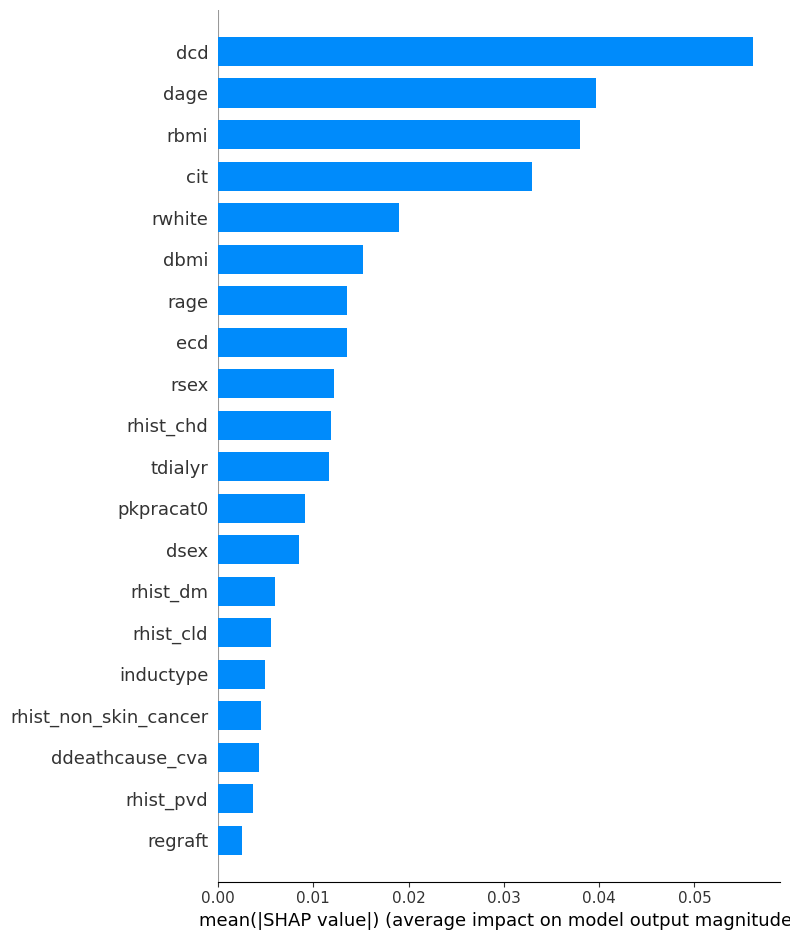

In [145]:
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for test set
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[:,:,1], X_test, plot_type='bar')

In [146]:
# SHAP analysis
def shap_analysis(model, X_train, X_test):
    explainer = shap.TreeExplainer(model)
    
    # Calculate SHAP values for test set
    shap_values = explainer.shap_values(X_test)
    
    # Summary plot
    shap.summary_plot(shap_values[:,:,1], X_test)

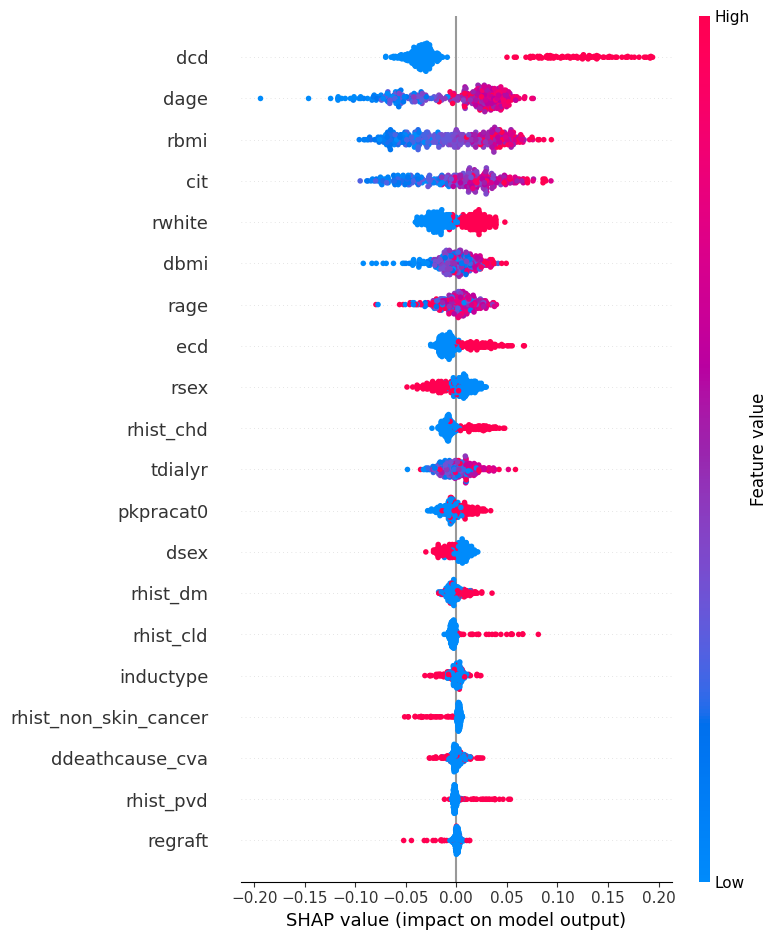

In [147]:
shap_analysis(best_model, X_train, X_test)

In [148]:
# Create SHAP explainer
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values
shap_values = explainer(X_test)

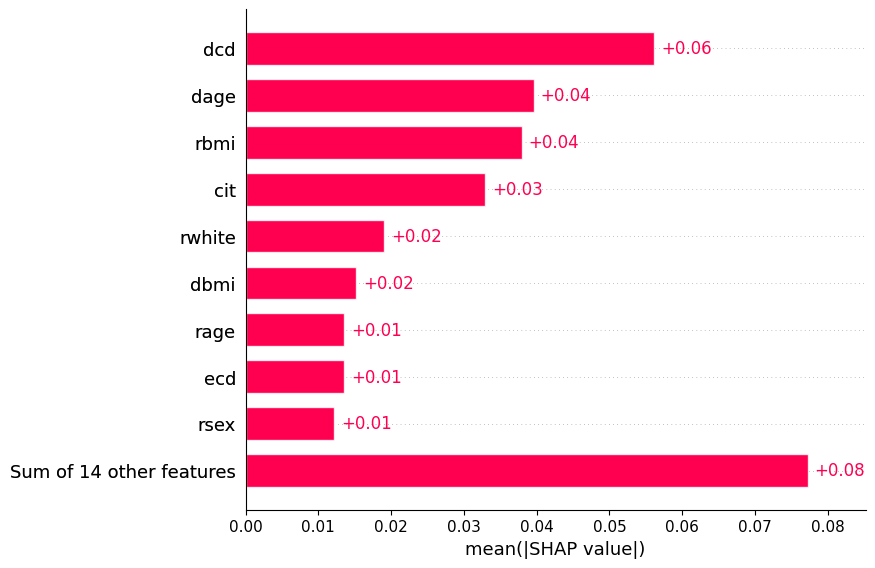

In [149]:

shap.plots.bar(shap_values[:,:,0])

In [150]:
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for test set
shap_values = explainer.shap_values(X_test)

# Force plot for a single prediction (e.g., the first instance in the test set)
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[:,:,0], X_test.columns)

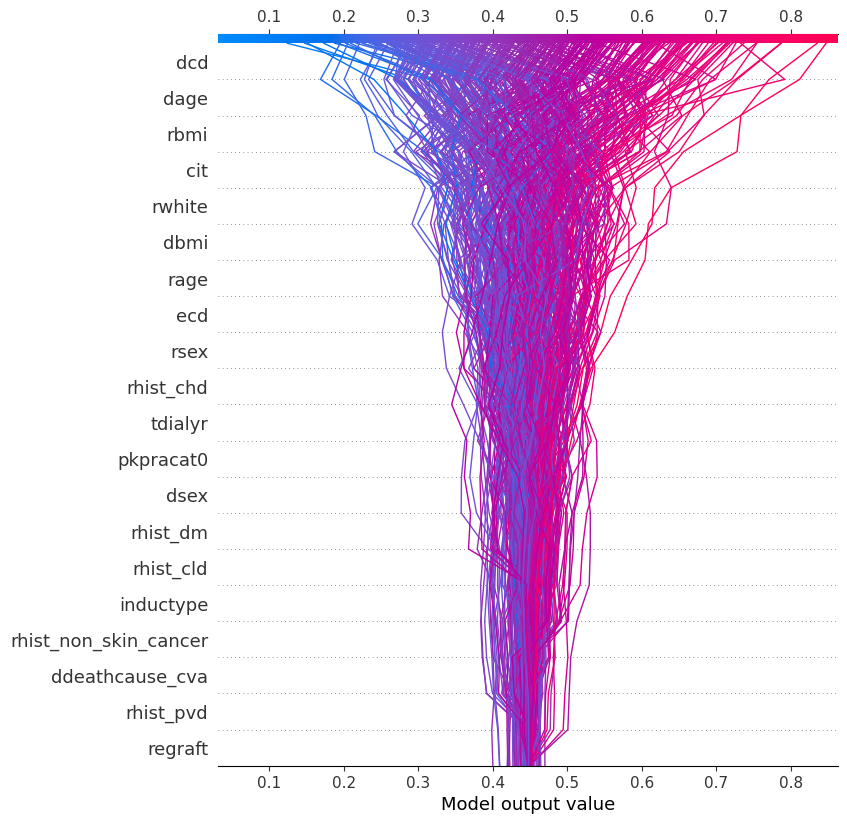

In [151]:
# Force plot for a single prediction (e.g., the first instance in the test set)
shap.initjs()
shap.plots.decision(explainer.expected_value[0], shap_values[:,:,0], X_test)

## Predicting crr2

In [121]:
def run_grid_search_cont(X, y):
    # Set up the Random Forest Regressor and GridSearchCV
    rf = RandomForestRegressor()
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1, return_train_score=True)
    
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    grid_search.fit(X_train, y_train)
    
    # Access all the results
    results = pd.DataFrame(grid_search.cv_results_)
    
    # Sort the models by test AUC score
    results = results.sort_values(by='mean_test_score', ascending=False)
    
    # Get top N models by AUC score
    top_models = results
    
    top_models_metrics = []
    
    for i, row in top_models.iterrows():
        params = {key: row['param_' + key] for key in param_grid}
        #print(f"Parameters for model {i+1}: {params}")
        
        # Re-train the model with the top parameters
        model = RandomForestClassifier(**params)
        model.fit(X_train, y_train)
        
        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Metrics calculation
        metrics = {
            'AUC_train': round(roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]), 4),
            'AUC_test': round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]), 4),
            'Accuracy_train': round(accuracy_score(y_train, y_train_pred), 4),
            'Accuracy_test': round(accuracy_score(y_test, y_test_pred), 4),
            'F1_Class1_train': round(f1_score(y_train, y_train_pred, pos_label=1), 4),
            'F1_Class1_test': round(f1_score(y_test, y_test_pred, pos_label=1), 4),
            'F1_Class0_train': round(f1_score(y_train, y_train_pred, pos_label=0), 4),
            'F1_Class0_test': round(f1_score(y_test, y_test_pred, pos_label=0), 4),
            'params': params,
        }
        
        top_models_metrics.append(metrics)
    
    return pd.DataFrame(top_models_metrics), model, X_train, X_test, y_train, y_test

In [126]:
all_metrics, best_model, X_train, X_test, y_train, y_test = run_grid_search_cont(X, y_crr2)

ValueError: 
All the 2250 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
192 fits failed with the following error:
Traceback (most recent call last):
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'criterion' parameter of RandomForestRegressor must be a str among {'friedman_mse', 'poisson', 'squared_error', 'absolute_error'}. Got 'gini' instead.

--------------------------------------------------------------------------------
197 fits failed with the following error:
Traceback (most recent call last):
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'criterion' parameter of RandomForestRegressor must be a str among {'friedman_mse', 'squared_error', 'poisson', 'absolute_error'}. Got 'gini' instead.

--------------------------------------------------------------------------------
168 fits failed with the following error:
Traceback (most recent call last):
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'criterion' parameter of RandomForestRegressor must be a str among {'poisson', 'absolute_error', 'squared_error', 'friedman_mse'}. Got 'gini' instead.

--------------------------------------------------------------------------------
193 fits failed with the following error:
Traceback (most recent call last):
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'criterion' parameter of RandomForestRegressor must be a str among {'squared_error', 'friedman_mse', 'poisson', 'absolute_error'}. Got 'gini' instead.

--------------------------------------------------------------------------------
174 fits failed with the following error:
Traceback (most recent call last):
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'criterion' parameter of RandomForestRegressor must be a str among {'poisson', 'absolute_error', 'squared_error', 'friedman_mse'}. Got 'entropy' instead.

--------------------------------------------------------------------------------
192 fits failed with the following error:
Traceback (most recent call last):
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'criterion' parameter of RandomForestRegressor must be a str among {'friedman_mse', 'squared_error', 'poisson', 'absolute_error'}. Got 'entropy' instead.

--------------------------------------------------------------------------------
192 fits failed with the following error:
Traceback (most recent call last):
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'criterion' parameter of RandomForestRegressor must be a str among {'friedman_mse', 'poisson', 'squared_error', 'absolute_error'}. Got 'entropy' instead.

--------------------------------------------------------------------------------
192 fits failed with the following error:
Traceback (most recent call last):
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'criterion' parameter of RandomForestRegressor must be a str among {'squared_error', 'friedman_mse', 'poisson', 'absolute_error'}. Got 'entropy' instead.

--------------------------------------------------------------------------------
204 fits failed with the following error:
Traceback (most recent call last):
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'criterion' parameter of RandomForestRegressor must be a str among {'poisson', 'absolute_error', 'squared_error', 'friedman_mse'}. Got 'log_loss' instead.

--------------------------------------------------------------------------------
216 fits failed with the following error:
Traceback (most recent call last):
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'criterion' parameter of RandomForestRegressor must be a str among {'friedman_mse', 'squared_error', 'poisson', 'absolute_error'}. Got 'log_loss' instead.

--------------------------------------------------------------------------------
190 fits failed with the following error:
Traceback (most recent call last):
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'criterion' parameter of RandomForestRegressor must be a str among {'friedman_mse', 'poisson', 'squared_error', 'absolute_error'}. Got 'log_loss' instead.

--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'criterion' parameter of RandomForestRegressor must be a str among {'squared_error', 'friedman_mse', 'poisson', 'absolute_error'}. Got 'log_loss' instead.


## With Crr2

In [35]:
X, y_dgf, y_crr2_lt30 = df_cleaned.drop(columns=["crr2_lt30", "dgf"]), df_cleaned['dgf'], df_cleaned['crr2_lt30']

In [36]:
X.sample(10)

crr2  rage  rsex  rwhite  rbmi  tdialyr  pkpracat0  dage  dbmi  \
72    30.000000    55     0     0.0  29.0     6.03        0.0  48.0  21.0   
1088 -11.000000    58     1     1.0  31.0     7.14        0.0  57.0  25.0   
208   28.000000    55     0     0.0  24.0     6.40        1.0  24.0  23.0   
1742  18.000000    64     0     0.0  24.0     2.88        0.0  62.0  23.0   
186   57.000000    54     1     0.0  23.0     2.40        0.0  35.0  26.0   
501   24.901523    65     0     1.0  25.0     3.04        0.0  16.0  21.0   
200   34.000000    55     0     1.0  31.0     4.25        1.0  73.0  22.0   
719  -15.000000    66     1     0.0  34.0    11.25        1.0  58.0  22.0   
510  -24.000000    56     1     0.0  29.0     3.49        0.0  53.0  24.0   
261    1.000000    33     0     0.0  31.0     6.86        1.0  61.0  27.0   

            cit  inductype  cni_disch  txera  status  bpar  \
72    10.820000        1.0        0.0      0       0     0   
1088   4.630000        0.0        0.0      1       0     1   
208   11.447472        0.0        0.0      2       1     0   
1742   6.170000        0.0        0.0      2       2     0   
186   10.500000        0.0        0.0      2       1     0   
501   21.620000        0.0        1.0      0       2     0   
200    5.220000        0.0        0.0      1       2     0   
719   11.000000        1.0        0.0      2       2     0   
510    4.420000        0.0        0.0      2       1     0   
261   11.447472        0.0        1.0      0       1     0   

      days_to_readmission  days_to_status  
72              86.000000            4143  
1088           396.000000            3292  
208             20.000000             913  
1742             0.000000              47  
186            421.968254            1827  
501             15.000000            4236  
200            524.000000            2742  
719            421.968254             655  
510            421.968254             585  
261            421.968254            7157

In [2]:
import pandas as pd
X = pd.read_csv('X_train_without_crr2.csv')

In [3]:
X.columns

Index(['rage', 'rsex', 'rwhite', 'rbmi', 'tdialyr', 'pkpracat0', 'rhist_dm',
       'rhist_chd', 'rhist_chf', 'rhist_stroke', 'rhist_pvd', 'rhist_cld',
       'rhist_skin_cancer', 'rhist_non_skin_cancer', 'dage', 'dsex', 'dbmi',
       'ddeathcause_cva', 'cit', 'ecd', 'dcd', 'regraft', 'inductype'],
      dtype='object')

In [37]:
X.describe()

crr2         rage         rsex       rwhite         rbmi  \
count  1856.000000  1856.000000  1856.000000  1856.000000  1856.000000   
mean     24.904703    54.873922     0.373384     0.378233    27.296836   
std      25.483025    12.593210     0.483833     0.485077     5.591179   
min    -135.000000    18.000000     0.000000     0.000000    13.000000   
25%       5.000000    47.000000     0.000000     0.000000    23.000000   
50%      26.000000    56.000000     0.000000     0.000000    27.000000   
75%      43.250000    64.000000     1.000000     1.000000    30.000000   
max      91.000000    84.000000     1.000000     1.000000    55.000000   

           tdialyr    pkpracat0         dage         dbmi          cit  \
count  1856.000000  1856.000000  1856.000000  1856.000000  1856.000000   
mean      5.118905     0.412716    47.784004    27.055114    11.444954   
std       3.074666     0.492455    15.450183     6.169459     4.624046   
min       0.000000     0.000000     0.000000    13.000000     0.000000   
25%       3.170000     0.000000    38.000000    23.000000     8.365000   
50%       4.790000     0.000000    49.000000    26.000000    11.447472   
75%       6.600000     1.000000    59.000000    30.000000    13.350000   
max      34.580000     1.000000    83.000000    80.000000    35.520000   

         inductype    cni_disch        txera       status         bpar  \
count  1856.000000  1856.000000  1856.000000  1856.000000  1856.000000   
mean      0.222522     0.126078     1.188039     0.899784     0.116379   
std       0.416052     0.332026     0.808104     0.637279     0.320766   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.750000     0.000000     0.000000   
50%       0.000000     0.000000     1.000000     1.000000     0.000000   
75%       0.000000     0.000000     2.000000     1.000000     0.000000   
max       1.000000     1.000000     2.000000     2.000000     1.000000   

       days_to_readmission  days_to_status  
count          1856.000000     1856.000000  
mean            419.942375     2604.244612  
std             565.880978     1830.555607  
min               0.000000        0.000000  
25%              56.000000     1194.000000  
50%             421.968254     2260.000000  
75%             421.968254     3619.250000  
max            4885.000000     8692.000000

### Normalize the Data

In [38]:
normalized_vars = ['crr2','rage', 'rbmi', 'tdialyr', 'dage', 'dbmi', 'cit', 'days_to_readmission', 'days_to_status']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical columns
X[normalized_vars] = scaler.fit_transform(X[normalized_vars])

## Predicting DGF

## GridSearchCV for Random Forest

In [231]:
all_metrics, best_model, X_train, X_test, y_train, y_test = run_grid_search(X, y_dgf)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y_dgf, test_size=0.2, random_state=42)

In [41]:
X_train.to_csv('X_train_with_crr2.csv',index=False)
X_test.to_csv('X_test_with_crr2.csv',index=False)
y_train.to_csv('y_dgf_train_with_crr2.csv',index=False)
y_test.to_csv('y_dgf_test_with_crr2.csv',index=False)

In [232]:
third_all_metrics = all_metrics
third_best_model = best_model

In [233]:
best_auc_test = all_metrics.sort_values(by=['AUC_test'], ascending=False).reset_index(drop=True)

In [234]:
best_auc_test.head(10)

AUC_train  AUC_test  Accuracy_train  Accuracy_test  F1_Class1_train  \
0     0.7774    0.7656          0.6496         0.6774           0.0406   
1     0.7774    0.7656          0.6496         0.6774           0.0406   
2     0.9643    0.7650          0.8747         0.7231           0.7929   
3     0.9643    0.7650          0.8747         0.7231           0.7929   
4     0.9646    0.7642          0.8747         0.7258           0.7924   
5     0.9646    0.7642          0.8747         0.7258           0.7924   
6     0.9634    0.7640          0.8747         0.7231           0.7924   
7     0.9634    0.7640          0.8747         0.7231           0.7924   
8     0.8287    0.7628          0.7520         0.6989           0.5093   
9     0.8287    0.7628          0.7520         0.6989           0.5093   

   F1_Class1_test  F1_Class0_train  F1_Class0_test  \
0          0.0323           0.7857          0.8065   
1          0.0323           0.7857          0.8065   
2          0.4663           0.9101          0.8131   
3          0.4663           0.9101          0.8131   
4          0.4742           0.9102          0.8145   
5          0.4742           0.9102          0.8145   
6          0.4718           0.9102          0.8124   
7          0.4718           0.9102          0.8124   
8          0.3333           0.8341          0.8056   
9          0.3333           0.8341          0.8056   

                                              params  
0  {'random_state': 8888, 'criterion': 'log_loss'...  
1  {'random_state': 8888, 'criterion': 'entropy',...  
2  {'random_state': 8888, 'criterion': 'log_loss'...  
3  {'random_state': 8888, 'criterion': 'entropy',...  
4  {'random_state': 8888, 'criterion': 'entropy',...  
5  {'random_state': 8888, 'criterion': 'log_loss'...  
6  {'random_state': 8888, 'criterion': 'entropy',...  
7  {'random_state': 8888, 'criterion': 'log_loss'...  
8  {'random_state': 2022, 'criterion': 'log_loss'...  
9  {'random_state': 2022, 'criterion': 'entropy',...

In [235]:
best_auc_test = all_metrics.sort_values(by=['AUC_test'], ascending=False).reset_index(drop=True)

In [236]:
best_model = RandomForestClassifier(**best_auc_test.loc[1]['params'])
best_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=2, n_estimators=16,
                       random_state=8888)

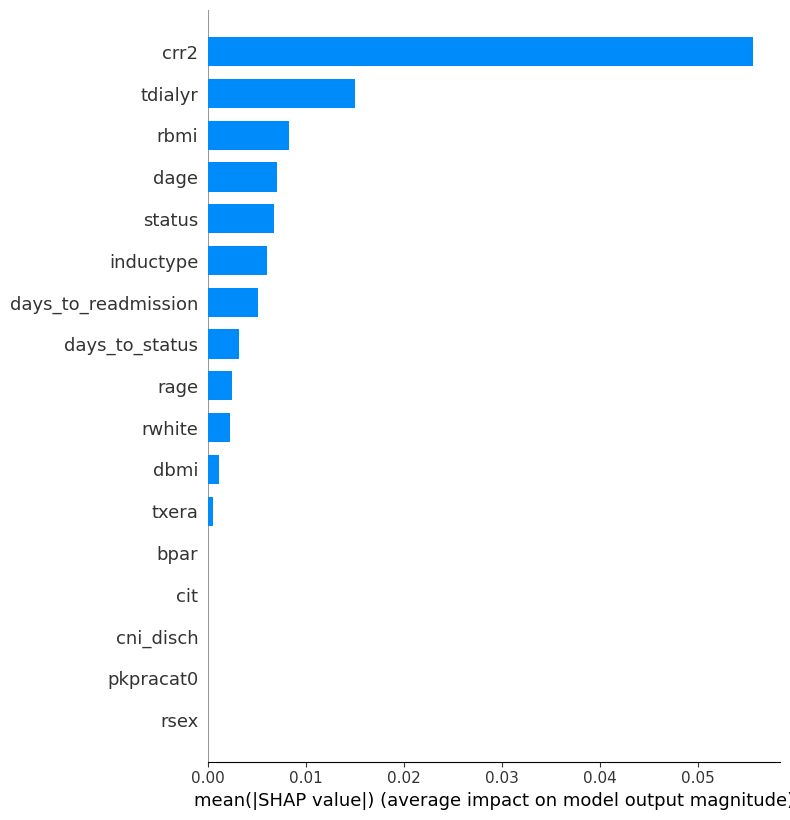

In [237]:
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for test set
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[:,:,1], X_test, plot_type='bar')

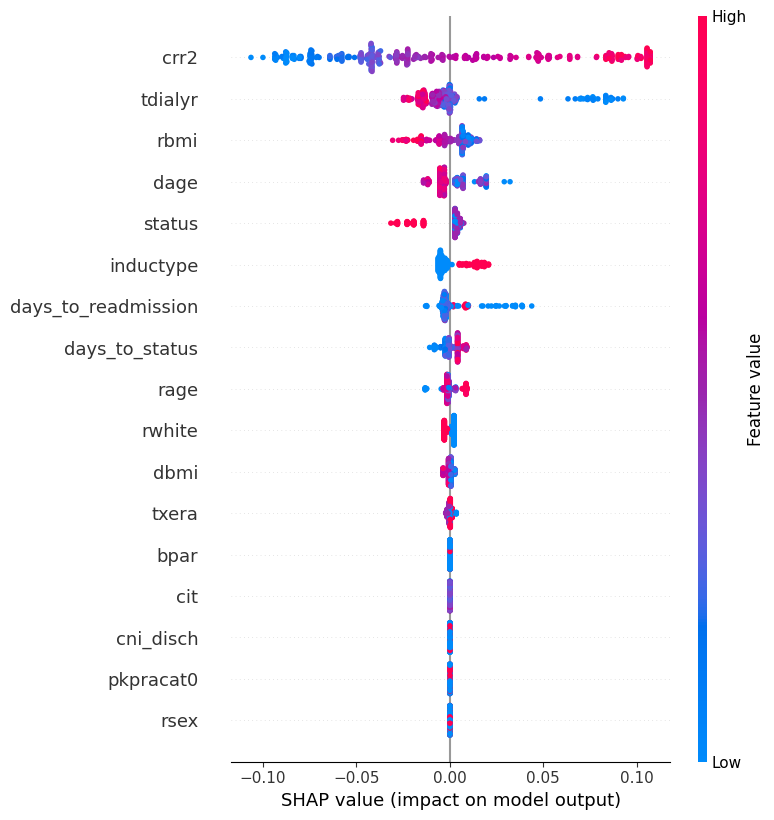

In [238]:
shap_analysis(best_model, X_train, X_test)

In [239]:
# Create SHAP explainer
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values
shap_values = explainer(X_test)

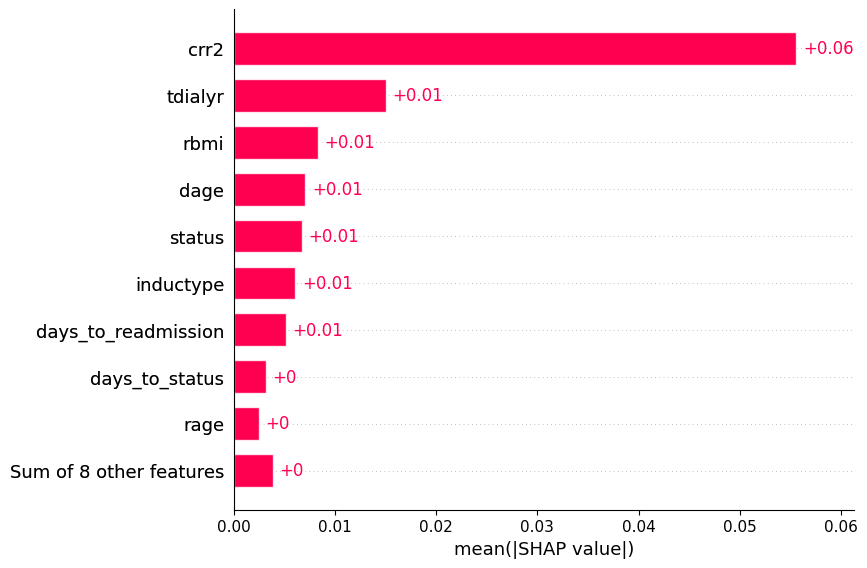

In [240]:
shap.plots.bar(shap_values[:,:,0])

In [241]:
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for test set
shap_values = explainer.shap_values(X_test)

# Force plot for a single prediction (e.g., the first instance in the test set)
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[:,:,0], X_test.columns)

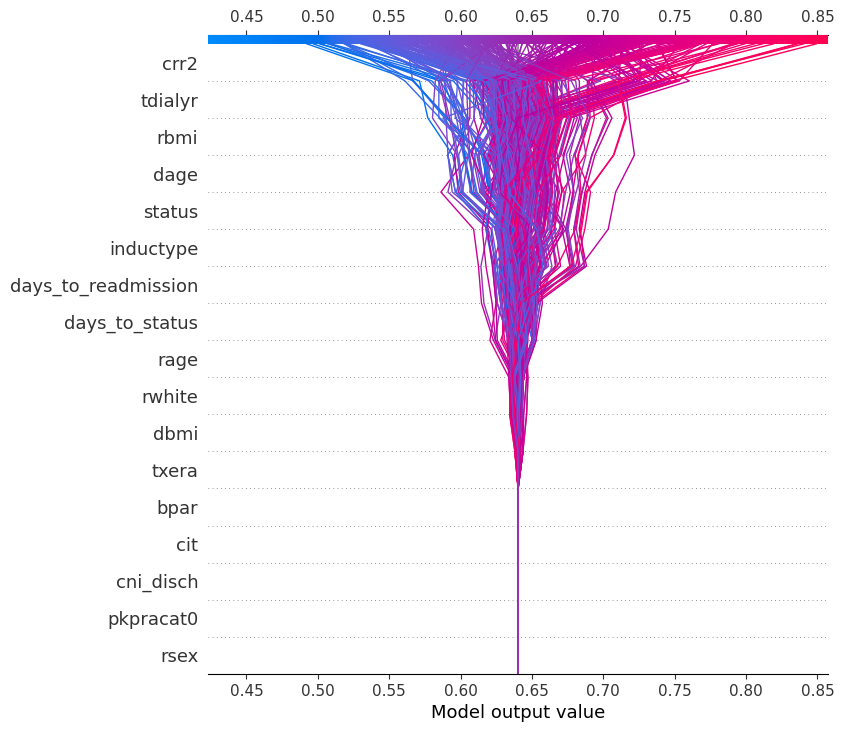

In [242]:
# Force plot for a single prediction (e.g., the first instance in the test set)
shap.initjs()
shap.plots.decision(explainer.expected_value[0], shap_values[:,:,0], X_test)

## Ablation Analysis

## Without Crr2

### Predicting DGF

In [39]:
model_evaluation(RandomForestClassifier(random_state=42), X, y_dgf)

Model: RandomForestClassifier(random_state=42)
Accuracy: 0.6371
AUC: 0.5517
F1 Score (Class 1): 0.2703
F1 Score (Class 2): 0.7585
Average Cross-validation Score: 0.6498


### Predicting crr2_lt30

In [40]:
model_evaluation(RandomForestClassifier(random_state=42), X, y_crr2_lt30)

Model: RandomForestClassifier(random_state=42)
Accuracy: 0.5887
AUC: 0.5997
F1 Score (Class 1): 0.4742
F1 Score (Class 2): 0.6623
Average Cross-validation Score: 0.5787


In [28]:

# Random states, criterion, n_estimators, max_depth to search
param_grid = {
    'random_state': [32, 100, 777, 2022, 8888],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [8, 16, 50, 100, 150, 200],
    'max_depth': [2, 4, 8, 16, 32]
}

def run_grid_search(X, y):
    rf = RandomForestClassifier()
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
    
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    grid_search.fit(X_train, y_train)
    
    # Best parameters from grid search
    print(f"Best parameters: {grid_search.best_params_}")
    best_rf = grid_search.best_estimator_

    # Predictions
    y_train_pred = best_rf.predict(X_train)
    y_test_pred = best_rf.predict(X_test)
    
    # Metrics calculation and rounding
    metrics = {
        'AUC_train': round(roc_auc_score(y_train, best_rf.predict_proba(X_train)[:,1]), 4),
        'AUC_test': round(roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]), 4),
        'Accuracy_train': round(accuracy_score(y_train, y_train_pred), 4),
        'Accuracy_test': round(accuracy_score(y_test, y_test_pred), 4),
        'F1_Class1_train': round(f1_score(y_train, y_train_pred, pos_label=1), 4),
        'F1_Class1_test': round(f1_score(y_test, y_test_pred, pos_label=1), 4),
        'F1_Class0_train': round(f1_score(y_train, y_train_pred, pos_label=0), 4),
        'F1_Class0_test': round(f1_score(y_test, y_test_pred, pos_label=0), 4)
    }
    
    # Cross-validation scores
    cross_val_train = round(np.mean(cross_val_score(best_rf, X_train, y_train, cv=5)), 4)
    cross_val_test = round(np.mean(cross_val_score(best_rf, X_test, y_test, cv=5)), 4)
    
    metrics['Cross_Val_Score_train'] = cross_val_train
    metrics['Cross_Val_Score_test'] = cross_val_test

    return metrics


## Predicting DGF Withour Crr2

In [49]:
run_grid_search(X,y_dgf)

Best parameters: {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 50, 'random_state': 2022}


{'AUC_train': np.float64(0.9596101517064755),
 'AUC_test': np.float64(0.5875081967213114),
 'Accuracy_train': 0.818733153638814,
 'Accuracy_test': 0.696236559139785,
 'F1_Class1_train': np.float64(0.6624843161856964),
 'F1_Class1_test': np.float64(0.25165562913907286),
 'F1_Class2_train': np.float64(0.8760939659143252),
 'F1_Class2_test': np.float64(0.8094435075885329),
 'Cross_Val_Score': np.float64(0.6731959231959233)}

## Rounded Prediction of DGF without crr2

In [79]:
run_grid_search(X,y_dgf)

/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 50, 'random_state': 2022}


{'AUC_train': np.float64(0.9596),
 'AUC_test': np.float64(0.5875),
 'Accuracy_train': 0.8187,
 'Accuracy_test': 0.6962,
 'F1_Class1_train': np.float64(0.6625),
 'F1_Class1_test': np.float64(0.2517),
 'F1_Class0_train': np.float64(0.8761),
 'F1_Class0_test': np.float64(0.8094),
 'Cross_Val_Score_train': np.float64(0.6732),
 'Cross_Val_Score_test': np.float64(0.6587)}

## Accuracy-Based Prediction

In [29]:
# Random states, criterion, n_estimators, max_depth to search
param_grid = {
    'random_state': [32, 100, 777, 2022, 8888],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [8, 16, 50, 100, 150, 200],
    'max_depth': [2, 4, 8, 16, 32]
}

def run_grid_search(X, y, rank=1):
    rf = RandomForestClassifier()
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
    
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    grid_search.fit(X_train, y_train)
    
    # Access all the results
    results = grid_search.cv_results_
    sorted_indices = np.argsort(results['rank_test_score'])
    
    # Get the rank-th best model
    best_index = sorted_indices[rank-1]  # rank-1 because index starts from 0
    best_params = {key: results['param_' + key][best_index] for key in param_grid}
    print(f"Parameters for {rank} best model: {best_params}")
    
    # Use the rank-th best model's parameters
    best_rf = RandomForestClassifier(**best_params)
    best_rf.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = best_rf.predict(X_train)
    y_test_pred = best_rf.predict(X_test)
    
    # Metrics calculation and rounding
    metrics = {
        'AUC_train': round(roc_auc_score(y_train, best_rf.predict_proba(X_train)[:,1]), 4),
        'AUC_test': round(roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]), 4),
        'Accuracy_train': round(accuracy_score(y_train, y_train_pred), 4),
        'Accuracy_test': round(accuracy_score(y_test, y_test_pred), 4),
        'F1_Class1_train': round(f1_score(y_train, y_train_pred, pos_label=1), 4),
        'F1_Class1_test': round(f1_score(y_test, y_test_pred, pos_label=1), 4),
        'F1_Class0_train': round(f1_score(y_train, y_train_pred, pos_label=0), 4),
        'F1_Class0_test': round(f1_score(y_test, y_test_pred, pos_label=0), 4)
    }
    
    # Cross-validation scores
    cross_val_train = round(np.mean(cross_val_score(best_rf, X_train, y_train, cv=5)), 4)
    cross_val_test = round(np.mean(cross_val_score(best_rf, X_test, y_test, cv=5)), 4)
    
    metrics['Cross_Val_Score_train'] = cross_val_train
    metrics['Cross_Val_Score_test'] = cross_val_test

    return metrics



## 2nd Best Metrics

In [94]:
# running for 2nd and 3rd best models on dataset
metrics_2nd_best = run_grid_search(X, y_dgf, rank=2)

Parameters for 2 best model: {'random_state': np.int64(2022), 'criterion': 'log_loss', 'n_estimators': np.int64(50), 'max_depth': np.int64(8)}


In [95]:
metrics_2nd_best

{'AUC_train': np.float64(0.9596),
 'AUC_test': np.float64(0.5875),
 'Accuracy_train': 0.8187,
 'Accuracy_test': 0.6962,
 'F1_Class1_train': np.float64(0.6625),
 'F1_Class1_test': np.float64(0.2517),
 'F1_Class0_train': np.float64(0.8761),
 'F1_Class0_test': np.float64(0.8094),
 'Cross_Val_Score_train': np.float64(0.6732),
 'Cross_Val_Score_test': np.float64(0.6587)}

## 3rd Best Metrics

In [96]:
metrics_3rd_best = run_grid_search(X, y_dgf, rank=3)

/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Parameters for 3 best model: {'random_state': np.int64(8888), 'criterion': 'log_loss', 'n_estimators': np.int64(100), 'max_depth': np.int64(8)}


In [97]:
metrics_3rd_best

{'AUC_train': np.float64(0.9628),
 'AUC_test': np.float64(0.5931),
 'Accuracy_train': 0.8208,
 'Accuracy_test': 0.6909,
 'F1_Class1_train': np.float64(0.6667),
 'F1_Class1_test': np.float64(0.2581),
 'F1_Class0_train': np.float64(0.8774),
 'F1_Class0_test': np.float64(0.8048),
 'Cross_Val_Score_train': np.float64(0.6718),
 'Cross_Val_Score_test': np.float64(0.6613)}

## 4th Best Metrics

In [98]:
metrics_4th_best = run_grid_search(X, y_dgf, rank=4)

/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Parameters for 4 best model: {'random_state': np.int64(8888), 'criterion': 'entropy', 'n_estimators': np.int64(100), 'max_depth': np.int64(8)}


In [100]:
metrics_4th_best

{'AUC_train': np.float64(0.9628),
 'AUC_test': np.float64(0.5931),
 'Accuracy_train': 0.8208,
 'Accuracy_test': 0.6909,
 'F1_Class1_train': np.float64(0.6667),
 'F1_Class1_test': np.float64(0.2581),
 'F1_Class0_train': np.float64(0.8774),
 'F1_Class0_test': np.float64(0.8048),
 'Cross_Val_Score_train': np.float64(0.6718),
 'Cross_Val_Score_test': np.float64(0.6613)}

## Top 10 Models of Predicting DGF Without CRR2

In [102]:
rank=10

In [ ]:
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y_dgf, test_size=0.2, random_state=42)
grid_search.fit(X_train, y_train)

# Access all the results
results = grid_search.cv_results_
sorted_indices = np.argsort(results['rank_test_score'])

# Get the rank-th best model
best_index = sorted_indices[rank-1]  # rank-1 because index starts from 0
best_params = {key: results['param_' + key][best_index] for key in param_grid}
print(f"Parameters for {rank} best model: {best_params}")

# Use the rank-th best model's parameters
best_rf = RandomForestClassifier(**best_params)
best_rf.fit(X_train, y_train)

# Predictions
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# Metrics calculation and rounding
metrics = {
    'AUC_train': round(roc_auc_score(y_train, best_rf.predict_proba(X_train)[:,1]), 4),
    'AUC_test': round(roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]), 4),
    'Accuracy_train': round(accuracy_score(y_train, y_train_pred), 4),
    'Accuracy_test': round(accuracy_score(y_test, y_test_pred), 4),
    'F1_Class1_train': round(f1_score(y_train, y_train_pred, pos_label=1), 4),
    'F1_Class1_test': round(f1_score(y_test, y_test_pred, pos_label=1), 4),
    'F1_Class0_train': round(f1_score(y_train, y_train_pred, pos_label=0), 4),
    'F1_Class0_test': round(f1_score(y_test, y_test_pred, pos_label=0), 4)
}

# Cross-validation scores
cross_val_train = round(np.mean(cross_val_score(best_rf, X_train, y_train, cv=5)), 4)
cross_val_test = round(np.mean(cross_val_score(best_rf, X_test, y_test, cv=5)), 4)

metrics['Cross_Val_Score_train'] = cross_val_train
metrics['Cross_Val_Score_test'] = cross_val_test

In [121]:
for rank in range(1,10):    
    # Get the rank-th best model
    best_index = sorted_indices[rank-1]  # rank-1 because index starts from 0
    best_params = {key: results['param_' + key][best_index] for key in param_grid}
    print(f"Parameters for {rank} best model: {best_params}")

    # Use the rank-th best model's parameters
    best_rf = RandomForestClassifier(**best_params)
    best_rf.fit(X_train, y_train)

    # Predictions
    y_train_pred = best_rf.predict(X_train)
    y_test_pred = best_rf.predict(X_test)

    # Metrics calculation and rounding
    metrics = {
        'AUC_train': round(roc_auc_score(y_train, best_rf.predict_proba(X_train)[:,1]), 4),
        'AUC_test': round(roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]), 4),
        'Accuracy_train': round(accuracy_score(y_train, y_train_pred), 4),
        'Accuracy_test': round(accuracy_score(y_test, y_test_pred), 4),
        'F1_Class1_train': round(f1_score(y_train, y_train_pred, pos_label=1), 4),
        'F1_Class1_test': round(f1_score(y_test, y_test_pred, pos_label=1), 4),
        'F1_Class0_train': round(f1_score(y_train, y_train_pred, pos_label=0), 4),
        'F1_Class0_test': round(f1_score(y_test, y_test_pred, pos_label=0), 4)
    }

    # Cross-validation scores
    cross_val_train = round(np.mean(cross_val_score(best_rf, X_train, y_train, cv=5)), 4)
    cross_val_test = round(np.mean(cross_val_score(best_rf, X_test, y_test, cv=5)), 4)

    metrics['Cross_Val_Score_train'] = cross_val_train
    metrics['Cross_Val_Score_test'] = cross_val_test
    pprint.pprint(metrics)

Parameters for 1 best model: {'random_state': np.int64(2022), 'criterion': 'entropy', 'n_estimators': np.int64(50), 'max_depth': np.int64(8)}
{'AUC_test': np.float64(0.5875),
 'AUC_train': np.float64(0.9596),
 'Accuracy_test': 0.6962,
 'Accuracy_train': 0.8187,
 'Cross_Val_Score_test': np.float64(0.6587),
 'Cross_Val_Score_train': np.float64(0.6732),
 'F1_Class0_test': np.float64(0.8094),
 'F1_Class0_train': np.float64(0.8761),
 'F1_Class1_test': np.float64(0.2517),
 'F1_Class1_train': np.float64(0.6625)}
Parameters for 2 best model: {'random_state': np.int64(2022), 'criterion': 'log_loss', 'n_estimators': np.int64(50), 'max_depth': np.int64(8)}


{'AUC_test': np.float64(0.5875),
 'AUC_train': np.float64(0.9596),
 'Accuracy_test': 0.6962,
 'Accuracy_train': 0.8187,
 'Cross_Val_Score_test': np.float64(0.6587),
 'Cross_Val_Score_train': np.float64(0.6732),
 'F1_Class0_test': np.float64(0.8094),
 'F1_Class0_train': np.float64(0.8761),
 'F1_Class1_test': np.float64(0.2517),
 'F1_Class1_train': np.float64(0.6625)}
Parameters for 3 best model: {'random_state': np.int64(8888), 'criterion': 'log_loss', 'n_estimators': np.int64(100), 'max_depth': np.int64(8)}
{'AUC_test': np.float64(0.5931),
 'AUC_train': np.float64(0.9628),
 'Accuracy_test': 0.6909,
 'Accuracy_train': 0.8208,
 'Cross_Val_Score_test': np.float64(0.6613),
 'Cross_Val_Score_train': np.float64(0.6718),
 'F1_Class0_test': np.float64(0.8048),
 'F1_Class0_train': np.float64(0.8774),
 'F1_Class1_test': np.float64(0.2581),
 'F1_Class1_train': np.float64(0.6667)}
Parameters for 4 best model: {'random_state': np.int64(8888), 'criterion': 'entropy', 'n_estimators': np.int64(100), '

Here's the data in a Markdown table format:

### Model Performance Metrics

| Metric                | Model 1 | Model 2 | Model 3 | Model 4 | Model 5 | Model 6 | Model 7 | Model 8 | Model 9 |
|-----------------------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
| AUC Test              | 0.5875  | 0.5875  | 0.5931  | 0.5931  | 0.5995  | 0.5995  | 0.5996  | 0.5996  | 0.5791  |
| AUC Train             | 0.9596  | 0.9596  | 0.9628  | 0.9628  | 0.967   | 0.967   | 0.958   | 0.958   | 0.9758  |
| Accuracy Test         | 0.6962  | 0.6962  | 0.6909  | 0.6909  | 0.6801  | 0.6801  | 0.6801  | 0.6801  | 0.6801  |
| Accuracy Train        | 0.8187  | 0.8187  | 0.8208  | 0.8208  | 0.8241  | 0.8241  | 0.8275  | 0.8275  | 0.8443  |
| Cross Val Score Test  | 0.6587  | 0.6587  | 0.6613  | 0.6613  | 0.6774  | 0.6774  | 0.6639  | 0.6639  | 0.6587  |
| Cross Val Score Train | 0.6732  | 0.6732  | 0.6718  | 0.6718  | 0.6712  | 0.6712  | 0.6705  | 0.6705  | 0.6698  |
| F1 Class 0 Test       | 0.8094  | 0.8094  | 0.8048  | 0.8048  | 0.7973  | 0.7973  | 0.7959  | 0.7959  | 0.798   |
| F1 Class 0 Train      | 0.8761  | 0.8761  | 0.8774  | 0.8774  | 0.8791  | 0.8791  | 0.881   | 0.881   | 0.8916  |
| F1 Class 1 Test       | 0.2517  | 0.2517  | 0.2581  | 0.2581  | 0.242   | 0.242   | 0.2609  | 0.2609  | 0.2323  |
| F1 Class 1 Train      | 0.6625  | 0.6625  | 0.6667  | 0.6667  | 0.6774  | 0.6774  | 0.6863  | 0.6863  | 0.724   |

### Model Parameters

| Parameter    | Model 1       | Model 2       | Model 3       | Model 4       | Model 5       | Model 6       | Model 7       | Model 8       | Model 9       |
|--------------|---------------|---------------|---------------|---------------|---------------|---------------|---------------|---------------|---------------|
| Random State | 2022          | 2022          | 8888          | 8888          | 777           | 777           | 777           | 777           | 32            |
| Criterion    | entropy       | log_loss      | log_loss      | entropy       | entropy       | log_loss      | entropy       | log_loss      | gini          |
| n_estimators | 50            | 50            | 100           | 100           | 100           | 100           | 50            | 50            | 200           |
| max_depth    | 8             | 8             | 8             | 8             | 8             | 8             | 8             | 8             | 8             |



### Top 50 Models

In [49]:
results_df = pd.DataFrame(results).sort_values(by='mean_test_score', ascending=False).reset_index(drop=True)

In [50]:
wanted_col = [col for col in results_df.columns if col.startswith("param_")] + ['mean_test_score', 'rank_test_score']

In [51]:
results_df.head(50)[wanted_col]

param_criterion  param_max_depth  param_n_estimators  param_random_state  \
0         log_loss                8                  50                2022   
1          entropy                8                  50                2022   
2          entropy                8                 100                8888   
3         log_loss                8                 100                8888   
4         log_loss                8                 100                 777   
5          entropy                8                 100                 777   
6          entropy                8                  50                 777   
7         log_loss                8                  50                 777   
8             gini                8                 200                  32   
9         log_loss                8                 100                2022   
10         entropy                8                 100                2022   
11        log_loss                8                 200                8888   
12         entropy                8                 200                8888   
13            gini                8                 100                2022   
14        log_loss               32                 200                 100   
15         entropy               32                 200                 100   
16        log_loss                8                 100                 100   
17         entropy                8                 100                 100   
18            gini                8                 150                  32   
19         entropy               32                 200                8888   
20            gini                8                 200                 100   
21        log_loss               32                 200                8888   
22            gini               32                 100                 777   
23            gini               16                 150                8888   
24         entropy                8                 200                  32   
25         entropy                8                 150                8888   
26        log_loss                8                 150                8888   
27        log_loss                8                 200                  32   
28        log_loss                8                  16                 100   
29        log_loss                8                 150                 100   
30         entropy                8                  16                 100   
31         entropy                8                 150                 100   
32            gini                8                  50                2022   
33         entropy                8                 150                  32   
34        log_loss                8                 150                  32   
35            gini                8                 200                 777   
36         entropy                8                 200                 100   
37        log_loss                8                 200                 100   
38            gini               16                 100                 100   
39         entropy               32                 150                  32   
40        log_loss               32                 150                  32   
41         entropy                8                 150                 777   
42        log_loss                8                 150                 777   
43        log_loss               32                 100                  32   
44         entropy               32                 100                  32   
45        log_loss                8                 150                2022   
46         entropy                8                 150                2022   
47            gini                8                  50                  32   
48         entropy                4                  16                 777   
49        log_loss                4                  

In [41]:
# Initialize an empty list to store the metrics for each model
metrics_list = []

for rank in range(1, 50):    
    # Get the rank-th best model
    best_index = sorted_indices[rank-1]  # rank-1 because index starts from 0
    best_params = {key: results['param_' + key][best_index] for key in param_grid}
    #print(f"Parameters for {rank} best model: {best_params}")

    # Use the rank-th best model's parameters
    best_rf = RandomForestClassifier(**best_params)
    best_rf.fit(X_train, y_train)

    # Predictions
    y_train_pred = best_rf.predict(X_train)
    y_test_pred = best_rf.predict(X_test)

    # Metrics calculation and rounding
    metrics = {
        'Model': rank,
        'AUC_train': round(roc_auc_score(y_train, best_rf.predict_proba(X_train)[:,1]), 4),
        'AUC_test': round(roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]), 4),
        'Accuracy_train': round(accuracy_score(y_train, y_train_pred), 4),
        'Accuracy_test': round(accuracy_score(y_test, y_test_pred), 4),
        'F1_Class1_train': round(f1_score(y_train, y_train_pred, pos_label=1), 4),
        'F1_Class1_test': round(f1_score(y_test, y_test_pred, pos_label=1), 4),
        'F1_Class0_train': round(f1_score(y_train, y_train_pred, pos_label=0), 4),
        'F1_Class0_test': round(f1_score(y_test, y_test_pred, pos_label=0), 4)
    }

    # Cross-validation scores
    cross_val_train = round(np.mean(cross_val_score(best_rf, X_train, y_train, cv=5)), 4)
    cross_val_test = round(np.mean(cross_val_score(best_rf, X_test, y_test, cv=5)), 4)

    metrics['Cross_Val_Score_train'] = cross_val_train
    metrics['Cross_Val_Score_test'] = cross_val_test
    
    # Append the metrics to the list
    metrics_list.append(metrics)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_list)

In [45]:
metrics_rf_dgf_without_crr = metrics_df.sort_values(by=['AUC_test'], ascending=False).reset_index(drop=True)

In [46]:
metrics_rf_dgf_without_crr

Model  AUC_train  AUC_test  Accuracy_train  Accuracy_test  \
0      31     0.9231    0.6062          0.7925         0.6882   
1      32     0.9231    0.6062          0.7925         0.6882   
2      49     0.7584    0.6035          0.6995         0.6989   
3      42     0.9679    0.6032          0.8228         0.6828   
4      43     0.9679    0.6032          0.8228         0.6828   
5      13     0.9669    0.6002          0.8187         0.6909   
6      12     0.9669    0.6002          0.8187         0.6909   
7      34     0.9656    0.5999          0.8160         0.6747   
8      35     0.9656    0.5999          0.8160         0.6747   
9       7     0.9580    0.5996          0.8275         0.6801   
10      8     0.9580    0.5996          0.8275         0.6801   
11      6     0.9670    0.5995          0.8241         0.6801   
12      5     0.9670    0.5995          0.8241         0.6801   
13     28     0.9656    0.5975          0.8147         0.6720   
14     27     0.9656    0.5975          0.8147         0.6720   
15     25     0.9644    0.5972          0.8221         0.6774   
16     26     0.9644    0.5972          0.8221         0.6774   
17      3     0.9628    0.5931          0.8208         0.6909   
18      4     0.9628    0.5931          0.8208         0.6909   
19     11     0.9640    0.5908          0.8187         0.6882   
20     10     0.9640    0.5908          0.8187         0.6882   
21     14     0.9701    0.5907          0.8282         0.6774   
22     46     0.9660    0.5885          0.8154         0.6855   
23     47     0.9660    0.5885          0.8154         0.6855   
24      1     0.9596    0.5875          0.8187         0.6962   
25      2     0.9596    0.5875          0.8187         0.6962   
26     36     0.9755    0.5870          0.8389         0.6882   
27     20     0.9742    0.5860          0.8356         0.6909   
28     37     0.9674    0.5836          0.8073         0.6855   
29     38     0.9674    0.5836          0.8073         0.6855   
30     19     0.9762    0.5830          0.8443         0.6694   
31     29     0.9650    0.5814          0.8073         0.6855   
32     33     0.9650    0.5814          0.8073         0.6855   
33     22     1.0000    0.5798          1.0000         0.6828   
34     21     1.0000    0.5798          1.0000         0.6828   
35     18     0.9606    0.5792          0.8080         0.6774   
36     17     0.9606    0.5792          0.8080         0.6774   
37      9     0.9758    0.5791          0.8443         0.6801   
38     30     0.9706    0.5750          0.8336         0.6855   
39     16     1.0000    0.5743          1.0000         0.6694   
40     15     1.0000    0.5743          1.0000         0.6694   
41     48     0.9712    0.5684          0.8470         0.6720   
42     39     1.0000    0.5643          1.0000         0.6559   
43     41     1.0000    0.5564          1.0000         0.6586   
44     40     1.0000    0.5564          1.0000         0.6586   
45     24     1.0000    0.5556          1.0000         0.6532   
46     23     1.0000    0.5540          1.0000         0.6694   
47     45     1.0000    0.5509          1.0000         0.6694   
48     44     1.0000    0.5509          1.0000         0.6694   

    F1_Class1_train  F1_Class1_test  F1_Class0_train  F1_Class0_test  \
0            0.6071          0.2840           0.8590          0.8007   
1            0.6071          0.2840           0.8590          0.8007   
2            0.3160          0.2113           0.8074          0.8140   
3            0.6733          0.2532           0.8784          0.7986   
4            0.6733          0.2532           0.8784          0.7986   
5            0.6616          0.2767           0.8762          0.8034   
6            0.6616          0.2767           0.8762          0.8034   
7            0.6557          0.2390           0.8745          0.7932   
8            0.6557          0.2390           0.8745          0.7932   
9            0.6863          0.26

In [54]:
results_df.loc[31,]['params']

{'criterion': 'entropy',
 'max_depth': 8,
 'n_estimators': 150,
 'random_state': 100}

In [55]:
sorted_indices[31]

np.int64(366)

In [101]:
# Random states, criterion, n_estimators, max_depth to search
param_grid = {
    'random_state': [32, 100, 777, 2022, 8888],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [8, 16, 50, 100, 150, 200],
    'max_depth': [2, 4, 8, 16, 32]
}

def run_grid_search(X, y):
    # Set up the Random Forest Classifier and GridSearchCV
    rf = RandomForestClassifier()
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1, return_train_score=True)
    
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    grid_search.fit(X_train, y_train)
    
    # Access all the results
    results = pd.DataFrame(grid_search.cv_results_)
    
    # Sort the models by test AUC score
    results = results.sort_values(by='mean_test_score', ascending=False)
    
    # Get top N models by AUC score
    top_models = results
    
    top_models_metrics = []
    
    for i, row in top_models.iterrows():
        params = {key: row['param_' + key] for key in param_grid}
        #print(f"Parameters for model {i+1}: {params}")
        
        # Re-train the model with the top parameters
        model = RandomForestClassifier(**params)
        model.fit(X_train, y_train)
        
        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Metrics calculation
        metrics = {
            'model_rank': i + 1,
            'AUC_train': round(roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]), 4),
            'AUC_test': round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]), 4),
            'Accuracy_train': round(accuracy_score(y_train, y_train_pred), 4),
            'Accuracy_test': round(accuracy_score(y_test, y_test_pred), 4),
            'F1_Class1_train': round(f1_score(y_train, y_train_pred, pos_label=1), 4),
            'F1_Class1_test': round(f1_score(y_test, y_test_pred, pos_label=1), 4),
            'F1_Class0_train': round(f1_score(y_train, y_train_pred, pos_label=0), 4),
            'F1_Class0_test': round(f1_score(y_test, y_test_pred, pos_label=0), 4),
            'params': params
        }
        
        top_models_metrics.append(metrics)
    
    return pd.DataFrame(top_models_metrics), model, X_train, X_test, y_train, y_test

In [50]:
run_grid_search(X,y_crr2_lt30)

Best parameters: {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 100, 'random_state': 8888}


{'AUC_train': np.float64(0.9523124112988142),
 'AUC_test': np.float64(0.628767942583732),
 'Accuracy_train': 0.8679245283018868,
 'Accuracy_test': 0.6102150537634409,
 'F1_Class1_train': np.float64(0.8473520249221184),
 'F1_Class1_test': np.float64(0.5017182130584192),
 'F1_Class2_train': np.float64(0.8836104513064132),
 'F1_Class2_test': np.float64(0.6799116997792495),
 'Cross_Val_Score': np.float64(0.5909545909545909)}

In [80]:
run_grid_search(X,y_crr2_lt30)

/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 100, 'random_state': 8888}


{'AUC_train': np.float64(0.9523),
 'AUC_test': np.float64(0.6288),
 'Accuracy_train': 0.8679,
 'Accuracy_test': 0.6102,
 'F1_Class1_train': np.float64(0.8474),
 'F1_Class1_test': np.float64(0.5017),
 'F1_Class0_train': np.float64(0.8836),
 'F1_Class0_test': np.float64(0.6799),
 'Cross_Val_Score_train': np.float64(0.591),
 'Cross_Val_Score_test': np.float64(0.5831)}

In [137]:
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y_crr2_lt30, test_size=0.2, random_state=42)
grid_search.fit(X_train, y_train)

# Access all the results
results = grid_search.cv_results_
sorted_indices = np.argsort(results['rank_test_score'])

# Get the rank-th best model
best_index = sorted_indices[rank-1]  # rank-1 because index starts from 0
best_params = {key: results['param_' + key][best_index] for key in param_grid}
print(f"Parameters for {rank} best model: {best_params}")

# Use the rank-th best model's parameters
best_rf = RandomForestClassifier(**best_params)
best_rf.fit(X_train, y_train)

# Predictions
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# Metrics calculation and rounding
metrics = {
    'AUC_train': round(roc_auc_score(y_train, best_rf.predict_proba(X_train)[:,1]), 4),
    'AUC_test': round(roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]), 4),
    'Accuracy_train': round(accuracy_score(y_train, y_train_pred), 4),
    'Accuracy_test': round(accuracy_score(y_test, y_test_pred), 4),
    'F1_Class1_train': round(f1_score(y_train, y_train_pred, pos_label=1), 4),
    'F1_Class1_test': round(f1_score(y_test, y_test_pred, pos_label=1), 4),
    'F1_Class0_train': round(f1_score(y_train, y_train_pred, pos_label=0), 4),
    'F1_Class0_test': round(f1_score(y_test, y_test_pred, pos_label=0), 4)
}

# Cross-validation scores
cross_val_train = round(np.mean(cross_val_score(best_rf, X_train, y_train, cv=5)), 4)
cross_val_test = round(np.mean(cross_val_score(best_rf, X_test, y_test, cv=5)), 4)

metrics['Cross_Val_Score_train'] = cross_val_train
metrics['Cross_Val_Score_test'] = cross_val_test

/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Parameters for 49 best model: {'random_state': np.int64(8888), 'criterion': 'gini', 'n_estimators': np.int64(100), 'max_depth': np.int64(4)}


In [138]:
for rank in range(1,10):    
    # Get the rank-th best model
    best_index = sorted_indices[rank-1]  # rank-1 because index starts from 0
    best_params = {key: results['param_' + key][best_index] for key in param_grid}
    print(f"Parameters for {rank} best model: {best_params}")

    # Use the rank-th best model's parameters
    best_rf = RandomForestClassifier(**best_params)
    best_rf.fit(X_train, y_train)

    # Predictions
    y_train_pred = best_rf.predict(X_train)
    y_test_pred = best_rf.predict(X_test)

    # Metrics calculation and rounding
    metrics = {
        'AUC_train': round(roc_auc_score(y_train, best_rf.predict_proba(X_train)[:,1]), 4),
        'AUC_test': round(roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]), 4),
        'Accuracy_train': round(accuracy_score(y_train, y_train_pred), 4),
        'Accuracy_test': round(accuracy_score(y_test, y_test_pred), 4),
        'F1_Class1_train': round(f1_score(y_train, y_train_pred, pos_label=1), 4),
        'F1_Class1_test': round(f1_score(y_test, y_test_pred, pos_label=1), 4),
        'F1_Class0_train': round(f1_score(y_train, y_train_pred, pos_label=0), 4),
        'F1_Class0_test': round(f1_score(y_test, y_test_pred, pos_label=0), 4)
    }

    # Cross-validation scores
    cross_val_train = round(np.mean(cross_val_score(best_rf, X_train, y_train, cv=5)), 4)
    cross_val_test = round(np.mean(cross_val_score(best_rf, X_test, y_test, cv=5)), 4)

    metrics['Cross_Val_Score_train'] = cross_val_train
    metrics['Cross_Val_Score_test'] = cross_val_test
    pprint.pprint(metrics)

Parameters for 1 best model: {'random_state': np.int64(8888), 'criterion': 'log_loss', 'n_estimators': np.int64(100), 'max_depth': np.int64(8)}
{'AUC_test': np.float64(0.6288),
 'AUC_train': np.float64(0.9523),
 'Accuracy_test': 0.6102,
 'Accuracy_train': 0.8679,
 'Cross_Val_Score_test': np.float64(0.5831),
 'Cross_Val_Score_train': np.float64(0.591),
 'F1_Class0_test': np.float64(0.6799),
 'F1_Class0_train': np.float64(0.8836),
 'F1_Class1_test': np.float64(0.5017),
 'F1_Class1_train': np.float64(0.8474)}
Parameters for 2 best model: {'random_state': np.int64(8888), 'criterion': 'entropy', 'n_estimators': np.int64(100), 'max_depth': np.int64(8)}
{'AUC_test': np.float64(0.6288),
 'AUC_train': np.float64(0.9523),
 'Accuracy_test': 0.6102,
 'Accuracy_train': 0.8679,
 'Cross_Val_Score_test': np.float64(0.5831),
 'Cross_Val_Score_train': np.float64(0.591),
 'F1_Class0_test': np.float64(0.6799),
 'F1_Class0_train': np.float64(0.8836),
 'F1_Class1_test': np.float64(0.5017),
 'F1_Class1_train

### Model Performance Metrics

| Metric                | Model 1 | Model 2 | Model 3 | Model 4 | Model 5 | Model 6 | Model 7 | Model 8 | Model 9 |
|-----------------------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
| AUC Test              | 0.6288  | 0.6288  | 0.62    | 0.62    | 0.6062  | 0.6062  | 0.6252  | 0.6303  | 0.6303  |
| AUC Train             | 0.9523  | 0.9523  | 0.7603  | 0.7603  | 0.7509  | 0.7509  | 0.7416  | 0.9533  | 0.9533  |
| Accuracy Test         | 0.6102  | 0.6102  | 0.5995  | 0.5995  | 0.6022  | 0.6022  | 0.6022  | 0.6022  | 0.6022  |
| Accuracy Train        | 0.8679  | 0.8679  | 0.6698  | 0.6698  | 0.6536  | 0.6536  | 0.6577  | 0.8699  | 0.8699  |
| Cross Val Score Test  | 0.5831  | 0.5831  | 0.6021  | 0.6021  | 0.5914  | 0.5914  | 0.5968  | 0.5752  | 0.5752  |
| Cross Val Score Train | 0.591   | 0.591   | 0.5903  | 0.5903  | 0.5896  | 0.5896  | 0.5876  | 0.5876  | 0.5876  |
| F1 Class 0 Test       | 0.6799  | 0.6799  | 0.6902  | 0.6902  | 0.6929  | 0.6929  | 0.6955  | 0.6769  | 0.6769  |
| F1 Class 0 Train      | 0.8836  | 0.8836  | 0.7363  | 0.7363  | 0.7272  | 0.7272  | 0.7321  | 0.8855  | 0.8855  |
| F1 Class 1 Test       | 0.5017  | 0.5017  | 0.4335  | 0.4335  | 0.4351  | 0.4351  | 0.4264  | 0.4825  | 0.4825  |
| F1 Class 1 Train      | 0.8474  | 0.8474  | 0.5586  | 0.5586  | 0.5258  | 0.5258  | 0.5261  | 0.8496  | 0.8496  |

### Model Parameters

| Parameter    | Model 1       | Model 2       | Model 3       | Model 4       | Model 5       | Model 6       | Model 7       | Model 8       | Model 9       |
|--------------|---------------|---------------|---------------|---------------|---------------|---------------|---------------|---------------|---------------|
| Random State | 8888          | 8888          | 32            | 32            | 8888          | 8888          | 777           | 8888          | 8888          |
| Criterion    | log_loss      | entropy       | entropy       | log_loss      | log_loss      | entropy       | gini          | log_loss      | entropy       |
| n_estimators | 100           | 100           | 150           | 150           | 50            | 50            | 16            | 200           | 200           |
| max_depth    | 8             | 8             | 4             | 4             | 4             | 4             | 4             | 8             | 8             |


## Top 50 Models

In [139]:
results_df = pd.DataFrame(results).sort_values(by='mean_test_score', ascending=False).reset_index(drop=True)

In [140]:
wanted_col = [col for col in results_df.columns if col.startswith("param_")] + ['mean_test_score', 'rank_test_score']

In [141]:
results_df.head(50)[wanted_col]

param_criterion  param_max_depth  param_n_estimators  param_random_state  \
0         log_loss                8                 100                8888   
1          entropy                8                 100                8888   
2         log_loss                4                 150                  32   
3          entropy                4                 150                  32   
4         log_loss                4                  50                8888   
5          entropy                4                  50                8888   
6             gini                4                  16                 777   
7          entropy                8                 200                8888   
8         log_loss                8                 200                8888   
9             gini                8                 100                 777   
10            gini                4                   8                8888   
11         entropy                4                 100                8888   
12        log_loss                4                 100                8888   
13        log_loss                8                  50                8888   
14         entropy                8                  50                8888   
15            gini                4                 150                  32   
16        log_loss               16                  50                2022   
17         entropy               16                  50                2022   
18         entropy                8                 150                8888   
19        log_loss                8                 150                8888   
20         entropy                4                 200                 100   
21        log_loss                4                 200                 100   
22        log_loss                4                  16                  32   
23         entropy                4                  16                  32   
24        log_loss                4                  16                 100   
25         entropy                4                  16                 100   
26         entropy                4                  50                2022   
27        log_loss                4                  50                2022   
28            gini                2                 100                  32   
29         entropy                4                 100                 777   
30        log_loss                4                 100                 777   
31         entropy                4                  50                  32   
32         entropy                4                 200                  32   
33        log_loss                4                 200                  32   
34        log_loss                4                  50                  32   
35        log_loss                2                  16                  32   
36         entropy                2                  16                  32   
37            gini                4                 200                  32   
38         entropy                4                 100                  32   
39        log_loss                4                 100                  32   
40        log_loss                2                  16                 777   
41         entropy                2                  16                 777   
42            gini               32                 200                 100   
43            gini                4                   8                 777   
44        log_loss                4                 150                8888   
45         entropy                4                 150                8888   
46            gini                4                 200                2022   
47            gini                8                 200                 777   
48            gini                4                 100                8888   
49         entropy                2                  

In [142]:
# Initialize an empty list to store the metrics for each model
metrics_list = []

for rank in range(1, 50):    
    # Get the rank-th best model
    best_index = sorted_indices[rank-1]  # rank-1 because index starts from 0
    best_params = {key: results['param_' + key][best_index] for key in param_grid}
    #print(f"Parameters for {rank} best model: {best_params}")

    # Use the rank-th best model's parameters
    best_rf = RandomForestClassifier(**best_params)
    best_rf.fit(X_train, y_train)

    # Predictions
    y_train_pred = best_rf.predict(X_train)
    y_test_pred = best_rf.predict(X_test)

    # Metrics calculation and rounding
    metrics = {
        'Model': rank,
        'AUC_train': round(roc_auc_score(y_train, best_rf.predict_proba(X_train)[:,1]), 4),
        'AUC_test': round(roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]), 4),
        'Accuracy_train': round(accuracy_score(y_train, y_train_pred), 4),
        'Accuracy_test': round(accuracy_score(y_test, y_test_pred), 4),
        'F1_Class1_train': round(f1_score(y_train, y_train_pred, pos_label=1), 4),
        'F1_Class1_test': round(f1_score(y_test, y_test_pred, pos_label=1), 4),
        'F1_Class0_train': round(f1_score(y_train, y_train_pred, pos_label=0), 4),
        'F1_Class0_test': round(f1_score(y_test, y_test_pred, pos_label=0), 4)
    }

    # Cross-validation scores
    cross_val_train = round(np.mean(cross_val_score(best_rf, X_train, y_train, cv=5)), 4)
    cross_val_test = round(np.mean(cross_val_score(best_rf, X_test, y_test, cv=5)), 4)

    metrics['Cross_Val_Score_train'] = cross_val_train
    metrics['Cross_Val_Score_test'] = cross_val_test
    
    # Append the metrics to the list
    metrics_list.append(metrics)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_list)

In [143]:
metrics_df = metrics_df.drop(columns=['Model'])

In [144]:
metrics_df

AUC_train  AUC_test  Accuracy_train  Accuracy_test  F1_Class1_train  \
0      0.9523    0.6288          0.8679         0.6102           0.8474   
1      0.9523    0.6288          0.8679         0.6102           0.8474   
2      0.7603    0.6200          0.6698         0.5995           0.5586   
3      0.7603    0.6200          0.6698         0.5995           0.5586   
4      0.7509    0.6062          0.6536         0.6022           0.5258   
5      0.7509    0.6062          0.6536         0.6022           0.5258   
6      0.7416    0.6252          0.6577         0.6022           0.5261   
7      0.9533    0.6303          0.8699         0.6022           0.8496   
8      0.9533    0.6303          0.8699         0.6022           0.8496   
9      0.9677    0.6280          0.8942         0.6129           0.8771   
10     0.7255    0.5669          0.6530         0.5645           0.5654   
11     0.7583    0.6126          0.6543         0.6129           0.5219   
12     0.7583    0.6126          0.6543         0.6129           0.5219   
13     0.9443    0.6306          0.8585         0.6075           0.8370   
14     0.9443    0.6306          0.8585         0.6075           0.8370   
15     0.7664    0.6258          0.6745         0.5995           0.5653   
16     1.0000    0.6323          0.9987         0.6048           0.9985   
17     1.0000    0.6323          0.9987         0.6048           0.9985   
18     0.9515    0.6379          0.8679         0.6102           0.8471   
19     0.9515    0.6379          0.8679         0.6102           0.8471   
20     0.7581    0.6138          0.6671         0.5941           0.5484   
21     0.7581    0.6138          0.6671         0.5941           0.5484   
22     0.7299    0.6052          0.6550         0.5833           0.5345   
23     0.7299    0.6052          0.6550         0.5833           0.5345   
24     0.7430    0.5840          0.6644         0.5833           0.5489   
25     0.7430    0.5840          0.6644         0.5833           0.5489   
26     0.7440    0.6149          0.6489         0.5833           0.5259   
27     0.7440    0.6149          0.6489         0.5833           0.5259   
28     0.6844    0.5952          0.5977         0.5968           0.3359   
29     0.7571    0.6207          0.6617         0.6075           0.5420   
30     0.7571    0.6207          0.6617         0.6075           0.5420   
31     0.7602    0.6199          0.6651         0.5995           0.5494   
32     0.7477    0.6207          0.6584         0.5968           0.5445   
33     0.7602    0.6199          0.6651         0.5995           0.5494   
34     0.7477    0.6207          0.6584         0.5968           0.5445   
35     0.6766    0.6069          0.6018         0.6129           0.3527   
36     0.6766    0.6069          0.6018         0.6129           0.3527   
37     0.7657    0.6271          0.6718         0.5941           0.5624   
38     0.7553    0.6179          0.6698         0.6075           0.5586   
39     0.7553    0.6179          0.6698         0.6075           0.5586   
40     0.6522    0.5904          0.6011         0.6048           0.4032   
41     0.6522    0.5904          0.6011         0.6048           0.4032   
42     1.0000    0.6106          1.0000         0.6048           1.0000   
43     0.7122    0.6196          0.6354         0.6210           0.4742   
44     0.7585    0.6108          0.6604         0.6075           0.5333   
45     0.7585    0.6108          0.6604         0.6075           0.5333   
46     0.7569    0.6208          0.6678         0.5860           0.5555   
47     0.9699    0.6261          0.8922         0.6102           0.8756   
48     0.7648    0.6172          0.6664         0.6183           0.5429   

    F1_Class1_test  F1_Class0_train  F1_Class0_test  Cross_Val_Score_train  \
0           0.5017           0.8836          0.6799                 0.5910   
1           0.5017           0.8836          0.6799                 0.5910   
2           0.4335 

In [149]:
from sklearn.ensemble import RandomForestClassifier

model_evaluation(RandomForestClassifier(random_state=42), X, y_dgf)

Model: RandomForestClassifier(random_state=42)
Accuracy: 0.7231
AUC: 0.7340
F1 Score (Class 1): 0.5072
F1 Score (Class 2): 0.8075
Average Cross-validation Score: 0.6983


In [ ]:
run_grid_search(X,y_dgf)

Best parameters: {'criterion': 'entropy', 'max_depth': 16, 'n_estimators': 150, 'random_state': 100}


{'AUC_train': np.float64(0.9999999999999999),
 'AUC_test': np.float64(0.7387868852459015),
 'Accuracy_train': 1.0,
 'Accuracy_test': 0.6935483870967742,
 'F1_Class1_train': np.float64(1.0),
 'F1_Class1_test': np.float64(0.44660194174757284),
 'F1_Class2_train': np.float64(1.0),
 'F1_Class2_test': np.float64(0.7881040892193308),
 'Cross_Val_Score': np.float64(0.7163140413140414)}

In [150]:
run_grid_search(X, y_dgf)

/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Parameters for 1 best model: {'random_state': np.int64(100), 'criterion': 'log_loss', 'n_estimators': np.int64(150), 'max_depth': np.int64(16)}


{'AUC_train': np.float64(1.0),
 'AUC_test': np.float64(0.7388),
 'Accuracy_train': 1.0,
 'Accuracy_test': 0.6935,
 'F1_Class1_train': np.float64(1.0),
 'F1_Class1_test': np.float64(0.4466),
 'F1_Class0_train': np.float64(1.0),
 'F1_Class0_test': np.float64(0.7881),
 'Cross_Val_Score_train': np.float64(0.7163),
 'Cross_Val_Score_test': np.float64(0.6799)}

In [152]:
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y_dgf, test_size=0.2, random_state=42)
grid_search.fit(X_train, y_train)

# Access all the results
results = grid_search.cv_results_
sorted_indices = np.argsort(results['rank_test_score'])

# Get the rank-th best model
best_index = sorted_indices[rank-1]  # rank-1 because index starts from 0
best_params = {key: results['param_' + key][best_index] for key in param_grid}
print(f"Parameters for {rank} best model: {best_params}")

# Use the rank-th best model's parameters
best_rf = RandomForestClassifier(**best_params)
best_rf.fit(X_train, y_train)

# Predictions
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# Metrics calculation and rounding
metrics = {
    'AUC_train': round(roc_auc_score(y_train, best_rf.predict_proba(X_train)[:,1]), 4),
    'AUC_test': round(roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]), 4),
    'Accuracy_train': round(accuracy_score(y_train, y_train_pred), 4),
    'Accuracy_test': round(accuracy_score(y_test, y_test_pred), 4),
    'F1_Class1_train': round(f1_score(y_train, y_train_pred, pos_label=1), 4),
    'F1_Class1_test': round(f1_score(y_test, y_test_pred, pos_label=1), 4),
    'F1_Class0_train': round(f1_score(y_train, y_train_pred, pos_label=0), 4),
    'F1_Class0_test': round(f1_score(y_test, y_test_pred, pos_label=0), 4)
}

# Cross-validation scores
cross_val_train = round(np.mean(cross_val_score(best_rf, X_train, y_train, cv=5)), 4)
cross_val_test = round(np.mean(cross_val_score(best_rf, X_test, y_test, cv=5)), 4)

metrics['Cross_Val_Score_train'] = cross_val_train
metrics['Cross_Val_Score_test'] = cross_val_test

/home/oneai/DGF-AI-Analysis/DGF_lib/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Parameters for 49 best model: {'random_state': np.int64(32), 'criterion': 'gini', 'n_estimators': np.int64(150), 'max_depth': np.int64(8)}


In [153]:
for rank in range(1,10):    
    # Get the rank-th best model
    best_index = sorted_indices[rank-1]  # rank-1 because index starts from 0
    best_params = {key: results['param_' + key][best_index] for key in param_grid}
    print(f"Parameters for {rank} best model: {best_params}")

    # Use the rank-th best model's parameters
    best_rf = RandomForestClassifier(**best_params)
    best_rf.fit(X_train, y_train)

    # Predictions
    y_train_pred = best_rf.predict(X_train)
    y_test_pred = best_rf.predict(X_test)

    # Metrics calculation and rounding
    metrics = {
        'AUC_train': round(roc_auc_score(y_train, best_rf.predict_proba(X_train)[:,1]), 4),
        'AUC_test': round(roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]), 4),
        'Accuracy_train': round(accuracy_score(y_train, y_train_pred), 4),
        'Accuracy_test': round(accuracy_score(y_test, y_test_pred), 4),
        'F1_Class1_train': round(f1_score(y_train, y_train_pred, pos_label=1), 4),
        'F1_Class1_test': round(f1_score(y_test, y_test_pred, pos_label=1), 4),
        'F1_Class0_train': round(f1_score(y_train, y_train_pred, pos_label=0), 4),
        'F1_Class0_test': round(f1_score(y_test, y_test_pred, pos_label=0), 4)
    }

    # Cross-validation scores
    cross_val_train = round(np.mean(cross_val_score(best_rf, X_train, y_train, cv=5)), 4)
    cross_val_test = round(np.mean(cross_val_score(best_rf, X_test, y_test, cv=5)), 4)

    metrics['Cross_Val_Score_train'] = cross_val_train
    metrics['Cross_Val_Score_test'] = cross_val_test
    pprint.pprint(metrics)

Parameters for 1 best model: {'random_state': np.int64(100), 'criterion': 'log_loss', 'n_estimators': np.int64(150), 'max_depth': np.int64(16)}
{'AUC_test': np.float64(0.7388),
 'AUC_train': np.float64(1.0),
 'Accuracy_test': 0.6935,
 'Accuracy_train': 1.0,
 'Cross_Val_Score_test': np.float64(0.6799),
 'Cross_Val_Score_train': np.float64(0.7163),
 'F1_Class0_test': np.float64(0.7881),
 'F1_Class0_train': np.float64(1.0),
 'F1_Class1_test': np.float64(0.4466),
 'F1_Class1_train': np.float64(1.0)}
Parameters for 2 best model: {'random_state': np.int64(100), 'criterion': 'entropy', 'n_estimators': np.int64(150), 'max_depth': np.int64(16)}
{'AUC_test': np.float64(0.7388),
 'AUC_train': np.float64(1.0),
 'Accuracy_test': 0.6935,
 'Accuracy_train': 1.0,
 'Cross_Val_Score_test': np.float64(0.6799),
 'Cross_Val_Score_train': np.float64(0.7163),
 'F1_Class0_test': np.float64(0.7881),
 'F1_Class0_train': np.float64(1.0),
 'F1_Class1_test': np.float64(0.4466),
 'F1_Class1_train': np.float64(1.0)}

### Model Performance Metrics

| Metric                | Model 1 | Model 2 | Model 3 | Model 4 | Model 5 | Model 6 | Model 7 | Model 8 | Model 9 |
|-----------------------|---------|---------|---------|---------|---------|---------|---------|---------|---------|
| AUC Test              | 0.7388  | 0.7388  | 0.751   | 0.751   | 0.7337  | 0.7337  | 0.7334  | 0.7334  | 0.7586  |
| AUC Train             | 1.0     | 1.0     | 1.0     | 1.0     | 1.0     | 1.0     | 0.9503  | 0.9503  | 0.9631  |
| Accuracy Test         | 0.6935  | 0.6935  | 0.7151  | 0.7151  | 0.7097  | 0.7097  | 0.7231  | 0.7231  | 0.7204  |
| Accuracy Train        | 1.0     | 1.0     | 1.0     | 1.0     | 1.0     | 1.0     | 0.8619  | 0.8619  | 0.8767  |
| Cross Val Score Test  | 0.6799  | 0.6799  | 0.6961  | 0.6961  | 0.6854  | 0.6854  | 0.6692  | 0.6692  | 0.6935  |
| Cross Val Score Train | 0.7163  | 0.7163  | 0.7156  | 0.7156  | 0.7143  | 0.7143  | 0.7136  | 0.7136  | 0.7123  |
| F1 Class 0 Test       | 0.7881  | 0.7881  | 0.8037  | 0.8037  | 0.7993  | 0.7993  | 0.811   | 0.811   | 0.8109  |
| F1 Class 0 Train      | 1.0     | 1.0     | 1.0     | 1.0     | 1.0     | 1.0     | 0.8995  | 0.8995  | 0.9114  |
| F1 Class 1 Test       | 0.4466  | 0.4466  | 0.4804  | 0.4804  | 0.4757  | 0.4757  | 0.4824  | 0.4824  | 0.4639  |
| F1 Class 1 Train      | 1.0     | 1.0     | 1.0     | 1.0     | 1.0     | 1.0     | 0.7793  | 0.7793  | 0.7973  |

### Model Parameters

| Parameter    | Model 1       | Model 2       | Model 3       | Model 4       | Model 5       | Model 6       | Model 7       | Model 8       | Model 9       |
|--------------|---------------|---------------|---------------|---------------|---------------|---------------|---------------|---------------|---------------|
| Random State | 100           | 100           | 8888          | 8888          | 2022          | 2022          | 2022          | 2022          | 2022          |
| Criterion    | log_loss      | entropy       | entropy       | log_loss      | log_loss      | entropy       | log_loss      | entropy       | entropy       |
| n_estimators | 150           | 150           | 150           | 150           | 100           | 100           | 16            | 16            | 150           |
| max_depth    | 16            | 16            | 16            | 16            | 32            | 32            | 8             | 8             | 8             |


In [154]:
results_df = pd.DataFrame(results).sort_values(by='mean_test_score', ascending=False).reset_index(drop=True)

In [ ]:
wanted_col = [col for col in results_df.columns if col.startswith("param_")] + ['mean_test_score', 'rank_test_score']

In [155]:
results_df.head(50)[wanted_col]

param_criterion  param_max_depth  param_n_estimators  param_random_state  \
0          entropy               16                 150                 100   
1         log_loss               16                 150                 100   
2          entropy               16                 150                8888   
3         log_loss               16                 150                8888   
4          entropy               32                 100                2022   
5         log_loss               32                 100                2022   
6         log_loss                8                  16                2022   
7          entropy                8                  16                2022   
8          entropy                8                 150                2022   
9         log_loss                8                 150                2022   
10            gini                8                 100                 777   
11        log_loss               32                 100                  32   
12         entropy               32                 100                  32   
13         entropy               32                 200                2022   
14        log_loss               32                  50                  32   
15         entropy               32                  50                  32   
16        log_loss               32                 200                2022   
17            gini                8                 100                  32   
18         entropy               32                 150                 777   
19        log_loss               32                 150                 777   
20         entropy               16                  50                 100   
21        log_loss               16                  50                 100   
22            gini                8                  50                 100   
23         entropy               16                 100                 100   
24        log_loss               16                 100                 100   
25        log_loss                8                 100                  32   
26         entropy                8                 100                  32   
27         entropy               16                 100                8888   
28        log_loss               16                 100                8888   
29         entropy               32                 150                 100   
30        log_loss               32                 150                 100   
31         entropy               16                 200                8888   
32        log_loss               16                 200                8888   
33         entropy               32                 200                 777   
34        log_loss               32                 200                 777   
35        log_loss               16                 200                 100   
36         entropy               16                 200                 100   
37         entropy               32                 150                  32   
38        log_loss               32                 150                  32   
39            gini               16                 150                2022   
40        log_loss                8                  50                 777   
41         entropy                8                 100                2022   
42         entropy                8                  50                 777   
43        log_loss                8                 100                2022   
44         entropy               16                 150                  32   
45        log_loss               16                 150                  32   
46         entropy               16                 100                  32   
47        log_loss               16                 100                  32   
48            gini                8                 150                  32   
49        log_loss               32                  

In [156]:
# Initialize an empty list to store the metrics for each model
metrics_list = []

for rank in range(1, 50):    
    # Get the rank-th best model
    best_index = sorted_indices[rank-1]  # rank-1 because index starts from 0
    best_params = {key: results['param_' + key][best_index] for key in param_grid}
    #print(f"Parameters for {rank} best model: {best_params}")

    # Use the rank-th best model's parameters
    best_rf = RandomForestClassifier(**best_params)
    best_rf.fit(X_train, y_train)

    # Predictions
    y_train_pred = best_rf.predict(X_train)
    y_test_pred = best_rf.predict(X_test)

    # Metrics calculation and rounding
    metrics = {
        'Model': rank,
        'AUC_train': round(roc_auc_score(y_train, best_rf.predict_proba(X_train)[:,1]), 4),
        'AUC_test': round(roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]), 4),
        'Accuracy_train': round(accuracy_score(y_train, y_train_pred), 4),
        'Accuracy_test': round(accuracy_score(y_test, y_test_pred), 4),
        'F1_Class1_train': round(f1_score(y_train, y_train_pred, pos_label=1), 4),
        'F1_Class1_test': round(f1_score(y_test, y_test_pred, pos_label=1), 4),
        'F1_Class0_train': round(f1_score(y_train, y_train_pred, pos_label=0), 4),
        'F1_Class0_test': round(f1_score(y_test, y_test_pred, pos_label=0), 4)
    }

    # Cross-validation scores
    cross_val_train = round(np.mean(cross_val_score(best_rf, X_train, y_train, cv=5)), 4)
    cross_val_test = round(np.mean(cross_val_score(best_rf, X_test, y_test, cv=5)), 4)

    metrics['Cross_Val_Score_train'] = cross_val_train
    metrics['Cross_Val_Score_test'] = cross_val_test
    
    # Append the metrics to the list
    metrics_list.append(metrics)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_list)

In [ ]:
metrics_df = metrics_df.drop(columns=['Model'])

In [157]:
metrics_df

Model  AUC_train  AUC_test  Accuracy_train  Accuracy_test  \
0       1     1.0000    0.7388          1.0000         0.6935   
1       2     1.0000    0.7388          1.0000         0.6935   
2       3     1.0000    0.7510          1.0000         0.7151   
3       4     1.0000    0.7510          1.0000         0.7151   
4       5     1.0000    0.7337          1.0000         0.7097   
5       6     1.0000    0.7337          1.0000         0.7097   
6       7     0.9503    0.7334          0.8619         0.7231   
7       8     0.9503    0.7334          0.8619         0.7231   
8       9     0.9631    0.7586          0.8767         0.7204   
9      10     0.9631    0.7586          0.8767         0.7204   
10     11     0.9700    0.7491          0.8841         0.7204   
11     12     1.0000    0.7344          1.0000         0.7016   
12     13     1.0000    0.7344          1.0000         0.7016   
13     14     1.0000    0.7423          1.0000         0.7177   
14     15     1.0000    0.7370          1.0000         0.7070   
15     16     1.0000    0.7423          1.0000         0.7177   
16     17     1.0000    0.7370          1.0000         0.7070   
17     18     0.9694    0.7496          0.8908         0.7016   
18     19     1.0000    0.7450          1.0000         0.7070   
19     20     1.0000    0.7450          1.0000         0.7070   
20     21     1.0000    0.7356          0.9987         0.6962   
21     22     1.0000    0.7356          0.9987         0.6962   
22     23     0.9686    0.7400          0.8929         0.7097   
23     24     1.0000    0.7370          1.0000         0.7070   
24     25     1.0000    0.7370          1.0000         0.7070   
25     26     0.9584    0.7479          0.8794         0.7097   
26     27     0.9584    0.7479          0.8794         0.7097   
27     28     1.0000    0.7444          1.0000         0.7151   
28     29     1.0000    0.7444          1.0000         0.7151   
29     30     1.0000    0.7467          1.0000         0.6935   
30     31     1.0000    0.7467          1.0000         0.6935   
31     32     1.0000    0.7550          1.0000         0.7151   
32     33     1.0000    0.7550          1.0000         0.7151   
33     34     1.0000    0.7488          1.0000         0.7070   
34     35     1.0000    0.7488          1.0000         0.7070   
35     36     1.0000    0.7398          1.0000         0.6855   
36     37     1.0000    0.7398          1.0000         0.6855   
37     38     1.0000    0.7405          1.0000         0.7016   
38     39     1.0000    0.7405          1.0000         0.7016   
39     40     1.0000    0.7396          1.0000         0.7043   
40     41     0.9621    0.7533          0.8753         0.7097   
41     42     0.9583    0.7504          0.8693         0.7258   
42     43     0.9621    0.7533          0.8753         0.7097   
43     44     0.9583    0.7504          0.8693         0.7258   
44     45     1.0000    0.7384          1.0000         0.6962   
45     46     1.0000    0.7384          1.0000         0.6962   
46     47     1.0000    0.7287          0.9993         0.6989   
47     48     1.0000    0.7287          0.9993         0.6989   
48     49     0.9704    0.7539          0.8881         0.7097   

    F1_Class1_train  F1_Class1_test  F1_Class0_train  F1_Class0_test  \
0            1.0000          0.4466           1.0000          0.7881   
1            1.0000          0.4466           1.0000          0.7881   
2            1.0000          0.4804           1.0000          0.8037   
3            1.0000          0.4804           1.0000          0.8037   
4            1.0000          0.4757           1.0000          0.7993   
5            1.0000          0.4757           1.0000          0.7993   
6            0.7793          0.4824           0.8995          0.8110   
7            0.7793          0.4824           0.8995          0.8110   
8            0.7973          0.4639           0.9114          0.8109   
9            0.7973          0.46

## With Crr2

### Predicting Crr2_lt30

In [56]:
from sklearn.ensemble import RandomForestClassifier

model_evaluation(RandomForestClassifier(random_state=42), X, y_crr2_lt30)

Model: RandomForestClassifier(random_state=42)
Accuracy: 0.9946
AUC: 0.9999
F1 Score (Class 1): 0.9934
F1 Score (Class 2): 0.9955
Average Cross-validation Score: 0.9957
